In [3]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math 
import collections
def frange(start, end, step):
    for i in range(int((end-start)/step)):
        yield start + i*step

negl=math.pow(2,-30)

# 関連文献 Blockene での想定

## lemma1
M個の端末の全てが$p=n/M$の確率で特定ラウンドのクライアントとしてVoteに参加する（参加する，参加しないの2値選択を行うベルヌーイ分布に従って決定する）なら， 参加者数の上限と下限を計算できる．

考え方として$p$の確率に対する$e_c$以上の変動が発生する確率が確率検定によりnegligible(2^-30 = 9.3132257e-10)となるecを探す．

参加者数の下限$n^*$は$n^*　= M(p-e_c)$となる確率$exp(-KL(p-e_c,p)n)$が十分に小さい$e_c$を選択できれば$M(p-e_c)$が下限と言える．

参加者数の上限$n^~$は$n^~　= M(p+e_c)$となる確率$exp(-KL(p+e_c,p)n)$が十分に小さい$e_c$を選択できれば$M(p+e_c)$が上限と言える．


提案では　$Mp＝2000$　つまり，　$p=2000/M$であれば，$e_c=300/M$ で$p$に対して１５％以上のズレが生じないことを示している．

In [4]:
def kl(x,y):
#     print('x {}, y {}'.format(x,y))
    if y==0 or y==1 or x<=0 or x==1:
        return 1
    else:
        return x*np.log(x/y)+(1-x)*np.log((1-x)/(1-y))

def pc(n,ec,M):
    return np.exp(-kl(n/M-n*ec/M,n/M)*M)

def pcm(p,ec,M):
    return np.exp(-kl(p-ec,p)*M)

def pcp(p,ec,M):
    return np.exp(-kl(p+ec,p)*M)

def testCitizenSize(p,ec,M):
    print('probability of n < {} is {}'.format(M*(p-ec),pcm(p,ec,M)))
    print('probability of {}< n is {}'.format(M*(p+ec),pcp(p,ec,M)))

In [5]:
M = 10000
n=2000
p=n/M
e=p*0.15
testCitizenSize(p,e,M)

probability of n < 1700.0000000000002 is 1.934423668916339e-13
probability of 2300.0< n is 1.6191355060796254e-12


ネットワークサイズ$M$と，毎ターン募集したい投票者数$n$を決めたときに，変動する確率$e_c$とその発生確率をお試し計算

例えば，$M=50$，$n=25$,$e_c$として８割程度のブレを想定すると，８割増えると$n^*=25+25*0.8=45$となりその範囲を超える確率は$1.017623885309962e-08$

In [6]:
M = 50
n=25
p=n/M
ec=p*0.8
testCitizenSize(p,ec,M)

probability of n < 4.999999999999999 is 1.017623885309962e-08
probability of 45.0< n is 1.017623885309962e-08


ネットワークサイズ$M$と，毎ターン募集したい投票者数$n$を決めたときに，発生確率が無視できる投票者数の変動確率$e_c$を探索

例えば，$M=50$，$n=25$,であれば，$43$％の変動＝$p$に対して$86$％以上のブレ，つまり3人も集まらないもしくは47人以上集まる可能性は無視できることがわかる

In [5]:
M = 50
n=25
p=n/M

for ec in frange(0,1, 0.01):
        pp=pcp(p,ec,M)
        pm=pcm(p,ec,M)
        if pp < negl  :
            print('probability of n < {} is {}　for ec:{}'.format((p-ec)*M,pp,ec))
        if pm < negl:
            print('probability of {}< n is {} for ec:{}'.format((p+ec)*M,pm,ec))
            break

probability of n < 3.5000000000000004 is 2.8589066113971403e-10　for ec:0.43
probability of 46.5< n is 2.8589066113971305e-10 for ec:0.43


上記ではネットワークのサイズM，投票者数nを指定して実施していたが，最小参加人数のみを決めた募集の仕方も定義できる．
下の署名参加者数を考慮して62人以上の人を確実に集める際のネットワークMと投票参加者目標数nを算出する．

例としてM=999，最小投票参加者数64の場合，n=134であることがわかる．

In [6]:
minvoter = 64
for M in frange(999,1001, 1):
    for n in frange(minvoter,M, 1):
        p=n/M
        for ec in frange(0,1, 0.01):
            #         print(ec)
            pm=pcm(p,ec,M)
            user = (p-ec)*M
            if pm < negl and user >minvoter:
                print('probability of n < {} is {} for M = {} \t n = {}'.format((p-ec)*M,pm,M,n))
                break
        else:
            continue
        break

probability of n < 64.07 is 9.230085836418959e-12 for M = 999 	 n = 134
probability of n < 65.0 is 1.0802669371249972e-11 for M = 1000 	 n = 135


## Lemma2

善良なCitizenの割合$\alpha$,攻撃サーバの割合$\gamma$,ブロック内のトランザクション数$m$が与えられた時，善良なCitizen数の下限を計算できる．

考え方として善良なCitizenの割合$\alpha$に対して発生しうる変動の上限$e_g$と$m$回の書き込みがすべて攻撃サーバにされる場合のに対して発生しうる変動の上限$e_f$が確率検定によりnegligible($2^{-30} = 9.3132257e-10$)となる$e_g$，$e_f$を探す．

提案では　n＝1700　つまり参加者数が下限の場合に想定されうる善良なCitizenの数を探索する．

善良なCitizenとはまず一定割合75％いる前提で考えると， それに対する善良なCitizenの下限を$e_g$で押さえ，悪いサーバが一定割合80％いる前提で考えると，　善良なCitizenが悪いサーバとしか通信しない割合の下限を　$e_f$で押さえる．

そのため，善良なCitizenが最大となるng>=1137になる$e_g$,$e_f$を選定できる．

In [7]:
def pgf(alpha,eg,gamma,ef,m,n):
    gm = np.power(gamma, m)
    pg = np.exp(-kl(alpha - eg,alpha)*n)
    pp = np.exp(-kl(gm+ef,gm)*n)
    return pg+pp

def testGoodCitizen(alpha,eg,gamma,ef,m,n):
    gm = np.power(gamma, m)
    bd = n*(alpha-eg)*(1-gm-ef)
    print('probability of n < {} is {}'.format(bd,pgf(alpha,eg,gamma,ef,m,n)))


In [8]:
n=1700
alpha = 0.75
gamma = 0.8
m=25
gm = np.power(gamma, m)
print("negligible = {}".format(negl))

for eg in frange(0,1, 0.001):
    for ef in frange(0,1, 0.001):
        bd = n*(alpha-eg)*(1-gm-ef)
        if bd>1134 and pgf(alpha,eg,gamma,ef,m,n) < negl:        
            print('eg, {},\t ef, {},\t n, {},\t gcb, {}'.format(eg,ef,bd,pgf(alpha,eg,gamma,ef,m,n)))

negligible = 9.313225746154785e-10
eg, 0.07,	 ef, 0.014,	 n, 1135.4487554766422,	 gcb, 8.244465078967596e-10
eg, 0.07,	 ef, 0.015,	 n, 1134.292755476642,	 gcb, 7.441585829660204e-10


# 署名のための検討

## 署名の最低人数

善良なCitizenの割合$\alpha$が与えられた時，善良なCitizen数の下限を計算したい．

考え方として善良（Honest）なCitizenの割合$\alpha$に対して発生しうる変動の$e_g$に対して確率検定によりnegligible($2^{-30}$)となる下限$e_g$を探す．

善良なCitizenの割合$\alpha$はブロックチェーンの想定に合わせて51％以上，もしくは2/3以上，1/3以上などいくつかの設定条件が考えられる．
署名で時間を正しく確認する善良なCitizenが一人でもいれば署名は成立するため，最低一人善良なCitizenがいる最小の署名参加者数nを探したい．

下記より，
+ $\alpha=1/3$では$n=63$
+ $\alpha=1/2$では$n=37$
+ $\alpha=2/3$では$n=24$

ベルヌーイ試行により無作為に参加者（署名者）が選択される署名システムにおいて，ブロックチェーンと同様に1/3の人がHonestであると仮定できる場合，63人いれば確率的に一人はHonestと言えるようです．
つまりDecentralized環境での存在証明に電子署名を使い，署名者にHonestな人が一人でもいればいい場合はランダムに63人が最低限集まる様な仕組みを準備できれば安全性が確保できる．

In [9]:
def pgfn(alpha,eg,n):
    pg = np.exp(-kl(alpha - eg,alpha)*n)
    return pg

def findminsiguser(alpha):
    for n in range (1,100,1):
        for eg in frange(0,alpha, 0.0001):
            ng = n*(alpha-eg)#Honestユーザの数＝参加者数＊Honestユーザの割合ー摂動
            prob= pgfn(alpha,eg,n)
            if ng > 1 and prob < negl:#Honestユーザが1人以上いて，確率が無視できる摂動を見つけた場合．
                print('alpha:{},\tn:{},\tng:{},\teg:{},\tpgfn, {}'.format(alpha,n,ng,eg,prob))
                return n
        else:
            continue
        break

alpha = 1/3
findminsiguser(alpha)
alpha = 1/2
findminsiguser(alpha)
alpha = 2/3
findminsiguser(alpha)
alpha = 99/100
findminsiguser(alpha)

alpha:0.3333333333333333,	n:63,	ng:1.0856999999999992,	eg:0.3161,	pgfn, 9.154262860217384e-10
alpha:0.5,	n:37,	ng:1.0692999999999993,	eg:0.4711,	pgfn, 9.231390887028859e-10
alpha:0.6666666666666666,	n:24,	ng:1.1919999999999993,	eg:0.617,	pgfn, 9.264312380874332e-10
alpha:0.99,	n:7,	ng:1.6561999999999995,	eg:0.7534000000000001,	pgfn, 9.29986891919277e-10


7

## 最低署名者数を満たす確率pの導出

それぞれの条件に対して，どの様なpを設定すべきか参加者数Mをベースに算出

考え方としてはBlockeneのLemma1に従い参加者数の下限が最低署名者数を満たす条件を整理する．



In [10]:
def findp(N):
    M=10
    for i in range(0,5, 1):
        M=M*10
        for n in frange(N,M, 1):
            p=n/M
            for ec in frange(0,1, 0.0001):
                pm=pcm(p,ec,M)
                user = (p-ec)*M
                if pm < negl and user >N:
                    print('for N = {}\tn = {}\tM = {}\tp = {}'.format(N,n,M,p))
                    # print('probability of n < {} is {} for M = {} \t n = {}'.format((p-ec)*M,pm,M,n))
                    break
            else:
                continue
            break

findp(63)
findp(37)
findp(24)

for N = 63	n = 89	M = 100	p = 0.89
for N = 63	n = 125	M = 1000	p = 0.125
for N = 63	n = 130	M = 10000	p = 0.013
for N = 63	n = 134	M = 100000	p = 0.00134
for N = 63	n = 164	M = 1000000	p = 0.000164
for N = 37	n = 69	M = 100	p = 0.69
for N = 37	n = 89	M = 1000	p = 0.089
for N = 37	n = 93	M = 10000	p = 0.0093
for N = 37	n = 98	M = 100000	p = 0.00098
for N = 37	n = 138	M = 1000000	p = 0.000138
for N = 24	n = 56	M = 100	p = 0.56
for N = 24	n = 70	M = 1000	p = 0.07
for N = 24	n = 71	M = 10000	p = 0.0071
for N = 24	n = 75	M = 100000	p = 0.00075
for N = 24	n = 125	M = 1000000	p = 0.000125


# 安全性検討

プロトコルに沿った署名がなされている場合は上記の参加者数のバウンドにより各署名で必ず一人は正しい署名者が存在することがわかる．

しかし，プロトコルに従わないで署名がなされる場合，相手のチェーンとそこにある署名はSybil攻撃によって生成されたものである可能性がある．

署名に対する攻撃は主に過去時間に情報を生成したように見せる偽装である（未来時間に情報を生成したと見せたければ，未来時間に署名を依頼すればいいだけなので攻撃として発生しない）ため，この様な攻撃に対処するためにはチェーンを利用した検証を提案する．チェーンの中で検証者が署名しているのであれば，自己署名によって存在を確認することができる．それは直接相手が署名したものでも，間接的な署名パス（複数人を経由した間接的な証明）でも一定量の署名を参照することで検証可能となる．

前提として，正しい署名者は署名対象情報に記述される時間と自身の時間と比較し誤差範囲内であれば署名を実施し，誤差範囲外であれば誤り情報として署名依頼者に送り返し署名は実施しない．リング署名等で途中で破棄された場合は署名が成立しない．（これを悪用したDDoS攻撃が考えられるので対策が必要）

ベルヌーイ試行で署名依頼者と署名検証者が偶然同じ署名に参加している確率は$p*p$である。検証したい署名から直後になされた$\gamma$個の署名を検証する署名の保持者が提示したときに一度も検証者が署名に参加していない確率は$(1-p)^{\gamma}$である．この確率がNegregibleとなる最小の$\gamma$を探すことで検証失敗と判断できる署名数の下限を得る．

下記では
- $\alpha=2/3$（必要署名数>63,M=10000,n=130）の時に検証時に参照すべき署名数の最大値$\gamma=1590$
- $\alpha=1/2$（必要署名数>37,M=10000,n=93）の時に検証時に参照すべき署名数の最大値$\gamma=2226$
- $\alpha=1/3$（必要署名数>24,M=10000,n=71）の時に検証時に参照すべき署名数の最大値$\gamma=2919$

であることを示す．



検証すべき署名を保管する相手から相手のチェーンを受け取り，検証者が自分の署名が確実に含まれている$\gamma$個の署名を収集したとする．

$\gamma$個の署名のどこかで自分の署名を見つけられればその時点での存在を確認できたと言えよう．

しかし，相手の署名はpの確率でしかなされないため，署名を実施する期間に応じて検証したい署名と検証者の署名の間隔（今後はインターバルと呼ぶ）が開くことが想像される．

システム全体の署名の間隔（＝pによって参加を決める間隔）を10秒想定するとpによって実際に署名に参加する場合，ローカルチェーンに署名を保存する頻度は$p$に依存し，13分～23分程度となる．

その際に，相手から提示されるデータだけを元に検証をすると共同署名が存在しない期間は最大，
- $\alpha=2/3$で$14$日
- $\alpha=1/2$で$27$日
- $\alpha=1/3$で$47$日

となり，納品検証などに利用できない事がわかる．

In [12]:
def findgamma(p):
    prob = 1-p
    for gamma in range (2,1000000,1):
        prob = prob*(1-p)
        if prob< negl:
            print('gamma:{},\tprob:{}'.format(gamma,prob))
            return gamma
        
def findsaveinterval(p,interval,gamma):
    if (gamma*interval/p)/(60*60*24) < 1:
        print('unverify period :{}hour'.format((gamma*interval/p)/(60*60)))
    else:
        print('unverify period :{}day'.format((gamma*interval/p)/(60*60*24)))
    print('sig interval at edge:{}m\n'.format((interval/p)/60))
    return interval/p

M=10000
interval=10
n=130 #署名参加者数
p=n/M
gamma = findgamma(p)
findsaveinterval(p,interval,gamma)

n=93 #署名参加者数
p=n/M
gamma = findgamma(p)
findsaveinterval(p,interval,gamma)

n=71 #署名参加者数
p=n/M
gamma = findgamma(p)
findsaveinterval(p,interval,gamma)

gamma:1590,	prob:9.210278121433789e-10
unverify period :14.155982905982908day
sig interval at edge:12.820512820512821m

gamma:2226,	prob:9.273737984950905e-10
unverify period :27.703106332138592day
sig interval at edge:17.921146953405017m

gamma:2919,	prob:9.272262554183013e-10
unverify period :47.58411580594679day
sig interval at edge:23.474178403755865m



1408.450704225352

上記の署名では検証が不可能な期間が長く実利用は難しい。
検証不可能期間を解消するために間接的な署名検証を考える．

検証対象署名への検証者からの間接的な署名（つまり，検証対象署名を承認する署名者のチェーン）を探し、その署名者達と検証者の共同署名を考える。
この場合、署名者数の期待値は$n$人で、どのうちの誰かと共同署名を行っているかを探すことになるため、それぞれが$\gamma$この署名を持ち寄る場合、$\gamma n$の署名が集まることになる。
重複を考えなければ、それぞれの署名と検証者が共同署名を行っていない確率は$(1-p)^{\gamma n}$となる。

M=10000の場合，nは
- $\alpha=1/3$で$130$
- $\alpha=1/2$で$93$
- $\alpha=1/3$で$71$

であり，チェーンとして再帰的に署名者が増加することを考えると間接的に共同署名者へたどれるための人数は更に増加する．

下記ではまず1つの署名に参加するn人の他者のうちの誰かがその後の検証者共同署名を行う確率（検証者から共同署名者を経由して検証対象署名を検証できる確率）を求める．

<font color="Red">計算が怪しい：要見直し</font>：署名の重複を想定できていない

検証対象署名での署名者数の期待値はnであり，それぞれのユーザのチェーン（n個）の中で，検証者が検証対象署名から短い時間で署名を実施しており，その順序が正しければ，署名を検証できるものとみなす．
この条件でn個のチェーンのどこれにも検証者が署名者としてとして参加していない確率は$(1-p)/n$であり，それぞれのチェーンが$\gamma$個のトランザクションを共有したときに検証できない確率がNegregibleとなる最小の$\gamma$を探すこと署名検証で検証失敗と判断できる署名数の下限を得る．

それが実現できた際のインターバルは以下の通り
- $\alpha=2/3$で$3$時間
- $\alpha=1/2$で$7$時間
- $\alpha=1/3$で$16$時間

In [13]:
def findgammaco(p,n):
    prob = 1-p # 最初の署名は確実に重複するので除外する．
    p = math.pow((1-p),n)
    for gamma in range (2,1000000,1):
        prob = prob*p
        if prob< negl:
            print('gamma:{},\tprob:{}'.format(gamma,prob))
            return gamma

interval = 10 #秒
M=10000
n=130 #署名参加者数
p=n/M
gamma = findgammaco(p,n)
findsaveinterval(p,interval,gamma)

n=93 #署名参加者数
p=n/M
gamma = findgammaco(p,n)
findsaveinterval(p,interval,gamma)

n=71 #署名参加者数
p=n/M
gamma = findgammaco(p,n)
findsaveinterval(p,interval,gamma)

gamma:14,	prob:2.4564343645171815e-10
unverify period :2.9914529914529915hour
sig interval at edge:12.820512820512821m

gamma:25,	prob:8.686602775359991e-10
unverify period :7.467144563918758hour
sig interval at edge:17.921146953405017m

gamma:43,	prob:5.876766091639531e-10
unverify period :16.82316118935837hour
sig interval at edge:23.474178403755865m



1408.450704225352

ただし，この共同署名者との共同署名検証では検証者は「すべての共同署名者のチェーンを把握できる」必要がある．
なぜならば，共同署名者のチェーンを見ることで検証すべき署名との前後関係を確認するためである．

共同署名者のチェーンの把握には直接問い合わせ，とローカル保管の2種類の選択肢があり，ストレージコストが掛からない方法は前者であるが，すべての共同署名者が必ずオンラインであるとは限らない．

逆に

伝播に関するシミュレーションでは下記の通り伝搬の試行に応じて800〜1100回の試行（＝2,3時間の間）で全ての端末が間接的に既存の署名に対して証明・検証可能になる．

下記で見ているのはすべての端末に伝搬されるまでのラウンド数をシミュレーションによって選定した結果である．

<font color="Red">要検討</font>：伝搬速度を調整するためにM,nにあわせた署名間隔調整がほしい．
つまり，署名検証者が偶然長時間署名に参加しない場合に検証できる期間が長くなることを防ぐ必要がある．

round:996	M:10000	n:130


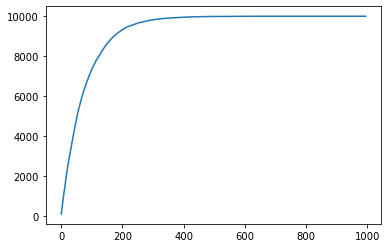

round:996で期待値として実施される署名数は12.947999999999999
unverify period :2.7666666666666666h
sig interval at edge:12.820512820512821m

round:1322	M:10000	n:93


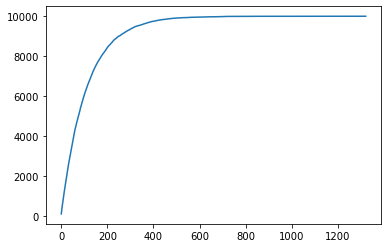

round:1322で期待値として実施される署名数は12.294599999999999
unverify period :3.672222222222222h
sig interval at edge:17.921146953405017m

round:1322	M:10000	n:71


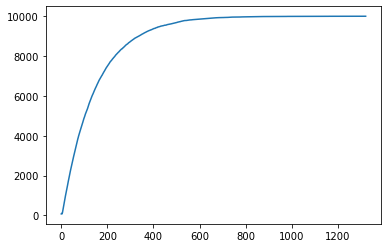

round:1322で期待値として実施される署名数は9.3862
unverify period :3.672222222222222h
sig interval at edge:23.474178403755865m



In [14]:
def sim(M,n):
    p=n/M
    y=np.zeros(M)
    state=np.zeros(M) # 署名したかを示す0,1のフラグ
    state[0]=1# state[0]を検証すべき署名が書かれる1のフラグとしてその伝播をシミュレーション
    round=0
    for loop in range (0,10000,1):
        #ベルヌーイ試行に従う署名者の一覧siger[i]=1の表を作成        
        siger=np.zeros(M)
        rand=np.random.rand(M)
        for i in range (0,M,1):
            if(rand[i]<p):
                siger[i]=1

        # 署名者sigerと共有済み者stateとの重複を確認
        cor=np.matmul(state,siger.T)
        if cor >= 1 or loop==0: #初回は強制で情報を伝搬させ，それ以外は署名者に伝搬済みの人がいる場合に伝搬
            state = state + siger

        # 署名回数ごとの共有済みの署名者数をカウントし，全員に広がったタイミングで終了する．
        y[loop]=np.count_nonzero(state)
        if y[loop]==M :
            round = loop
            break
#     print('round:{}\tM:{}\tn:{}\ty:{}'.format(round,M,n,y[0:round]))
    print('round:{}\tM:{}\tn:{}'.format(round,M,n))
    return round, y

interval = 10 #秒
M=10000
n=130 #署名参加者数
p=n/M
round ,y = sim(M,n)
fig, ax = plt.subplots()
ax.plot(y[0:round])
plt.show()
print('round:{}で期待値として実施される署名数は{}'.format(round,round*p))
print('unverify period :{}h'.format((round*interval)/(60*60)))
print('sig interval at edge:{}m\n'.format((interval/p)/60))

n=93 #署名参加者数
p=n/M
round ,y = sim(M,n)
fig, ax = plt.subplots()
ax.plot(y[0:round])
plt.show()
print('round:{}で期待値として実施される署名数は{}'.format(round,round*p))
print('unverify period :{}h'.format((round*interval)/(60*60)))
print('sig interval at edge:{}m\n'.format((interval/p)/60))

n=71 #署名参加者数
p=n/M
round ,y = sim(M,n)
fig, ax = plt.subplots()
ax.plot(y[0:round])
plt.show()
print('round:{}で期待値として実施される署名数は{}'.format(round,round*p))
print('unverify period :{}h'.format((round*interval)/(60*60)))
print('sig interval at edge:{}m\n'.format((interval/p)/60))

また．その伝播に必要な試行回数のぱらつきは以下の通りである．
一つのシミュレーション結果として，すべての端末まで情報を伝達するのに必要だった時間は
- $\alpha=1/3$で$500 \cdots1200$rounds=$1.38 \cdots3.33$時間
- $\alpha=1/2$で$800 \cdots1700$rounds=$2.22 \cdots4.72$時間
- $\alpha=1/3$で$1100 \cdots1700$rounds=$3.05 \cdots4.72$時間

round:385	M:10000	n:130


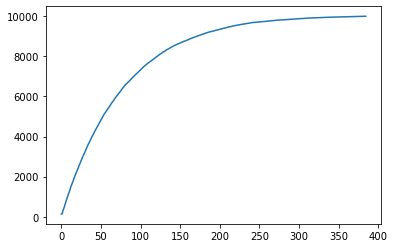

round:385で期待値として実施される署名数は5.005
unverify period :1.0694444444444444h
sig interval at edge:12.820512820512821m

round:536	M:10000	n:93


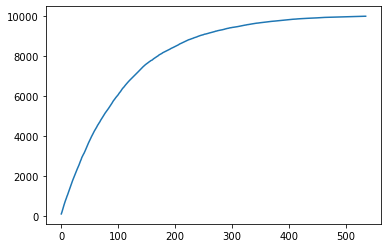

round:536で期待値として実施される署名数は4.9848
unverify period :1.488888888888889h
sig interval at edge:17.921146953405017m

round:704	M:10000	n:71


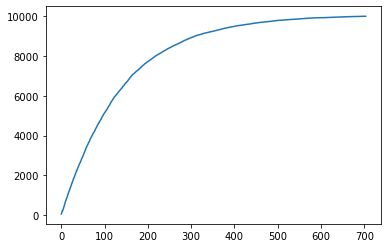

round:704で期待値として実施される署名数は4.9984
unverify period :1.9555555555555555h
sig interval at edge:23.474178403755865m



In [20]:
def sim_limit(M,n,l,insert):
    p=n/M
    y=np.zeros(M)
    state=np.zeros(M) # 署名したかを示す0,1のフラグ
    # state[0]=1# state[0]を検証すべき署名が書かれる1のフラグとしてその伝播をシミュレーション
    inter=np.zeros(M)
    round=0
    for loop in range (0,10000,1):
        #ベルヌーイ試行に従う署名者の一覧siger[i]=1の表を作成        
        siger=np.zeros(M)
        rand=np.random.rand(M)
        for i in range (0,M,1):
            if(rand[i]<p or inter[i]>l):
                siger[i]=1
                inter[i]=0
            else:
                inter[i]+=1

        # 署名者sigerと共有済み者stateとの重複を確認
        cor=np.matmul(state,siger.T)
        if loop == insert:
            state[0]=1
        if cor >= 1 or loop==insert: #初回は強制で情報を伝搬させ，それ以外は署名者に伝搬済みの人がいる場合に伝搬
            state = state + siger

        # 署名回数ごとの共有済みの署名者数をカウントし，全員に広がったタイミングで終了する．
        y[loop]=np.count_nonzero(state)
        if y[loop]==M :
            round = loop-insert
            break
#     print('round:{}\tM:{}\tn:{}\ty:{}'.format(round,M,n,y[0:round]))
    print('round:{}\tM:{}\tn:{}'.format(round,M,n))
    return round, y[insert:]

interval = 10 #秒
M=10000
insert=1000
x=5 # 署名インターバルの上限値設定

n=130 #署名参加者数
p=n/M
l = x*M/n
round ,y = sim_limit(M,n,l,insert)
fig, ax = plt.subplots()
ax.plot(y[0:round])
plt.show()
print('round:{}で期待値として実施される署名数は{}'.format(round,round*p))
print('unverify period :{}h'.format((round*interval)/(60*60)))
print('sig interval at edge:{}m\n'.format((interval/p)/60))

n=93 #署名参加者数
p=n/M
l = x*M/n
round ,y = sim_limit(M,n,l,insert)
fig, ax = plt.subplots()
ax.plot(y[0:round])
plt.show()
print('round:{}で期待値として実施される署名数は{}'.format(round,round*p))
print('unverify period :{}h'.format((round*interval)/(60*60)))
print('sig interval at edge:{}m\n'.format((interval/p)/60))

n=71 #署名参加者数
p=n/M
l = x*M/n
round ,y = sim_limit(M,n,l,insert)
fig, ax = plt.subplots()
ax.plot(y[0:round])
plt.show()
print('round:{}で期待値として実施される署名数は{}'.format(round,round*p))
print('unverify period :{}h'.format((round*interval)/(60*60)))
print('sig interval at edge:{}m\n'.format((interval/p)/60))

0
(879, array([121., 249., 365., ...,   0.,   0.,   0.]))
1
(737, array([150., 150., 282., ...,   0.,   0.,   0.]))
2
(687, array([148., 290., 431., ...,   0.,   0.,   0.]))
3
(663, array([136., 244., 380., ...,   0.,   0.,   0.]))
4
(625, array([122., 122., 122., ...,   0.,   0.,   0.]))
5
(748, array([119., 119., 246., ...,   0.,   0.,   0.]))
6
(792, array([128., 260., 370., ...,   0.,   0.,   0.]))
7
(730, array([127., 242., 390., ...,   0.,   0.,   0.]))
8
(979, array([131., 261., 377., ...,   0.,   0.,   0.]))
9
(660, array([124., 257., 383., ...,   0.,   0.,   0.]))
10
(743, array([142., 270., 408., ...,   0.,   0.,   0.]))
11
(873, array([145., 283., 424., ...,   0.,   0.,   0.]))
12
(630, array([126., 246., 372., ...,   0.,   0.,   0.]))
13
(779, array([107., 266., 383., ...,   0.,   0.,   0.]))
14
(626, array([123., 251., 379., ...,   0.,   0.,   0.]))
15
(710, array([128., 252., 378., ...,   0.,   0.,   0.]))
16
(819, array([147., 282., 391., ...,   0.,   0.,   0.]))
17
(987

(649, array([144., 279., 398., ...,   0.,   0.,   0.]))
139
(834, array([148., 275., 385., ...,   0.,   0.,   0.]))
140
(701, array([134., 251., 382., ...,   0.,   0.,   0.]))
141
(775, array([134., 134., 252., ...,   0.,   0.,   0.]))
142
(824, array([137., 262., 385., ...,   0.,   0.,   0.]))
143
(726, array([152., 292., 429., ...,   0.,   0.,   0.]))
144
(644, array([136., 253., 355., ...,   0.,   0.,   0.]))
145
(815, array([147., 278., 278., ...,   0.,   0.,   0.]))
146
(663, array([124., 124., 254., ...,   0.,   0.,   0.]))
147
(821, array([145., 263., 400., ...,   0.,   0.,   0.]))
148
(694, array([144., 144., 280., ...,   0.,   0.,   0.]))
149
(645, array([117., 242., 369., ...,   0.,   0.,   0.]))
150
(793, array([120., 242., 360., ...,   0.,   0.,   0.]))
151
(707, array([131., 269., 387., ...,   0.,   0.,   0.]))
152
(935, array([119., 266., 401., ...,   0.,   0.,   0.]))
153
(727, array([144., 264., 400., ...,   0.,   0.,   0.]))
154
(644, array([126., 255., 365., ...,   0.

(870, array([152., 271., 395., ...,   0.,   0.,   0.]))
275
(852, array([129., 129., 267., ...,   0.,   0.,   0.]))
276
(830, array([139., 263., 399., ...,   0.,   0.,   0.]))
277
(710, array([127., 127., 246., ...,   0.,   0.,   0.]))
278
(1183, array([137., 268., 400., ...,   0.,   0.,   0.]))
279
(686, array([137., 252., 383., ...,   0.,   0.,   0.]))
280
(684, array([138., 280., 420., ...,   0.,   0.,   0.]))
281
(947, array([126., 270., 396., ...,   0.,   0.,   0.]))
282
(967, array([134., 134., 254., ...,   0.,   0.,   0.]))
283
(703, array([145., 260., 260., ...,   0.,   0.,   0.]))
284
(684, array([133., 266., 376., ...,   0.,   0.,   0.]))
285
(704, array([134., 134., 134., ...,   0.,   0.,   0.]))
286
(711, array([133., 260., 385., ...,   0.,   0.,   0.]))
287
(665, array([118., 118., 118., ...,   0.,   0.,   0.]))
288
(718, array([132., 239., 373., ...,   0.,   0.,   0.]))
289
(715, array([145., 264., 393., ...,   0.,   0.,   0.]))
290
(703, array([139., 275., 397., ...,   0

(762, array([138., 261., 393., ...,   0.,   0.,   0.]))
411
(590, array([113., 244., 368., ...,   0.,   0.,   0.]))
412
(795, array([144., 297., 431., ...,   0.,   0.,   0.]))
413
(664, array([115., 248., 389., ...,   0.,   0.,   0.]))
414
(648, array([129., 246., 246., ...,   0.,   0.,   0.]))
415
(616, array([126., 126., 268., ...,   0.,   0.,   0.]))
416
(682, array([118., 236., 369., ...,   0.,   0.,   0.]))
417
(801, array([133., 260., 398., ...,   0.,   0.,   0.]))
418
(642, array([109., 257., 387., ...,   0.,   0.,   0.]))
419
(743, array([153., 277., 399., ...,   0.,   0.,   0.]))
420
(794, array([107., 246., 365., ...,   0.,   0.,   0.]))
421
(708, array([132., 272., 410., ...,   0.,   0.,   0.]))
422
(852, array([131., 131., 263., ...,   0.,   0.,   0.]))
423
(838, array([139., 275., 366., ...,   0.,   0.,   0.]))
424
(765, array([128., 251., 380., ...,   0.,   0.,   0.]))
425
(664, array([149., 273., 273., ...,   0.,   0.,   0.]))
426
(642, array([135., 135., 135., ...,   0.

(705, array([129., 260., 388., ...,   0.,   0.,   0.]))
547
(808, array([138., 261., 390., ...,   0.,   0.,   0.]))
548
(726, array([145., 271., 390., ...,   0.,   0.,   0.]))
549
(583, array([149., 280., 401., ...,   0.,   0.,   0.]))
550
(728, array([124., 124., 263., ...,   0.,   0.,   0.]))
551
(711, array([127., 127., 249., ...,   0.,   0.,   0.]))
552
(661, array([125., 240., 378., ...,   0.,   0.,   0.]))
553
(614, array([128., 257., 376., ...,   0.,   0.,   0.]))
554
(820, array([150., 264., 378., ...,   0.,   0.,   0.]))
555
(645, array([113., 237., 373., ...,   0.,   0.,   0.]))
556
(760, array([147., 147., 266., ...,   0.,   0.,   0.]))
557
(896, array([125., 247., 374., ...,   0.,   0.,   0.]))
558
(866, array([147., 288., 414., ...,   0.,   0.,   0.]))
559
(645, array([100., 218., 347., ...,   0.,   0.,   0.]))
560
(849, array([126., 245., 373., ...,   0.,   0.,   0.]))
561
(785, array([129., 248., 369., ...,   0.,   0.,   0.]))
562
(679, array([140., 262., 393., ...,   0.

(922, array([141., 273., 405., ...,   0.,   0.,   0.]))
683
(765, array([135., 283., 428., ...,   0.,   0.,   0.]))
684
(741, array([118., 247., 382., ...,   0.,   0.,   0.]))
685
(847, array([122., 260., 380., ...,   0.,   0.,   0.]))
686
(780, array([115., 253., 381., ...,   0.,   0.,   0.]))
687
(774, array([143., 259., 388., ...,   0.,   0.,   0.]))
688
(710, array([137., 246., 379., ...,   0.,   0.,   0.]))
689
(811, array([123., 257., 390., ...,   0.,   0.,   0.]))
690
(679, array([115., 246., 389., ...,   0.,   0.,   0.]))
691
(865, array([128., 251., 385., ...,   0.,   0.,   0.]))
692
(648, array([127., 127., 233., ...,   0.,   0.,   0.]))
693
(721, array([137., 251., 393., ...,   0.,   0.,   0.]))
694
(728, array([139., 239., 361., ...,   0.,   0.,   0.]))
695
(710, array([130., 256., 361., ...,   0.,   0.,   0.]))
696
(757, array([146., 269., 387., ...,   0.,   0.,   0.]))
697
(740, array([143., 254., 370., ...,   0.,   0.,   0.]))
698
(763, array([115., 242., 378., ...,   0.

(710, array([130., 252., 388., ...,   0.,   0.,   0.]))
819
(712, array([135., 135., 259., ...,   0.,   0.,   0.]))
820
(620, array([133., 133., 289., ...,   0.,   0.,   0.]))
821
(768, array([135., 268., 418., ...,   0.,   0.,   0.]))
822
(715, array([132., 259., 379., ...,   0.,   0.,   0.]))
823
(787, array([130., 256., 378., ...,   0.,   0.,   0.]))
824
(834, array([119., 247., 364., ...,   0.,   0.,   0.]))
825
(804, array([122., 258., 373., ...,   0.,   0.,   0.]))
826
(757, array([137., 276., 400., ...,   0.,   0.,   0.]))
827
(1045, array([106., 106., 239., ...,   0.,   0.,   0.]))
828
(647, array([117., 237., 384., ...,   0.,   0.,   0.]))
829
(648, array([146., 275., 415., ...,   0.,   0.,   0.]))
830
(875, array([139., 281., 281., ...,   0.,   0.,   0.]))
831
(704, array([130., 267., 390., ...,   0.,   0.,   0.]))
832
(1230, array([130., 244., 386., ...,   0.,   0.,   0.]))
833
(740, array([129., 260., 379., ...,   0.,   0.,   0.]))
834
(735, array([128., 258., 394., ...,   

(866, array([121., 240., 355., ...,   0.,   0.,   0.]))
955
(1032, array([118., 240., 391., ...,   0.,   0.,   0.]))
956
(724, array([127., 249., 370., ...,   0.,   0.,   0.]))
957
(718, array([132., 263., 374., ...,   0.,   0.,   0.]))
958
(819, array([134., 272., 383., ...,   0.,   0.,   0.]))
959
(641, array([135., 268., 395., ...,   0.,   0.,   0.]))
960
(782, array([120., 243., 379., ...,   0.,   0.,   0.]))
961
(828, array([156., 284., 399., ...,   0.,   0.,   0.]))
962
(627, array([122., 246., 246., ...,   0.,   0.,   0.]))
963
(843, array([122., 242., 355., ...,   0.,   0.,   0.]))
964
(837, array([135., 254., 388., ...,   0.,   0.,   0.]))
965
(834, array([145., 256., 380., ...,   0.,   0.,   0.]))
966
(873, array([129., 258., 371., ...,   0.,   0.,   0.]))
967
(837, array([117., 234., 362., ...,   0.,   0.,   0.]))
968
(697, array([129., 272., 406., ...,   0.,   0.,   0.]))
969
(866, array([149., 271., 401., ...,   0.,   0.,   0.]))
970
(695, array([119., 119., 254., ...,   0

(726, array([142., 276., 414., ...,   0.,   0.,   0.]))
1090
(753, array([110., 247., 396., ...,   0.,   0.,   0.]))
1091
(674, array([126., 256., 360., ...,   0.,   0.,   0.]))
1092
(824, array([142., 247., 365., ...,   0.,   0.,   0.]))
1093
(672, array([124., 251., 251., ...,   0.,   0.,   0.]))
1094
(763, array([112., 112., 112., ...,   0.,   0.,   0.]))
1095
(685, array([121., 248., 370., ...,   0.,   0.,   0.]))
1096
(650, array([141., 256., 387., ...,   0.,   0.,   0.]))
1097
(764, array([134., 259., 401., ...,   0.,   0.,   0.]))
1098
(709, array([122., 254., 395., ...,   0.,   0.,   0.]))
1099
(1099, array([139., 139., 267., ...,   0.,   0.,   0.]))
1100
(908, array([138., 283., 407., ...,   0.,   0.,   0.]))
1101
(723, array([119., 119., 229., ...,   0.,   0.,   0.]))
1102
(845, array([141., 261., 395., ...,   0.,   0.,   0.]))
1103
(900, array([135., 254., 386., ...,   0.,   0.,   0.]))
1104
(679, array([119., 233., 342., ...,   0.,   0.,   0.]))
1105
(680, array([137., 137.

(630, array([122., 235., 369., ...,   0.,   0.,   0.]))
1224
(731, array([120., 241., 387., ...,   0.,   0.,   0.]))
1225
(735, array([114., 247., 375., ...,   0.,   0.,   0.]))
1226
(657, array([136., 136., 266., ...,   0.,   0.,   0.]))
1227
(673, array([116., 116., 260., ...,   0.,   0.,   0.]))
1228
(786, array([132., 255., 401., ...,   0.,   0.,   0.]))
1229
(906, array([122., 259., 376., ...,   0.,   0.,   0.]))
1230
(723, array([125., 238., 369., ...,   0.,   0.,   0.]))
1231
(808, array([111., 252., 358., ...,   0.,   0.,   0.]))
1232
(687, array([134., 246., 377., ...,   0.,   0.,   0.]))
1233
(621, array([131., 270., 387., ...,   0.,   0.,   0.]))
1234
(642, array([132., 270., 412., ...,   0.,   0.,   0.]))
1235
(834, array([120., 249., 369., ...,   0.,   0.,   0.]))
1236
(819, array([117., 245., 376., ...,   0.,   0.,   0.]))
1237
(814, array([136., 251., 374., ...,   0.,   0.,   0.]))
1238
(802, array([131., 257., 379., ...,   0.,   0.,   0.]))
1239
(665, array([127., 257.,

(793, array([141., 264., 384., ...,   0.,   0.,   0.]))
1358
(758, array([122., 258., 386., ...,   0.,   0.,   0.]))
1359
(653, array([137., 259., 370., ...,   0.,   0.,   0.]))
1360
(600, array([140., 266., 431., ...,   0.,   0.,   0.]))
1361
(923, array([121., 247., 390., ...,   0.,   0.,   0.]))
1362
(896, array([146., 271., 393., ...,   0.,   0.,   0.]))
1363
(709, array([122., 253., 392., ...,   0.,   0.,   0.]))
1364
(690, array([135., 270., 376., ...,   0.,   0.,   0.]))
1365
(753, array([122., 122., 250., ...,   0.,   0.,   0.]))
1366
(853, array([127., 252., 379., ...,   0.,   0.,   0.]))
1367
(710, array([144., 294., 396., ...,   0.,   0.,   0.]))
1368
(736, array([122., 122., 241., ...,   0.,   0.,   0.]))
1369
(782, array([131., 263., 366., ...,   0.,   0.,   0.]))
1370
(821, array([141., 271., 386., ...,   0.,   0.,   0.]))
1371
(612, array([115., 256., 368., ...,   0.,   0.,   0.]))
1372
(713, array([106., 106., 214., ...,   0.,   0.,   0.]))
1373
(673, array([144., 264.,

(933, array([152., 287., 400., ...,   0.,   0.,   0.]))
1492
(713, array([128., 259., 380., ...,   0.,   0.,   0.]))
1493
(660, array([143., 260., 383., ...,   0.,   0.,   0.]))
1494
(937, array([141., 281., 400., ...,   0.,   0.,   0.]))
1495
(686, array([129., 254., 367., ...,   0.,   0.,   0.]))
1496
(694, array([132., 268., 384., ...,   0.,   0.,   0.]))
1497
(746, array([122., 273., 419., ...,   0.,   0.,   0.]))
1498
(654, array([114., 246., 360., ...,   0.,   0.,   0.]))
1499
(741, array([144., 253., 391., ...,   0.,   0.,   0.]))
1500
(748, array([132., 280., 393., ...,   0.,   0.,   0.]))
1501
(681, array([130., 264., 392., ...,   0.,   0.,   0.]))
1502
(644, array([129., 253., 357., ...,   0.,   0.,   0.]))
1503
(676, array([128., 245., 378., ...,   0.,   0.,   0.]))
1504
(881, array([120., 234., 368., ...,   0.,   0.,   0.]))
1505
(813, array([136., 251., 381., ...,   0.,   0.,   0.]))
1506
(650, array([127., 264., 406., ...,   0.,   0.,   0.]))
1507
(703, array([132., 132.,

(1084, array([144., 256., 391., ...,   0.,   0.,   0.]))
1626
(748, array([142., 279., 403., ...,   0.,   0.,   0.]))
1627
(688, array([127., 247., 375., ...,   0.,   0.,   0.]))
1628
(715, array([132., 264., 396., ...,   0.,   0.,   0.]))
1629
(698, array([124., 245., 380., ...,   0.,   0.,   0.]))
1630
(739, array([146., 285., 403., ...,   0.,   0.,   0.]))
1631
(882, array([116., 240., 353., ...,   0.,   0.,   0.]))
1632
(621, array([140., 271., 382., ...,   0.,   0.,   0.]))
1633
(807, array([135., 135., 259., ...,   0.,   0.,   0.]))
1634
(830, array([118., 239., 359., ...,   0.,   0.,   0.]))
1635
(801, array([143., 267., 380., ...,   0.,   0.,   0.]))
1636
(727, array([127., 236., 365., ...,   0.,   0.,   0.]))
1637
(609, array([139., 263., 392., ...,   0.,   0.,   0.]))
1638
(705, array([127., 257., 400., ...,   0.,   0.,   0.]))
1639
(855, array([128., 259., 381., ...,   0.,   0.,   0.]))
1640
(693, array([151., 277., 388., ...,   0.,   0.,   0.]))
1641
(675, array([107., 240.

(673, array([104., 230., 373., ...,   0.,   0.,   0.]))
1760
(726, array([120., 231., 367., ...,   0.,   0.,   0.]))
1761
(829, array([121., 255., 383., ...,   0.,   0.,   0.]))
1762
(818, array([143., 287., 400., ...,   0.,   0.,   0.]))
1763
(645, array([143., 297., 423., ...,   0.,   0.,   0.]))
1764
(798, array([131., 261., 400., ...,   0.,   0.,   0.]))
1765
(839, array([113., 233., 366., ...,   0.,   0.,   0.]))
1766
(697, array([110., 110., 242., ...,   0.,   0.,   0.]))
1767
(757, array([139., 265., 391., ...,   0.,   0.,   0.]))
1768
(773, array([122., 265., 407., ...,   0.,   0.,   0.]))
1769
(685, array([135., 257., 373., ...,   0.,   0.,   0.]))
1770
(742, array([132., 266., 394., ...,   0.,   0.,   0.]))
1771
(711, array([156., 300., 443., ...,   0.,   0.,   0.]))
1772
(930, array([139., 278., 420., ...,   0.,   0.,   0.]))
1773
(725, array([139., 139., 262., ...,   0.,   0.,   0.]))
1774
(888, array([117., 246., 370., ...,   0.,   0.,   0.]))
1775
(837, array([105., 227.,

(758, array([149., 263., 397., ...,   0.,   0.,   0.]))
1894
(651, array([117., 117., 232., ...,   0.,   0.,   0.]))
1895
(632, array([126., 126., 258., ...,   0.,   0.,   0.]))
1896
(683, array([143., 278., 420., ...,   0.,   0.,   0.]))
1897
(817, array([132., 254., 385., ...,   0.,   0.,   0.]))
1898
(784, array([119., 119., 242., ...,   0.,   0.,   0.]))
1899
(753, array([134., 275., 403., ...,   0.,   0.,   0.]))
1900
(772, array([137., 268., 395., ...,   0.,   0.,   0.]))
1901
(764, array([120., 240., 373., ...,   0.,   0.,   0.]))
1902
(620, array([133., 273., 394., ...,   0.,   0.,   0.]))
1903
(758, array([134., 269., 390., ...,   0.,   0.,   0.]))
1904
(765, array([125., 282., 416., ...,   0.,   0.,   0.]))
1905
(752, array([142., 263., 374., ...,   0.,   0.,   0.]))
1906
(761, array([129., 273., 401., ...,   0.,   0.,   0.]))
1907
(880, array([121., 262., 385., ...,   0.,   0.,   0.]))
1908
(657, array([125., 262., 378., ...,   0.,   0.,   0.]))
1909
(746, array([122., 122.,

(646, array([128., 253., 393., ...,   0.,   0.,   0.]))
2028
(838, array([131., 290., 429., ...,   0.,   0.,   0.]))
2029
(810, array([122., 252., 416., ...,   0.,   0.,   0.]))
2030
(692, array([121., 274., 408., ...,   0.,   0.,   0.]))
2031
(765, array([135., 264., 399., ...,   0.,   0.,   0.]))
2032
(673, array([134., 253., 356., ...,   0.,   0.,   0.]))
2033
(719, array([130., 232., 352., ...,   0.,   0.,   0.]))
2034
(630, array([132., 249., 369., ...,   0.,   0.,   0.]))
2035
(749, array([142., 257., 378., ...,   0.,   0.,   0.]))
2036
(782, array([136., 275., 391., ...,   0.,   0.,   0.]))
2037
(691, array([136., 240., 350., ...,   0.,   0.,   0.]))
2038
(743, array([105., 236., 347., ...,   0.,   0.,   0.]))
2039
(781, array([125., 238., 371., ...,   0.,   0.,   0.]))
2040
(678, array([137., 248., 357., ...,   0.,   0.,   0.]))
2041
(753, array([135., 135., 135., ...,   0.,   0.,   0.]))
2042
(669, array([119., 119., 243., ...,   0.,   0.,   0.]))
2043
(741, array([122., 245.,

(740, array([145., 145., 270., ...,   0.,   0.,   0.]))
2162
(707, array([118., 235., 362., ...,   0.,   0.,   0.]))
2163
(797, array([131., 131., 239., ...,   0.,   0.,   0.]))
2164
(686, array([140., 274., 401., ...,   0.,   0.,   0.]))
2165
(604, array([130., 257., 371., ...,   0.,   0.,   0.]))
2166
(699, array([117., 247., 373., ...,   0.,   0.,   0.]))
2167
(708, array([131., 258., 258., ...,   0.,   0.,   0.]))
2168
(699, array([144., 277., 395., ...,   0.,   0.,   0.]))
2169
(761, array([117., 228., 228., ...,   0.,   0.,   0.]))
2170
(755, array([120., 120., 230., ...,   0.,   0.,   0.]))
2171
(680, array([143., 285., 406., ...,   0.,   0.,   0.]))
2172
(687, array([122., 244., 385., ...,   0.,   0.,   0.]))
2173
(718, array([149., 276., 405., ...,   0.,   0.,   0.]))
2174
(836, array([133., 257., 377., ...,   0.,   0.,   0.]))
2175
(697, array([128., 266., 384., ...,   0.,   0.,   0.]))
2176
(759, array([129., 252., 397., ...,   0.,   0.,   0.]))
2177
(723, array([153., 307.,

(647, array([141., 265., 387., ...,   0.,   0.,   0.]))
2296
(931, array([137., 283., 402., ...,   0.,   0.,   0.]))
2297
(743, array([134., 251., 375., ...,   0.,   0.,   0.]))
2298
(653, array([126., 126., 261., ...,   0.,   0.,   0.]))
2299
(854, array([128., 128., 128., ...,   0.,   0.,   0.]))
2300
(641, array([107., 241., 356., ...,   0.,   0.,   0.]))
2301
(690, array([128., 264., 379., ...,   0.,   0.,   0.]))
2302
(714, array([150., 263., 387., ...,   0.,   0.,   0.]))
2303
(692, array([122., 122., 263., ...,   0.,   0.,   0.]))
2304
(861, array([120., 221., 346., ...,   0.,   0.,   0.]))
2305
(766, array([111., 227., 345., ...,   0.,   0.,   0.]))
2306
(680, array([131., 261., 387., ...,   0.,   0.,   0.]))
2307
(623, array([144., 263., 409., ...,   0.,   0.,   0.]))
2308
(767, array([117., 246., 372., ...,   0.,   0.,   0.]))
2309
(798, array([125., 242., 374., ...,   0.,   0.,   0.]))
2310
(650, array([129., 254., 397., ...,   0.,   0.,   0.]))
2311
(753, array([133., 277.,

(650, array([134., 243., 394., ...,   0.,   0.,   0.]))
2430
(660, array([131., 131., 260., ...,   0.,   0.,   0.]))
2431
(642, array([118., 242., 358., ...,   0.,   0.,   0.]))
2432
(593, array([119., 246., 368., ...,   0.,   0.,   0.]))
2433
(938, array([124., 242., 374., ...,   0.,   0.,   0.]))
2434
(774, array([128., 128., 248., ...,   0.,   0.,   0.]))
2435
(708, array([144., 284., 406., ...,   0.,   0.,   0.]))
2436
(744, array([136., 266., 375., ...,   0.,   0.,   0.]))
2437
(667, array([128., 261., 362., ...,   0.,   0.,   0.]))
2438
(620, array([144., 270., 394., ...,   0.,   0.,   0.]))
2439
(697, array([108., 227., 353., ...,   0.,   0.,   0.]))
2440
(673, array([137., 258., 390., ...,   0.,   0.,   0.]))
2441
(857, array([144., 251., 377., ...,   0.,   0.,   0.]))
2442
(849, array([147., 263., 400., ...,   0.,   0.,   0.]))
2443
(764, array([123., 123., 241., ...,   0.,   0.,   0.]))
2444
(919, array([124., 124., 247., ...,   0.,   0.,   0.]))
2445
(716, array([129., 268.,

(726, array([136., 243., 365., ...,   0.,   0.,   0.]))
2564
(879, array([132., 255., 382., ...,   0.,   0.,   0.]))
2565
(755, array([126., 269., 384., ...,   0.,   0.,   0.]))
2566
(776, array([126., 256., 403., ...,   0.,   0.,   0.]))
2567
(613, array([128., 261., 390., ...,   0.,   0.,   0.]))
2568
(672, array([119., 255., 385., ...,   0.,   0.,   0.]))
2569
(632, array([146., 264., 401., ...,   0.,   0.,   0.]))
2570
(758, array([139., 261., 380., ...,   0.,   0.,   0.]))
2571
(707, array([128., 262., 407., ...,   0.,   0.,   0.]))
2572
(831, array([140., 282., 392., ...,   0.,   0.,   0.]))
2573
(753, array([128., 254., 386., ...,   0.,   0.,   0.]))
2574
(645, array([120., 120., 120., ...,   0.,   0.,   0.]))
2575
(854, array([125., 125., 267., ...,   0.,   0.,   0.]))
2576
(792, array([130., 251., 360., ...,   0.,   0.,   0.]))
2577
(740, array([132., 258., 391., ...,   0.,   0.,   0.]))
2578
(631, array([145., 267., 373., ...,   0.,   0.,   0.]))
2579
(748, array([126., 249.,

(768, array([136., 136., 250., ...,   0.,   0.,   0.]))
2698
(643, array([143., 273., 394., ...,   0.,   0.,   0.]))
2699
(691, array([154., 284., 404., ...,   0.,   0.,   0.]))
2700
(962, array([132., 271., 397., ...,   0.,   0.,   0.]))
2701
(675, array([121., 262., 391., ...,   0.,   0.,   0.]))
2702
(926, array([122., 241., 348., ...,   0.,   0.,   0.]))
2703
(645, array([136., 258., 368., ...,   0.,   0.,   0.]))
2704
(826, array([148., 282., 431., ...,   0.,   0.,   0.]))
2705
(996, array([126., 126., 247., ...,   0.,   0.,   0.]))
2706
(716, array([144., 144., 284., ...,   0.,   0.,   0.]))
2707
(767, array([138., 263., 374., ...,   0.,   0.,   0.]))
2708
(803, array([132., 265., 383., ...,   0.,   0.,   0.]))
2709
(730, array([137., 231., 231., ...,   0.,   0.,   0.]))
2710
(620, array([138., 281., 418., ...,   0.,   0.,   0.]))
2711
(690, array([123., 123., 255., ...,   0.,   0.,   0.]))
2712
(706, array([145., 264., 405., ...,   0.,   0.,   0.]))
2713
(687, array([152., 285.,

(850, array([145., 281., 426., ...,   0.,   0.,   0.]))
2832
(721, array([117., 240., 363., ...,   0.,   0.,   0.]))
2833
(752, array([125., 261., 397., ...,   0.,   0.,   0.]))
2834
(868, array([137., 252., 381., ...,   0.,   0.,   0.]))
2835
(850, array([140., 284., 419., ...,   0.,   0.,   0.]))
2836
(767, array([125., 245., 356., ...,   0.,   0.,   0.]))
2837
(891, array([149., 269., 414., ...,   0.,   0.,   0.]))
2838
(720, array([127., 228., 349., ...,   0.,   0.,   0.]))
2839
(722, array([124., 124., 124., ...,   0.,   0.,   0.]))
2840
(1074, array([129., 259., 381., ...,   0.,   0.,   0.]))
2841
(1047, array([146., 301., 419., ...,   0.,   0.,   0.]))
2842
(605, array([118., 248., 381., ...,   0.,   0.,   0.]))
2843
(700, array([130., 130., 259., ...,   0.,   0.,   0.]))
2844
(637, array([120., 260., 378., ...,   0.,   0.,   0.]))
2845
(602, array([149., 280., 407., ...,   0.,   0.,   0.]))
2846
(785, array([136., 274., 417., ...,   0.,   0.,   0.]))
2847
(655, array([151., 268

(768, array([115., 231., 348., ...,   0.,   0.,   0.]))
2966
(786, array([118., 244., 374., ...,   0.,   0.,   0.]))
2967
(800, array([112., 232., 360., ...,   0.,   0.,   0.]))
2968
(635, array([123., 241., 356., ...,   0.,   0.,   0.]))
2969
(674, array([140., 140., 260., ...,   0.,   0.,   0.]))
2970
(913, array([128., 258., 396., ...,   0.,   0.,   0.]))
2971
(835, array([123., 258., 378., ...,   0.,   0.,   0.]))
2972
(669, array([130., 235., 369., ...,   0.,   0.,   0.]))
2973
(861, array([111., 252., 398., ...,   0.,   0.,   0.]))
2974
(743, array([122., 229., 361., ...,   0.,   0.,   0.]))
2975
(699, array([117., 251., 374., ...,   0.,   0.,   0.]))
2976
(784, array([147., 147., 291., ...,   0.,   0.,   0.]))
2977
(756, array([137., 247., 386., ...,   0.,   0.,   0.]))
2978
(842, array([154., 277., 394., ...,   0.,   0.,   0.]))
2979
(663, array([131., 131., 259., ...,   0.,   0.,   0.]))
2980
(695, array([141., 277., 391., ...,   0.,   0.,   0.]))
2981
(726, array([112., 217.,

(744, array([125., 280., 403., ...,   0.,   0.,   0.]))
3100
(854, array([136., 259., 383., ...,   0.,   0.,   0.]))
3101
(1014, array([147., 268., 389., ...,   0.,   0.,   0.]))
3102
(660, array([125., 249., 390., ...,   0.,   0.,   0.]))
3103
(768, array([125., 125., 252., ...,   0.,   0.,   0.]))
3104
(759, array([ 97., 230., 357., ...,   0.,   0.,   0.]))
3105
(741, array([118., 224., 330., ...,   0.,   0.,   0.]))
3106
(756, array([134., 276., 404., ...,   0.,   0.,   0.]))
3107
(1015, array([145., 288., 425., ...,   0.,   0.,   0.]))
3108
(684, array([148., 289., 418., ...,   0.,   0.,   0.]))
3109
(795, array([133., 283., 387., ...,   0.,   0.,   0.]))
3110
(945, array([135., 251., 376., ...,   0.,   0.,   0.]))
3111
(759, array([132., 266., 403., ...,   0.,   0.,   0.]))
3112
(672, array([145., 246., 384., ...,   0.,   0.,   0.]))
3113
(731, array([109., 109., 239., ...,   0.,   0.,   0.]))
3114
(687, array([147., 280., 408., ...,   0.,   0.,   0.]))
3115
(748, array([115., 227

(877, array([120., 267., 379., ...,   0.,   0.,   0.]))
3234
(709, array([122., 250., 250., ...,   0.,   0.,   0.]))
3235
(817, array([118., 264., 385., ...,   0.,   0.,   0.]))
3236
(783, array([144., 283., 404., ...,   0.,   0.,   0.]))
3237
(873, array([139., 139., 284., ...,   0.,   0.,   0.]))
3238
(628, array([118., 271., 271., ...,   0.,   0.,   0.]))
3239
(647, array([139., 139., 259., ...,   0.,   0.,   0.]))
3240
(789, array([132., 254., 390., ...,   0.,   0.,   0.]))
3241
(842, array([116., 249., 373., ...,   0.,   0.,   0.]))
3242
(706, array([132., 132., 258., ...,   0.,   0.,   0.]))
3243
(690, array([122., 241., 371., ...,   0.,   0.,   0.]))
3244
(605, array([128., 257., 384., ...,   0.,   0.,   0.]))
3245
(676, array([121., 265., 388., ...,   0.,   0.,   0.]))
3246
(689, array([143., 269., 404., ...,   0.,   0.,   0.]))
3247
(633, array([141., 272., 410., ...,   0.,   0.,   0.]))
3248
(721, array([148., 284., 401., ...,   0.,   0.,   0.]))
3249
(832, array([116., 236.,

(859, array([131., 273., 410., ...,   0.,   0.,   0.]))
3368
(767, array([140., 261., 399., ...,   0.,   0.,   0.]))
3369
(822, array([118., 118., 118., ...,   0.,   0.,   0.]))
3370
(768, array([115., 256., 368., ...,   0.,   0.,   0.]))
3371
(783, array([130., 266., 399., ...,   0.,   0.,   0.]))
3372
(624, array([124., 231., 330., ...,   0.,   0.,   0.]))
3373
(741, array([133., 256., 380., ...,   0.,   0.,   0.]))
3374
(712, array([116., 116., 242., ...,   0.,   0.,   0.]))
3375
(915, array([121., 121., 247., ...,   0.,   0.,   0.]))
3376
(730, array([134., 253., 380., ...,   0.,   0.,   0.]))
3377
(647, array([146., 283., 420., ...,   0.,   0.,   0.]))
3378
(759, array([120., 251., 392., ...,   0.,   0.,   0.]))
3379
(620, array([121., 121., 256., ...,   0.,   0.,   0.]))
3380
(769, array([158., 271., 411., ...,   0.,   0.,   0.]))
3381
(723, array([125., 257., 378., ...,   0.,   0.,   0.]))
3382
(637, array([128., 270., 412., ...,   0.,   0.,   0.]))
3383
(630, array([114., 250.,

(651, array([152., 278., 398., ...,   0.,   0.,   0.]))
3502
(899, array([119., 119., 252., ...,   0.,   0.,   0.]))
3503
(711, array([130., 255., 392., ...,   0.,   0.,   0.]))
3504
(690, array([147., 275., 401., ...,   0.,   0.,   0.]))
3505
(685, array([131., 267., 388., ...,   0.,   0.,   0.]))
3506
(712, array([113., 244., 361., ...,   0.,   0.,   0.]))
3507
(618, array([130., 273., 403., ...,   0.,   0.,   0.]))
3508
(834, array([126., 126., 260., ...,   0.,   0.,   0.]))
3509
(642, array([134., 265., 397., ...,   0.,   0.,   0.]))
3510
(800, array([131., 270., 408., ...,   0.,   0.,   0.]))
3511
(642, array([132., 271., 405., ...,   0.,   0.,   0.]))
3512
(618, array([123., 248., 372., ...,   0.,   0.,   0.]))
3513
(897, array([133., 285., 406., ...,   0.,   0.,   0.]))
3514
(737, array([113., 242., 348., ...,   0.,   0.,   0.]))
3515
(827, array([129., 249., 376., ...,   0.,   0.,   0.]))
3516
(719, array([129., 241., 378., ...,   0.,   0.,   0.]))
3517
(707, array([109., 109.,

(919, array([111., 111., 111., ...,   0.,   0.,   0.]))
3636
(826, array([131., 257., 399., ...,   0.,   0.,   0.]))
3637
(1011, array([132., 267., 386., ...,   0.,   0.,   0.]))
3638
(715, array([129., 249., 366., ...,   0.,   0.,   0.]))
3639
(744, array([105., 255., 389., ...,   0.,   0.,   0.]))
3640
(651, array([117., 249., 378., ...,   0.,   0.,   0.]))
3641
(804, array([134., 257., 386., ...,   0.,   0.,   0.]))
3642
(738, array([145., 236., 236., ...,   0.,   0.,   0.]))
3643
(769, array([129., 261., 380., ...,   0.,   0.,   0.]))
3644
(725, array([118., 261., 406., ...,   0.,   0.,   0.]))
3645
(879, array([125., 125., 256., ...,   0.,   0.,   0.]))
3646
(643, array([141., 256., 373., ...,   0.,   0.,   0.]))
3647
(976, array([125., 250., 381., ...,   0.,   0.,   0.]))
3648
(820, array([126., 262., 392., ...,   0.,   0.,   0.]))
3649
(609, array([129., 243., 386., ...,   0.,   0.,   0.]))
3650
(894, array([128., 256., 373., ...,   0.,   0.,   0.]))
3651
(778, array([133., 271.

(946, array([132., 271., 400., ...,   0.,   0.,   0.]))
3770
(687, array([128., 255., 382., ...,   0.,   0.,   0.]))
3771
(828, array([122., 254., 386., ...,   0.,   0.,   0.]))
3772
(623, array([120., 120., 231., ...,   0.,   0.,   0.]))
3773
(929, array([116., 230., 377., ...,   0.,   0.,   0.]))
3774
(743, array([128., 273., 398., ...,   0.,   0.,   0.]))
3775
(885, array([121., 243., 358., ...,   0.,   0.,   0.]))
3776
(642, array([132., 248., 378., ...,   0.,   0.,   0.]))
3777
(886, array([125., 262., 369., ...,   0.,   0.,   0.]))
3778
(833, array([152., 271., 271., ...,   0.,   0.,   0.]))
3779
(891, array([130., 254., 390., ...,   0.,   0.,   0.]))
3780
(903, array([130., 247., 373., ...,   0.,   0.,   0.]))
3781
(780, array([117., 249., 370., ...,   0.,   0.,   0.]))
3782
(758, array([134., 267., 388., ...,   0.,   0.,   0.]))
3783
(709, array([134., 268., 405., ...,   0.,   0.,   0.]))
3784
(797, array([154., 264., 399., ...,   0.,   0.,   0.]))
3785
(656, array([152., 258.,

(614, array([125., 242., 363., ...,   0.,   0.,   0.]))
3904
(783, array([136., 270., 397., ...,   0.,   0.,   0.]))
3905
(644, array([155., 294., 422., ...,   0.,   0.,   0.]))
3906
(853, array([126., 259., 390., ...,   0.,   0.,   0.]))
3907
(747, array([121., 121., 263., ...,   0.,   0.,   0.]))
3908
(630, array([122., 255., 387., ...,   0.,   0.,   0.]))
3909
(792, array([126., 242., 368., ...,   0.,   0.,   0.]))
3910
(795, array([157., 264., 400., ...,   0.,   0.,   0.]))
3911
(615, array([127., 245., 373., ...,   0.,   0.,   0.]))
3912
(797, array([152., 284., 403., ...,   0.,   0.,   0.]))
3913
(768, array([144., 144., 144., ...,   0.,   0.,   0.]))
3914
(749, array([124., 124., 259., ...,   0.,   0.,   0.]))
3915
(733, array([142., 266., 381., ...,   0.,   0.,   0.]))
3916
(875, array([143., 266., 266., ...,   0.,   0.,   0.]))
3917
(694, array([146., 266., 388., ...,   0.,   0.,   0.]))
3918
(836, array([142., 142., 142., ...,   0.,   0.,   0.]))
3919
(678, array([135., 272.,

(612, array([107., 233., 362., ...,   0.,   0.,   0.]))
4038
(686, array([148., 278., 392., ...,   0.,   0.,   0.]))
4039
(966, array([125., 266., 400., ...,   0.,   0.,   0.]))
4040
(855, array([133., 271., 401., ...,   0.,   0.,   0.]))
4041
(723, array([135., 241., 353., ...,   0.,   0.,   0.]))
4042
(774, array([138., 275., 398., ...,   0.,   0.,   0.]))
4043
(644, array([117., 249., 380., ...,   0.,   0.,   0.]))
4044
(673, array([149., 269., 407., ...,   0.,   0.,   0.]))
4045
(754, array([122., 122., 248., ...,   0.,   0.,   0.]))
4046
(635, array([136., 271., 388., ...,   0.,   0.,   0.]))
4047
(640, array([134., 254., 380., ...,   0.,   0.,   0.]))
4048
(1077, array([142., 250., 250., ...,   0.,   0.,   0.]))
4049
(749, array([114., 114., 248., ...,   0.,   0.,   0.]))
4050
(667, array([140., 279., 406., ...,   0.,   0.,   0.]))
4051
(786, array([143., 279., 419., ...,   0.,   0.,   0.]))
4052
(677, array([106., 242., 366., ...,   0.,   0.,   0.]))
4053
(810, array([120., 242.

(844, array([144., 270., 408., ...,   0.,   0.,   0.]))
4172
(711, array([123., 256., 369., ...,   0.,   0.,   0.]))
4173
(683, array([139., 260., 395., ...,   0.,   0.,   0.]))
4174
(676, array([144., 279., 279., ...,   0.,   0.,   0.]))
4175
(682, array([129., 277., 405., ...,   0.,   0.,   0.]))
4176
(1099, array([140., 250., 386., ...,   0.,   0.,   0.]))
4177
(707, array([116., 116., 259., ...,   0.,   0.,   0.]))
4178
(694, array([138., 270., 397., ...,   0.,   0.,   0.]))
4179
(686, array([129., 254., 363., ...,   0.,   0.,   0.]))
4180
(797, array([128., 263., 404., ...,   0.,   0.,   0.]))
4181
(937, array([124., 268., 399., ...,   0.,   0.,   0.]))
4182
(652, array([141., 269., 374., ...,   0.,   0.,   0.]))
4183
(758, array([137., 268., 388., ...,   0.,   0.,   0.]))
4184
(697, array([104., 236., 344., ...,   0.,   0.,   0.]))
4185
(708, array([132., 274., 392., ...,   0.,   0.,   0.]))
4186
(918, array([115., 239., 374., ...,   0.,   0.,   0.]))
4187
(703, array([111., 229.

(808, array([138., 261., 380., ...,   0.,   0.,   0.]))
4306
(870, array([114., 248., 352., ...,   0.,   0.,   0.]))
4307
(798, array([125., 248., 390., ...,   0.,   0.,   0.]))
4308
(816, array([135., 135., 263., ...,   0.,   0.,   0.]))
4309
(814, array([129., 129., 254., ...,   0.,   0.,   0.]))
4310
(676, array([101., 238., 384., ...,   0.,   0.,   0.]))
4311
(688, array([145., 277., 433., ...,   0.,   0.,   0.]))
4312
(877, array([135., 252., 380., ...,   0.,   0.,   0.]))
4313
(755, array([125., 239., 355., ...,   0.,   0.,   0.]))
4314
(931, array([133., 245., 360., ...,   0.,   0.,   0.]))
4315
(728, array([134., 270., 401., ...,   0.,   0.,   0.]))
4316
(684, array([128., 243., 372., ...,   0.,   0.,   0.]))
4317
(816, array([115., 257., 394., ...,   0.,   0.,   0.]))
4318
(798, array([140., 140., 140., ...,   0.,   0.,   0.]))
4319
(706, array([115., 246., 396., ...,   0.,   0.,   0.]))
4320
(844, array([159., 309., 442., ...,   0.,   0.,   0.]))
4321
(747, array([136., 261.,

(733, array([124., 239., 360., ...,   0.,   0.,   0.]))
4440
(678, array([130., 267., 390., ...,   0.,   0.,   0.]))
4441
(730, array([136., 258., 400., ...,   0.,   0.,   0.]))
4442
(689, array([137., 245., 352., ...,   0.,   0.,   0.]))
4443
(804, array([114., 236., 355., ...,   0.,   0.,   0.]))
4444
(757, array([118., 248., 248., ...,   0.,   0.,   0.]))
4445
(1313, array([132., 263., 392., ...,   0.,   0.,   0.]))
4446
(890, array([134., 277., 416., ...,   0.,   0.,   0.]))
4447
(764, array([141., 141., 253., ...,   0.,   0.,   0.]))
4448
(642, array([153., 262., 371., ...,   0.,   0.,   0.]))
4449
(794, array([133., 259., 390., ...,   0.,   0.,   0.]))
4450
(615, array([107., 235., 343., ...,   0.,   0.,   0.]))
4451
(669, array([126., 258., 387., ...,   0.,   0.,   0.]))
4452
(745, array([125., 232., 360., ...,   0.,   0.,   0.]))
4453
(803, array([113., 241., 378., ...,   0.,   0.,   0.]))
4454
(565, array([132., 250., 376., ...,   0.,   0.,   0.]))
4455
(708, array([134., 255.

(652, array([131., 267., 267., ...,   0.,   0.,   0.]))
4574
(770, array([144., 265., 408., ...,   0.,   0.,   0.]))
4575
(787, array([121., 274., 399., ...,   0.,   0.,   0.]))
4576
(818, array([142., 294., 428., ...,   0.,   0.,   0.]))
4577
(1127, array([128., 256., 380., ...,   0.,   0.,   0.]))
4578
(702, array([140., 269., 399., ...,   0.,   0.,   0.]))
4579
(624, array([158., 291., 411., ...,   0.,   0.,   0.]))
4580
(622, array([132., 246., 376., ...,   0.,   0.,   0.]))
4581
(646, array([129., 250., 387., ...,   0.,   0.,   0.]))
4582
(830, array([130., 260., 400., ...,   0.,   0.,   0.]))
4583
(753, array([108., 276., 276., ...,   0.,   0.,   0.]))
4584
(697, array([142., 263., 407., ...,   0.,   0.,   0.]))
4585
(666, array([137., 261., 382., ...,   0.,   0.,   0.]))
4586
(727, array([134., 264., 378., ...,   0.,   0.,   0.]))
4587
(727, array([141., 273., 400., ...,   0.,   0.,   0.]))
4588
(816, array([130., 130., 243., ...,   0.,   0.,   0.]))
4589
(608, array([112., 224.

(795, array([121., 235., 235., ...,   0.,   0.,   0.]))
4708
(686, array([136., 277., 405., ...,   0.,   0.,   0.]))
4709
(664, array([136., 268., 389., ...,   0.,   0.,   0.]))
4710
(744, array([135., 276., 401., ...,   0.,   0.,   0.]))
4711
(971, array([121., 236., 379., ...,   0.,   0.,   0.]))
4712
(658, array([113., 245., 389., ...,   0.,   0.,   0.]))
4713
(677, array([118., 118., 245., ...,   0.,   0.,   0.]))
4714
(845, array([137., 277., 399., ...,   0.,   0.,   0.]))
4715
(734, array([149., 279., 402., ...,   0.,   0.,   0.]))
4716
(756, array([129., 246., 363., ...,   0.,   0.,   0.]))
4717
(641, array([129., 267., 388., ...,   0.,   0.,   0.]))
4718
(653, array([129., 265., 395., ...,   0.,   0.,   0.]))
4719
(670, array([124., 243., 375., ...,   0.,   0.,   0.]))
4720
(705, array([128., 260., 381., ...,   0.,   0.,   0.]))
4721
(655, array([146., 264., 388., ...,   0.,   0.,   0.]))
4722
(847, array([132., 239., 372., ...,   0.,   0.,   0.]))
4723
(1039, array([149., 272.

(742, array([130., 259., 370., ...,   0.,   0.,   0.]))
4842
(729, array([125., 125., 244., ...,   0.,   0.,   0.]))
4843
(739, array([132., 261., 261., ...,   0.,   0.,   0.]))
4844
(663, array([133., 236., 374., ...,   0.,   0.,   0.]))
4845
(873, array([101., 229., 377., ...,   0.,   0.,   0.]))
4846
(737, array([129., 269., 396., ...,   0.,   0.,   0.]))
4847
(652, array([137., 269., 397., ...,   0.,   0.,   0.]))
4848
(885, array([135., 257., 374., ...,   0.,   0.,   0.]))
4849
(614, array([123., 258., 370., ...,   0.,   0.,   0.]))
4850
(714, array([135., 264., 406., ...,   0.,   0.,   0.]))
4851
(714, array([124., 262., 396., ...,   0.,   0.,   0.]))
4852
(897, array([128., 128., 261., ...,   0.,   0.,   0.]))
4853
(745, array([114., 253., 381., ...,   0.,   0.,   0.]))
4854
(752, array([130., 130., 254., ...,   0.,   0.,   0.]))
4855
(841, array([114., 241., 359., ...,   0.,   0.,   0.]))
4856
(742, array([122., 253., 385., ...,   0.,   0.,   0.]))
4857
(787, array([124., 238.,

(792, array([128., 256., 388., ...,   0.,   0.,   0.]))
4976
(696, array([119., 242., 360., ...,   0.,   0.,   0.]))
4977
(591, array([136., 277., 414., ...,   0.,   0.,   0.]))
4978
(744, array([130., 253., 386., ...,   0.,   0.,   0.]))
4979
(762, array([135., 270., 409., ...,   0.,   0.,   0.]))
4980
(773, array([120., 245., 376., ...,   0.,   0.,   0.]))
4981
(710, array([135., 251., 369., ...,   0.,   0.,   0.]))
4982
(728, array([134., 268., 380., ...,   0.,   0.,   0.]))
4983
(824, array([147., 273., 417., ...,   0.,   0.,   0.]))
4984
(731, array([142., 293., 429., ...,   0.,   0.,   0.]))
4985
(752, array([124., 124., 279., ...,   0.,   0.,   0.]))
4986
(678, array([139., 260., 260., ...,   0.,   0.,   0.]))
4987
(589, array([127., 255., 255., ...,   0.,   0.,   0.]))
4988
(654, array([129., 272., 403., ...,   0.,   0.,   0.]))
4989
(883, array([113., 113., 240., ...,   0.,   0.,   0.]))
4990
(637, array([116., 116., 236., ...,   0.,   0.,   0.]))
4991
(887, array([127., 262.,

(729, array([109., 109., 236., ...,   0.,   0.,   0.]))
5110
(799, array([121., 243., 371., ...,   0.,   0.,   0.]))
5111
(903, array([122., 239., 367., ...,   0.,   0.,   0.]))
5112
(639, array([120., 268., 416., ...,   0.,   0.,   0.]))
5113
(841, array([127., 250., 250., ...,   0.,   0.,   0.]))
5114
(712, array([127., 267., 400., ...,   0.,   0.,   0.]))
5115
(826, array([126., 255., 388., ...,   0.,   0.,   0.]))
5116
(609, array([146., 262., 381., ...,   0.,   0.,   0.]))
5117
(618, array([152., 282., 402., ...,   0.,   0.,   0.]))
5118
(817, array([137., 265., 389., ...,   0.,   0.,   0.]))
5119
(844, array([134., 259., 388., ...,   0.,   0.,   0.]))
5120
(675, array([148., 278., 391., ...,   0.,   0.,   0.]))
5121
(857, array([146., 287., 423., ...,   0.,   0.,   0.]))
5122
(752, array([127., 252., 372., ...,   0.,   0.,   0.]))
5123
(664, array([140., 140., 267., ...,   0.,   0.,   0.]))
5124
(763, array([126., 250., 375., ...,   0.,   0.,   0.]))
5125
(816, array([121., 121.,

(673, array([108., 214., 337., ...,   0.,   0.,   0.]))
5244
(775, array([111., 243., 387., ...,   0.,   0.,   0.]))
5245
(834, array([117., 258., 412., ...,   0.,   0.,   0.]))
5246
(766, array([145., 278., 424., ...,   0.,   0.,   0.]))
5247
(651, array([125., 250., 364., ...,   0.,   0.,   0.]))
5248
(813, array([156., 285., 411., ...,   0.,   0.,   0.]))
5249
(878, array([140., 140., 267., ...,   0.,   0.,   0.]))
5250
(726, array([103., 237., 364., ...,   0.,   0.,   0.]))
5251
(734, array([124., 124., 239., ...,   0.,   0.,   0.]))
5252
(910, array([125., 125., 125., ...,   0.,   0.,   0.]))
5253
(793, array([143., 272., 409., ...,   0.,   0.,   0.]))
5254
(900, array([113., 113., 113., ...,   0.,   0.,   0.]))
5255
(554, array([144., 289., 406., ...,   0.,   0.,   0.]))
5256
(847, array([128., 264., 378., ...,   0.,   0.,   0.]))
5257
(771, array([130., 260., 402., ...,   0.,   0.,   0.]))
5258
(645, array([140., 278., 412., ...,   0.,   0.,   0.]))
5259
(946, array([146., 290.,

(599, array([137., 260., 408., ...,   0.,   0.,   0.]))
5378
(736, array([118., 118., 118., ...,   0.,   0.,   0.]))
5379
(729, array([127., 127., 127., ...,   0.,   0.,   0.]))
5380
(826, array([127., 251., 387., ...,   0.,   0.,   0.]))
5381
(602, array([138., 281., 406., ...,   0.,   0.,   0.]))
5382
(791, array([131., 249., 379., ...,   0.,   0.,   0.]))
5383
(750, array([147., 271., 397., ...,   0.,   0.,   0.]))
5384
(751, array([154., 154., 285., ...,   0.,   0.,   0.]))
5385
(933, array([111., 236., 359., ...,   0.,   0.,   0.]))
5386
(681, array([146., 289., 435., ...,   0.,   0.,   0.]))
5387
(707, array([132., 132., 256., ...,   0.,   0.,   0.]))
5388
(947, array([134., 271., 407., ...,   0.,   0.,   0.]))
5389
(847, array([143., 284., 405., ...,   0.,   0.,   0.]))
5390
(704, array([132., 255., 255., ...,   0.,   0.,   0.]))
5391
(826, array([136., 242., 372., ...,   0.,   0.,   0.]))
5392
(624, array([124., 239., 359., ...,   0.,   0.,   0.]))
5393
(647, array([120., 255.,

(901, array([138., 248., 385., ...,   0.,   0.,   0.]))
5512
(807, array([148., 279., 416., ...,   0.,   0.,   0.]))
5513
(728, array([126., 264., 420., ...,   0.,   0.,   0.]))
5514
(921, array([142., 281., 410., ...,   0.,   0.,   0.]))
5515
(659, array([122., 251., 352., ...,   0.,   0.,   0.]))
5516
(736, array([117., 117., 117., ...,   0.,   0.,   0.]))
5517
(651, array([137., 268., 384., ...,   0.,   0.,   0.]))
5518
(708, array([136., 262., 394., ...,   0.,   0.,   0.]))
5519
(680, array([134., 270., 399., ...,   0.,   0.,   0.]))
5520
(812, array([140., 268., 401., ...,   0.,   0.,   0.]))
5521
(808, array([137., 271., 409., ...,   0.,   0.,   0.]))
5522
(722, array([136., 256., 395., ...,   0.,   0.,   0.]))
5523
(825, array([126., 242., 355., ...,   0.,   0.,   0.]))
5524
(756, array([117., 248., 248., ...,   0.,   0.,   0.]))
5525
(669, array([127., 250., 377., ...,   0.,   0.,   0.]))
5526
(678, array([142., 280., 387., ...,   0.,   0.,   0.]))
5527
(854, array([144., 144.,

(913, array([145., 262., 400., ...,   0.,   0.,   0.]))
5646
(700, array([120., 250., 364., ...,   0.,   0.,   0.]))
5647
(711, array([140., 140., 274., ...,   0.,   0.,   0.]))
5648
(579, array([118., 255., 372., ...,   0.,   0.,   0.]))
5649
(915, array([130., 241., 371., ...,   0.,   0.,   0.]))
5650
(779, array([124., 263., 390., ...,   0.,   0.,   0.]))
5651
(882, array([123., 248., 386., ...,   0.,   0.,   0.]))
5652
(697, array([157., 288., 409., ...,   0.,   0.,   0.]))
5653
(691, array([110., 240., 353., ...,   0.,   0.,   0.]))
5654
(819, array([129., 129., 262., ...,   0.,   0.,   0.]))
5655
(700, array([128., 251., 381., ...,   0.,   0.,   0.]))
5656
(836, array([121., 245., 368., ...,   0.,   0.,   0.]))
5657
(797, array([138., 138., 271., ...,   0.,   0.,   0.]))
5658
(743, array([146., 273., 403., ...,   0.,   0.,   0.]))
5659
(725, array([126., 126., 258., ...,   0.,   0.,   0.]))
5660
(707, array([120., 248., 248., ...,   0.,   0.,   0.]))
5661
(799, array([130., 130.,

(753, array([147., 265., 409., ...,   0.,   0.,   0.]))
5780
(832, array([128., 251., 251., ...,   0.,   0.,   0.]))
5781
(777, array([140., 272., 399., ...,   0.,   0.,   0.]))
5782
(715, array([112., 236., 236., ...,   0.,   0.,   0.]))
5783
(746, array([123., 237., 375., ...,   0.,   0.,   0.]))
5784
(717, array([137., 279., 403., ...,   0.,   0.,   0.]))
5785
(617, array([134., 250., 373., ...,   0.,   0.,   0.]))
5786
(627, array([124., 271., 402., ...,   0.,   0.,   0.]))
5787
(741, array([138., 138., 249., ...,   0.,   0.,   0.]))
5788
(747, array([139., 139., 265., ...,   0.,   0.,   0.]))
5789
(689, array([121., 256., 378., ...,   0.,   0.,   0.]))
5790
(642, array([147., 306., 440., ...,   0.,   0.,   0.]))
5791
(622, array([134., 266., 399., ...,   0.,   0.,   0.]))
5792
(642, array([153., 281., 421., ...,   0.,   0.,   0.]))
5793
(805, array([115., 254., 377., ...,   0.,   0.,   0.]))
5794
(675, array([122., 242., 348., ...,   0.,   0.,   0.]))
5795
(654, array([150., 269.,

(788, array([127., 254., 372., ...,   0.,   0.,   0.]))
5914
(762, array([135., 276., 408., ...,   0.,   0.,   0.]))
5915
(708, array([134., 134., 251., ...,   0.,   0.,   0.]))
5916
(716, array([135., 253., 357., ...,   0.,   0.,   0.]))
5917
(802, array([113., 237., 369., ...,   0.,   0.,   0.]))
5918
(719, array([136., 136., 275., ...,   0.,   0.,   0.]))
5919
(697, array([142., 285., 392., ...,   0.,   0.,   0.]))
5920
(851, array([111., 252., 365., ...,   0.,   0.,   0.]))
5921
(695, array([142., 273., 398., ...,   0.,   0.,   0.]))
5922
(708, array([134., 264., 401., ...,   0.,   0.,   0.]))
5923
(781, array([132., 268., 417., ...,   0.,   0.,   0.]))
5924
(716, array([148., 272., 393., ...,   0.,   0.,   0.]))
5925
(819, array([124., 124., 237., ...,   0.,   0.,   0.]))
5926
(748, array([131., 131., 255., ...,   0.,   0.,   0.]))
5927
(678, array([133., 266., 380., ...,   0.,   0.,   0.]))
5928
(681, array([141., 255., 377., ...,   0.,   0.,   0.]))
5929
(870, array([115., 247.,

(662, array([145., 254., 374., ...,   0.,   0.,   0.]))
6048
(622, array([128., 128., 128., ...,   0.,   0.,   0.]))
6049
(734, array([125., 125., 259., ...,   0.,   0.,   0.]))
6050
(840, array([134., 269., 377., ...,   0.,   0.,   0.]))
6051
(770, array([133., 248., 380., ...,   0.,   0.,   0.]))
6052
(695, array([123., 123., 241., ...,   0.,   0.,   0.]))
6053
(633, array([141., 261., 374., ...,   0.,   0.,   0.]))
6054
(1085, array([132., 255., 381., ...,   0.,   0.,   0.]))
6055
(776, array([123., 243., 377., ...,   0.,   0.,   0.]))
6056
(706, array([120., 244., 379., ...,   0.,   0.,   0.]))
6057
(810, array([130., 259., 371., ...,   0.,   0.,   0.]))
6058
(602, array([125., 257., 381., ...,   0.,   0.,   0.]))
6059
(721, array([122., 122., 251., ...,   0.,   0.,   0.]))
6060
(769, array([147., 283., 422., ...,   0.,   0.,   0.]))
6061
(694, array([169., 276., 386., ...,   0.,   0.,   0.]))
6062
(659, array([142., 268., 405., ...,   0.,   0.,   0.]))
6063
(834, array([127., 246.

(703, array([131., 251., 369., ...,   0.,   0.,   0.]))
6182
(726, array([141., 261., 389., ...,   0.,   0.,   0.]))
6183
(626, array([146., 279., 412., ...,   0.,   0.,   0.]))
6184
(789, array([142., 142., 281., ...,   0.,   0.,   0.]))
6185
(593, array([126., 126., 256., ...,   0.,   0.,   0.]))
6186
(643, array([130., 266., 384., ...,   0.,   0.,   0.]))
6187
(658, array([134., 262., 376., ...,   0.,   0.,   0.]))
6188
(711, array([139., 287., 410., ...,   0.,   0.,   0.]))
6189
(641, array([124., 245., 352., ...,   0.,   0.,   0.]))
6190
(682, array([129., 247., 389., ...,   0.,   0.,   0.]))
6191
(674, array([117., 247., 366., ...,   0.,   0.,   0.]))
6192
(815, array([132., 271., 392., ...,   0.,   0.,   0.]))
6193
(801, array([124., 242., 360., ...,   0.,   0.,   0.]))
6194
(737, array([118., 245., 357., ...,   0.,   0.,   0.]))
6195
(724, array([117., 245., 365., ...,   0.,   0.,   0.]))
6196
(886, array([135., 278., 395., ...,   0.,   0.,   0.]))
6197
(645, array([117., 229.,

(665, array([117., 254., 367., ...,   0.,   0.,   0.]))
6316
(882, array([143., 262., 417., ...,   0.,   0.,   0.]))
6317
(683, array([127., 264., 403., ...,   0.,   0.,   0.]))
6318
(726, array([136., 136., 273., ...,   0.,   0.,   0.]))
6319
(740, array([132., 132., 250., ...,   0.,   0.,   0.]))
6320
(777, array([141., 262., 391., ...,   0.,   0.,   0.]))
6321
(690, array([147., 284., 404., ...,   0.,   0.,   0.]))
6322
(985, array([131., 264., 400., ...,   0.,   0.,   0.]))
6323
(993, array([119., 119., 256., ...,   0.,   0.,   0.]))
6324
(823, array([125., 238., 367., ...,   0.,   0.,   0.]))
6325
(687, array([114., 245., 361., ...,   0.,   0.,   0.]))
6326
(719, array([135., 282., 282., ...,   0.,   0.,   0.]))
6327
(750, array([125., 280., 425., ...,   0.,   0.,   0.]))
6328
(695, array([116., 256., 386., ...,   0.,   0.,   0.]))
6329
(672, array([129., 262., 396., ...,   0.,   0.,   0.]))
6330
(685, array([137., 267., 390., ...,   0.,   0.,   0.]))
6331
(691, array([136., 136.,

(691, array([143., 271., 389., ...,   0.,   0.,   0.]))
6450
(756, array([126., 262., 400., ...,   0.,   0.,   0.]))
6451
(611, array([134., 262., 384., ...,   0.,   0.,   0.]))
6452
(652, array([129., 259., 383., ...,   0.,   0.,   0.]))
6453
(787, array([135., 262., 394., ...,   0.,   0.,   0.]))
6454
(663, array([126., 255., 383., ...,   0.,   0.,   0.]))
6455
(744, array([145., 252., 401., ...,   0.,   0.,   0.]))
6456
(712, array([119., 252., 396., ...,   0.,   0.,   0.]))
6457
(712, array([116., 227., 361., ...,   0.,   0.,   0.]))
6458
(646, array([134., 270., 387., ...,   0.,   0.,   0.]))
6459
(845, array([154., 285., 412., ...,   0.,   0.,   0.]))
6460
(730, array([128., 259., 391., ...,   0.,   0.,   0.]))
6461
(692, array([129., 256., 390., ...,   0.,   0.,   0.]))
6462
(779, array([125., 244., 371., ...,   0.,   0.,   0.]))
6463
(978, array([153., 270., 393., ...,   0.,   0.,   0.]))
6464
(954, array([131., 252., 369., ...,   0.,   0.,   0.]))
6465
(751, array([142., 265.,

(740, array([126., 274., 410., ...,   0.,   0.,   0.]))
6584
(767, array([126., 255., 381., ...,   0.,   0.,   0.]))
6585
(738, array([133., 252., 375., ...,   0.,   0.,   0.]))
6586
(643, array([128., 245., 380., ...,   0.,   0.,   0.]))
6587
(849, array([117., 258., 363., ...,   0.,   0.,   0.]))
6588
(1000, array([130., 278., 401., ...,   0.,   0.,   0.]))
6589
(856, array([127., 246., 380., ...,   0.,   0.,   0.]))
6590
(819, array([122., 245., 367., ...,   0.,   0.,   0.]))
6591
(685, array([144., 270., 401., ...,   0.,   0.,   0.]))
6592
(774, array([126., 126., 256., ...,   0.,   0.,   0.]))
6593
(753, array([124., 269., 390., ...,   0.,   0.,   0.]))
6594
(872, array([145., 280., 403., ...,   0.,   0.,   0.]))
6595
(741, array([124., 247., 367., ...,   0.,   0.,   0.]))
6596
(757, array([136., 275., 390., ...,   0.,   0.,   0.]))
6597
(706, array([136., 261., 373., ...,   0.,   0.,   0.]))
6598
(659, array([149., 284., 416., ...,   0.,   0.,   0.]))
6599
(766, array([130., 276.

(839, array([133., 251., 363., ...,   0.,   0.,   0.]))
6718
(628, array([148., 274., 406., ...,   0.,   0.,   0.]))
6719
(794, array([113., 264., 374., ...,   0.,   0.,   0.]))
6720
(696, array([124., 251., 387., ...,   0.,   0.,   0.]))
6721
(680, array([116., 248., 344., ...,   0.,   0.,   0.]))
6722
(1008, array([120., 235., 351., ...,   0.,   0.,   0.]))
6723
(827, array([118., 254., 377., ...,   0.,   0.,   0.]))
6724
(883, array([143., 143., 254., ...,   0.,   0.,   0.]))
6725
(659, array([132., 256., 380., ...,   0.,   0.,   0.]))
6726
(634, array([134., 259., 377., ...,   0.,   0.,   0.]))
6727
(785, array([121., 233., 362., ...,   0.,   0.,   0.]))
6728
(706, array([134., 263., 402., ...,   0.,   0.,   0.]))
6729
(788, array([130., 267., 398., ...,   0.,   0.,   0.]))
6730
(695, array([119., 119., 227., ...,   0.,   0.,   0.]))
6731
(591, array([124., 255., 395., ...,   0.,   0.,   0.]))
6732
(794, array([144., 144., 144., ...,   0.,   0.,   0.]))
6733
(803, array([137., 280.

(679, array([134., 256., 379., ...,   0.,   0.,   0.]))
6852
(795, array([142., 268., 391., ...,   0.,   0.,   0.]))
6853
(801, array([131., 233., 377., ...,   0.,   0.,   0.]))
6854
(607, array([146., 266., 388., ...,   0.,   0.,   0.]))
6855
(660, array([133., 251., 375., ...,   0.,   0.,   0.]))
6856
(691, array([109., 109., 229., ...,   0.,   0.,   0.]))
6857
(642, array([150., 150., 150., ...,   0.,   0.,   0.]))
6858
(740, array([139., 265., 378., ...,   0.,   0.,   0.]))
6859
(849, array([125., 260., 393., ...,   0.,   0.,   0.]))
6860
(917, array([140., 266., 396., ...,   0.,   0.,   0.]))
6861
(719, array([143., 284., 405., ...,   0.,   0.,   0.]))
6862
(631, array([129., 272., 396., ...,   0.,   0.,   0.]))
6863
(807, array([156., 273., 419., ...,   0.,   0.,   0.]))
6864
(746, array([138., 138., 272., ...,   0.,   0.,   0.]))
6865
(914, array([125., 272., 380., ...,   0.,   0.,   0.]))
6866
(764, array([114., 114., 239., ...,   0.,   0.,   0.]))
6867
(765, array([115., 115.,

(647, array([129., 129., 129., ...,   0.,   0.,   0.]))
6986
(683, array([123., 252., 371., ...,   0.,   0.,   0.]))
6987
(629, array([152., 285., 397., ...,   0.,   0.,   0.]))
6988
(630, array([123., 231., 367., ...,   0.,   0.,   0.]))
6989
(715, array([129., 252., 395., ...,   0.,   0.,   0.]))
6990
(872, array([128., 128., 128., ...,   0.,   0.,   0.]))
6991
(633, array([139., 255., 388., ...,   0.,   0.,   0.]))
6992
(703, array([124., 244., 359., ...,   0.,   0.,   0.]))
6993
(619, array([131., 131., 256., ...,   0.,   0.,   0.]))
6994
(720, array([160., 277., 402., ...,   0.,   0.,   0.]))
6995
(872, array([117., 247., 385., ...,   0.,   0.,   0.]))
6996
(712, array([139., 273., 398., ...,   0.,   0.,   0.]))
6997
(640, array([128., 257., 377., ...,   0.,   0.,   0.]))
6998
(911, array([132., 260., 380., ...,   0.,   0.,   0.]))
6999
(704, array([132., 262., 377., ...,   0.,   0.,   0.]))
7000
(712, array([131., 251., 379., ...,   0.,   0.,   0.]))
7001
(684, array([155., 279.,

(722, array([145., 273., 416., ...,   0.,   0.,   0.]))
7120
(676, array([136., 267., 376., ...,   0.,   0.,   0.]))
7121
(688, array([119., 119., 255., ...,   0.,   0.,   0.]))
7122
(694, array([139., 266., 409., ...,   0.,   0.,   0.]))
7123
(1046, array([114., 242., 388., ...,   0.,   0.,   0.]))
7124
(770, array([126., 271., 414., ...,   0.,   0.,   0.]))
7125
(837, array([134., 256., 395., ...,   0.,   0.,   0.]))
7126
(822, array([124., 255., 374., ...,   0.,   0.,   0.]))
7127
(751, array([144., 273., 415., ...,   0.,   0.,   0.]))
7128
(846, array([128., 128., 246., ...,   0.,   0.,   0.]))
7129
(876, array([153., 290., 428., ...,   0.,   0.,   0.]))
7130
(722, array([145., 274., 393., ...,   0.,   0.,   0.]))
7131
(699, array([125., 240., 346., ...,   0.,   0.,   0.]))
7132
(688, array([143., 280., 401., ...,   0.,   0.,   0.]))
7133
(611, array([136., 264., 391., ...,   0.,   0.,   0.]))
7134
(1139, array([141., 141., 266., ...,   0.,   0.,   0.]))
7135
(685, array([149., 278

(631, array([131., 131., 264., ...,   0.,   0.,   0.]))
7254
(849, array([117., 117., 242., ...,   0.,   0.,   0.]))
7255
(897, array([134., 242., 369., ...,   0.,   0.,   0.]))
7256
(653, array([132., 132., 263., ...,   0.,   0.,   0.]))
7257
(656, array([140., 287., 414., ...,   0.,   0.,   0.]))
7258
(754, array([120., 239., 365., ...,   0.,   0.,   0.]))
7259
(746, array([129., 270., 369., ...,   0.,   0.,   0.]))
7260
(754, array([150., 278., 423., ...,   0.,   0.,   0.]))
7261
(675, array([152., 291., 422., ...,   0.,   0.,   0.]))
7262
(1085, array([135., 266., 389., ...,   0.,   0.,   0.]))
7263
(713, array([117., 117., 117., ...,   0.,   0.,   0.]))
7264
(668, array([152., 263., 413., ...,   0.,   0.,   0.]))
7265
(786, array([142., 263., 390., ...,   0.,   0.,   0.]))
7266
(785, array([114., 114., 249., ...,   0.,   0.,   0.]))
7267
(784, array([121., 259., 378., ...,   0.,   0.,   0.]))
7268
(692, array([122., 241., 388., ...,   0.,   0.,   0.]))
7269
(666, array([145., 266.

(850, array([130., 257., 395., ...,   0.,   0.,   0.]))
7388
(770, array([128., 260., 409., ...,   0.,   0.,   0.]))
7389
(660, array([121., 121., 250., ...,   0.,   0.,   0.]))
7390
(693, array([128., 243., 383., ...,   0.,   0.,   0.]))
7391
(609, array([118., 227., 347., ...,   0.,   0.,   0.]))
7392
(735, array([143., 272., 387., ...,   0.,   0.,   0.]))
7393
(992, array([161., 293., 416., ...,   0.,   0.,   0.]))
7394
(792, array([142., 258., 369., ...,   0.,   0.,   0.]))
7395
(972, array([126., 276., 394., ...,   0.,   0.,   0.]))
7396
(720, array([120., 248., 370., ...,   0.,   0.,   0.]))
7397
(682, array([125., 125., 256., ...,   0.,   0.,   0.]))
7398
(689, array([126., 242., 362., ...,   0.,   0.,   0.]))
7399
(610, array([133., 260., 405., ...,   0.,   0.,   0.]))
7400
(1076, array([145., 297., 399., ...,   0.,   0.,   0.]))
7401
(789, array([152., 298., 434., ...,   0.,   0.,   0.]))
7402
(764, array([130., 261., 401., ...,   0.,   0.,   0.]))
7403
(742, array([137., 278.

(587, array([126., 249., 384., ...,   0.,   0.,   0.]))
7522
(680, array([134., 255., 368., ...,   0.,   0.,   0.]))
7523
(675, array([142., 266., 386., ...,   0.,   0.,   0.]))
7524
(787, array([110., 110., 260., ...,   0.,   0.,   0.]))
7525
(818, array([121., 270., 382., ...,   0.,   0.,   0.]))
7526
(749, array([124., 124., 249., ...,   0.,   0.,   0.]))
7527
(627, array([121., 247., 369., ...,   0.,   0.,   0.]))
7528
(555, array([141., 258., 391., ...,   0.,   0.,   0.]))
7529
(837, array([121., 121., 121., ...,   0.,   0.,   0.]))
7530
(1097, array([123., 248., 379., ...,   0.,   0.,   0.]))
7531
(766, array([133., 252., 387., ...,   0.,   0.,   0.]))
7532
(1046, array([113., 113., 260., ...,   0.,   0.,   0.]))
7533
(673, array([113., 240., 365., ...,   0.,   0.,   0.]))
7534
(785, array([132., 249., 364., ...,   0.,   0.,   0.]))
7535
(726, array([128., 251., 361., ...,   0.,   0.,   0.]))
7536
(989, array([136., 235., 369., ...,   0.,   0.,   0.]))
7537
(787, array([141., 279

(741, array([124., 229., 355., ...,   0.,   0.,   0.]))
7656
(715, array([126., 257., 372., ...,   0.,   0.,   0.]))
7657
(662, array([140., 271., 384., ...,   0.,   0.,   0.]))
7658
(699, array([132., 244., 394., ...,   0.,   0.,   0.]))
7659
(674, array([126., 126., 126., ...,   0.,   0.,   0.]))
7660
(759, array([127., 261., 372., ...,   0.,   0.,   0.]))
7661
(921, array([104., 239., 353., ...,   0.,   0.,   0.]))
7662
(580, array([118., 118., 248., ...,   0.,   0.,   0.]))
7663
(709, array([121., 229., 365., ...,   0.,   0.,   0.]))
7664
(693, array([139., 249., 371., ...,   0.,   0.,   0.]))
7665
(628, array([131., 253., 384., ...,   0.,   0.,   0.]))
7666
(710, array([112., 112., 112., ...,   0.,   0.,   0.]))
7667
(671, array([143., 263., 400., ...,   0.,   0.,   0.]))
7668
(768, array([132., 269., 392., ...,   0.,   0.,   0.]))
7669
(859, array([150., 280., 406., ...,   0.,   0.,   0.]))
7670
(676, array([130., 253., 389., ...,   0.,   0.,   0.]))
7671
(617, array([137., 264.,

(821, array([131., 253., 372., ...,   0.,   0.,   0.]))
7790
(744, array([131., 258., 391., ...,   0.,   0.,   0.]))
7791
(824, array([110., 234., 372., ...,   0.,   0.,   0.]))
7792
(720, array([160., 288., 435., ...,   0.,   0.,   0.]))
7793
(662, array([123., 256., 377., ...,   0.,   0.,   0.]))
7794
(750, array([118., 118., 234., ...,   0.,   0.,   0.]))
7795
(627, array([145., 145., 286., ...,   0.,   0.,   0.]))
7796
(687, array([134., 257., 391., ...,   0.,   0.,   0.]))
7797
(657, array([118., 251., 372., ...,   0.,   0.,   0.]))
7798
(649, array([129., 248., 384., ...,   0.,   0.,   0.]))
7799
(952, array([108., 262., 372., ...,   0.,   0.,   0.]))
7800
(743, array([137., 269., 388., ...,   0.,   0.,   0.]))
7801
(775, array([142., 279., 415., ...,   0.,   0.,   0.]))
7802
(707, array([136., 270., 417., ...,   0.,   0.,   0.]))
7803
(694, array([111., 111., 250., ...,   0.,   0.,   0.]))
7804
(859, array([130., 250., 372., ...,   0.,   0.,   0.]))
7805
(547, array([131., 131.,

(698, array([147., 275., 403., ...,   0.,   0.,   0.]))
7924
(791, array([128., 238., 376., ...,   0.,   0.,   0.]))
7925
(754, array([135., 252., 373., ...,   0.,   0.,   0.]))
7926
(694, array([127., 261., 387., ...,   0.,   0.,   0.]))
7927
(657, array([131., 261., 370., ...,   0.,   0.,   0.]))
7928
(1055, array([129., 254., 376., ...,   0.,   0.,   0.]))
7929
(581, array([123., 268., 399., ...,   0.,   0.,   0.]))
7930
(708, array([141., 260., 422., ...,   0.,   0.,   0.]))
7931
(818, array([123., 123., 123., ...,   0.,   0.,   0.]))
7932
(710, array([133., 283., 404., ...,   0.,   0.,   0.]))
7933
(637, array([112., 112., 245., ...,   0.,   0.,   0.]))
7934
(811, array([123., 240., 381., ...,   0.,   0.,   0.]))
7935
(685, array([115., 115., 249., ...,   0.,   0.,   0.]))
7936
(676, array([116., 116., 253., ...,   0.,   0.,   0.]))
7937
(900, array([122., 235., 361., ...,   0.,   0.,   0.]))
7938
(649, array([122., 122., 122., ...,   0.,   0.,   0.]))
7939
(704, array([134., 263.

(764, array([ 93., 221., 330., ...,   0.,   0.,   0.]))
8058
(708, array([140., 140., 262., ...,   0.,   0.,   0.]))
8059
(894, array([125., 236., 342., ...,   0.,   0.,   0.]))
8060
(665, array([134., 134., 263., ...,   0.,   0.,   0.]))
8061
(857, array([124., 249., 363., ...,   0.,   0.,   0.]))
8062
(791, array([127., 127., 127., ...,   0.,   0.,   0.]))
8063
(863, array([124., 124., 241., ...,   0.,   0.,   0.]))
8064
(614, array([125., 248., 370., ...,   0.,   0.,   0.]))
8065
(855, array([135., 135., 271., ...,   0.,   0.,   0.]))
8066
(732, array([122., 122., 241., ...,   0.,   0.,   0.]))
8067
(784, array([133., 240., 373., ...,   0.,   0.,   0.]))
8068
(648, array([127., 256., 371., ...,   0.,   0.,   0.]))
8069
(742, array([141., 271., 404., ...,   0.,   0.,   0.]))
8070
(638, array([125., 125., 125., ...,   0.,   0.,   0.]))
8071
(754, array([126., 241., 358., ...,   0.,   0.,   0.]))
8072
(748, array([134., 269., 390., ...,   0.,   0.,   0.]))
8073
(697, array([112., 234.,

(594, array([107., 107., 250., ...,   0.,   0.,   0.]))
8192
(656, array([142., 270., 401., ...,   0.,   0.,   0.]))
8193
(1015, array([140., 259., 385., ...,   0.,   0.,   0.]))
8194
(786, array([132., 260., 397., ...,   0.,   0.,   0.]))
8195
(794, array([124., 274., 397., ...,   0.,   0.,   0.]))
8196
(626, array([153., 279., 406., ...,   0.,   0.,   0.]))
8197
(679, array([119., 242., 359., ...,   0.,   0.,   0.]))
8198
(832, array([139., 263., 393., ...,   0.,   0.,   0.]))
8199
(639, array([129., 256., 377., ...,   0.,   0.,   0.]))
8200
(731, array([136., 272., 408., ...,   0.,   0.,   0.]))
8201
(908, array([144., 278., 407., ...,   0.,   0.,   0.]))
8202
(630, array([131., 261., 381., ...,   0.,   0.,   0.]))
8203
(809, array([116., 116., 257., ...,   0.,   0.,   0.]))
8204
(638, array([137., 269., 408., ...,   0.,   0.,   0.]))
8205
(625, array([114., 233., 377., ...,   0.,   0.,   0.]))
8206
(599, array([138., 138., 266., ...,   0.,   0.,   0.]))
8207
(825, array([152., 271.

(606, array([124., 260., 410., ...,   0.,   0.,   0.]))
8326
(666, array([144., 277., 404., ...,   0.,   0.,   0.]))
8327
(853, array([132., 251., 388., ...,   0.,   0.,   0.]))
8328
(602, array([109., 109., 257., ...,   0.,   0.,   0.]))
8329
(827, array([145., 145., 145., ...,   0.,   0.,   0.]))
8330
(689, array([126., 126., 258., ...,   0.,   0.,   0.]))
8331
(805, array([139., 260., 260., ...,   0.,   0.,   0.]))
8332
(791, array([130., 237., 363., ...,   0.,   0.,   0.]))
8333
(831, array([135., 279., 394., ...,   0.,   0.,   0.]))
8334
(706, array([118., 262., 378., ...,   0.,   0.,   0.]))
8335
(722, array([143., 143., 280., ...,   0.,   0.,   0.]))
8336
(719, array([139., 288., 408., ...,   0.,   0.,   0.]))
8337
(861, array([135., 263., 398., ...,   0.,   0.,   0.]))
8338
(685, array([126., 252., 376., ...,   0.,   0.,   0.]))
8339
(686, array([122., 245., 386., ...,   0.,   0.,   0.]))
8340
(741, array([135., 275., 404., ...,   0.,   0.,   0.]))
8341
(746, array([125., 233.,

(584, array([125., 125., 271., ...,   0.,   0.,   0.]))
8460
(709, array([136., 266., 387., ...,   0.,   0.,   0.]))
8461
(606, array([124., 262., 393., ...,   0.,   0.,   0.]))
8462
(798, array([126., 265., 400., ...,   0.,   0.,   0.]))
8463
(700, array([149., 279., 383., ...,   0.,   0.,   0.]))
8464
(696, array([134., 282., 391., ...,   0.,   0.,   0.]))
8465
(696, array([115., 249., 368., ...,   0.,   0.,   0.]))
8466
(737, array([126., 246., 356., ...,   0.,   0.,   0.]))
8467
(727, array([133., 265., 392., ...,   0.,   0.,   0.]))
8468
(607, array([123., 272., 407., ...,   0.,   0.,   0.]))
8469
(583, array([153., 272., 390., ...,   0.,   0.,   0.]))
8470
(619, array([110., 238., 375., ...,   0.,   0.,   0.]))
8471
(719, array([129., 257., 382., ...,   0.,   0.,   0.]))
8472
(699, array([138., 297., 424., ...,   0.,   0.,   0.]))
8473
(791, array([144., 275., 403., ...,   0.,   0.,   0.]))
8474
(668, array([138., 138., 138., ...,   0.,   0.,   0.]))
8475
(771, array([128., 128.,

(891, array([131., 255., 354., ...,   0.,   0.,   0.]))
8594
(820, array([131., 276., 276., ...,   0.,   0.,   0.]))
8595
(666, array([126., 253., 392., ...,   0.,   0.,   0.]))
8596
(848, array([122., 249., 359., ...,   0.,   0.,   0.]))
8597
(847, array([113., 235., 362., ...,   0.,   0.,   0.]))
8598
(820, array([131., 262., 262., ...,   0.,   0.,   0.]))
8599
(914, array([127., 254., 366., ...,   0.,   0.,   0.]))
8600
(695, array([108., 252., 378., ...,   0.,   0.,   0.]))
8601
(689, array([123., 123., 244., ...,   0.,   0.,   0.]))
8602
(661, array([145., 253., 380., ...,   0.,   0.,   0.]))
8603
(663, array([132., 132., 132., ...,   0.,   0.,   0.]))
8604
(713, array([121., 121., 121., ...,   0.,   0.,   0.]))
8605
(861, array([146., 272., 395., ...,   0.,   0.,   0.]))
8606
(758, array([117., 117., 235., ...,   0.,   0.,   0.]))
8607
(615, array([134., 261., 401., ...,   0.,   0.,   0.]))
8608
(921, array([160., 285., 406., ...,   0.,   0.,   0.]))
8609
(868, array([127., 252.,

(744, array([145., 262., 381., ...,   0.,   0.,   0.]))
8728
(868, array([128., 266., 384., ...,   0.,   0.,   0.]))
8729
(652, array([127., 259., 358., ...,   0.,   0.,   0.]))
8730
(685, array([110., 110., 248., ...,   0.,   0.,   0.]))
8731
(750, array([136., 272., 410., ...,   0.,   0.,   0.]))
8732
(744, array([106., 230., 343., ...,   0.,   0.,   0.]))
8733
(605, array([134., 267., 405., ...,   0.,   0.,   0.]))
8734
(812, array([132., 242., 384., ...,   0.,   0.,   0.]))
8735
(671, array([124., 245., 390., ...,   0.,   0.,   0.]))
8736
(1028, array([145., 271., 394., ...,   0.,   0.,   0.]))
8737
(742, array([138., 260., 392., ...,   0.,   0.,   0.]))
8738
(864, array([154., 266., 412., ...,   0.,   0.,   0.]))
8739
(661, array([102., 231., 363., ...,   0.,   0.,   0.]))
8740
(668, array([102., 215., 358., ...,   0.,   0.,   0.]))
8741
(754, array([121., 267., 396., ...,   0.,   0.,   0.]))
8742
(698, array([137., 257., 398., ...,   0.,   0.,   0.]))
8743
(717, array([127., 246.

(654, array([125., 241., 241., ...,   0.,   0.,   0.]))
8862
(808, array([144., 271., 410., ...,   0.,   0.,   0.]))
8863
(724, array([126., 270., 369., ...,   0.,   0.,   0.]))
8864
(1028, array([136., 261., 364., ...,   0.,   0.,   0.]))
8865
(855, array([139., 253., 386., ...,   0.,   0.,   0.]))
8866
(766, array([116., 116., 233., ...,   0.,   0.,   0.]))
8867
(744, array([118., 242., 347., ...,   0.,   0.,   0.]))
8868
(695, array([142., 260., 260., ...,   0.,   0.,   0.]))
8869
(710, array([132., 245., 389., ...,   0.,   0.,   0.]))
8870
(731, array([128., 268., 400., ...,   0.,   0.,   0.]))
8871
(866, array([138., 264., 388., ...,   0.,   0.,   0.]))
8872
(891, array([124., 273., 412., ...,   0.,   0.,   0.]))
8873
(670, array([139., 263., 412., ...,   0.,   0.,   0.]))
8874
(709, array([145., 270., 402., ...,   0.,   0.,   0.]))
8875
(688, array([134., 272., 397., ...,   0.,   0.,   0.]))
8876
(828, array([126., 245., 383., ...,   0.,   0.,   0.]))
8877
(732, array([112., 250.

(650, array([140., 265., 386., ...,   0.,   0.,   0.]))
8996
(652, array([131., 259., 379., ...,   0.,   0.,   0.]))
8997
(768, array([130., 130., 256., ...,   0.,   0.,   0.]))
8998
(989, array([141., 280., 414., ...,   0.,   0.,   0.]))
8999
(664, array([115., 245., 381., ...,   0.,   0.,   0.]))
9000
(618, array([137., 137., 255., ...,   0.,   0.,   0.]))
9001
(628, array([124., 266., 389., ...,   0.,   0.,   0.]))
9002
(684, array([151., 286., 399., ...,   0.,   0.,   0.]))
9003
(677, array([113., 232., 374., ...,   0.,   0.,   0.]))
9004
(656, array([127., 237., 361., ...,   0.,   0.,   0.]))
9005
(1138, array([117., 237., 361., ...,   0.,   0.,   0.]))
9006
(790, array([128., 250., 376., ...,   0.,   0.,   0.]))
9007
(736, array([125., 238., 343., ...,   0.,   0.,   0.]))
9008
(702, array([159., 278., 413., ...,   0.,   0.,   0.]))
9009
(698, array([122., 252., 406., ...,   0.,   0.,   0.]))
9010
(805, array([119., 241., 356., ...,   0.,   0.,   0.]))
9011
(745, array([106., 106.

(787, array([124., 245., 394., ...,   0.,   0.,   0.]))
9130
(721, array([128., 246., 374., ...,   0.,   0.,   0.]))
9131
(853, array([120., 253., 383., ...,   0.,   0.,   0.]))
9132
(687, array([122., 265., 402., ...,   0.,   0.,   0.]))
9133
(732, array([141., 274., 399., ...,   0.,   0.,   0.]))
9134
(745, array([133., 264., 391., ...,   0.,   0.,   0.]))
9135
(813, array([122., 240., 376., ...,   0.,   0.,   0.]))
9136
(859, array([113., 249., 405., ...,   0.,   0.,   0.]))
9137
(763, array([149., 275., 397., ...,   0.,   0.,   0.]))
9138
(656, array([112., 240., 364., ...,   0.,   0.,   0.]))
9139
(800, array([144., 144., 254., ...,   0.,   0.,   0.]))
9140
(802, array([136., 252., 375., ...,   0.,   0.,   0.]))
9141
(695, array([123., 232., 352., ...,   0.,   0.,   0.]))
9142
(830, array([139., 275., 429., ...,   0.,   0.,   0.]))
9143
(708, array([137., 256., 386., ...,   0.,   0.,   0.]))
9144
(749, array([159., 291., 449., ...,   0.,   0.,   0.]))
9145
(730, array([139., 265.,

(822, array([127., 127., 254., ...,   0.,   0.,   0.]))
9264
(840, array([146., 288., 414., ...,   0.,   0.,   0.]))
9265
(768, array([131., 131., 244., ...,   0.,   0.,   0.]))
9266
(756, array([128., 236., 333., ...,   0.,   0.,   0.]))
9267
(722, array([142., 270., 394., ...,   0.,   0.,   0.]))
9268
(1042, array([135., 251., 363., ...,   0.,   0.,   0.]))
9269
(723, array([124., 239., 355., ...,   0.,   0.,   0.]))
9270
(659, array([154., 280., 417., ...,   0.,   0.,   0.]))
9271
(733, array([147., 266., 390., ...,   0.,   0.,   0.]))
9272
(782, array([123., 267., 396., ...,   0.,   0.,   0.]))
9273
(710, array([147., 278., 415., ...,   0.,   0.,   0.]))
9274
(727, array([148., 271., 404., ...,   0.,   0.,   0.]))
9275
(709, array([121., 121., 257., ...,   0.,   0.,   0.]))
9276
(950, array([118., 118., 237., ...,   0.,   0.,   0.]))
9277
(732, array([143., 281., 413., ...,   0.,   0.,   0.]))
9278
(751, array([121., 249., 377., ...,   0.,   0.,   0.]))
9279
(643, array([145., 255.

(653, array([131., 265., 396., ...,   0.,   0.,   0.]))
9398
(790, array([135., 244., 361., ...,   0.,   0.,   0.]))
9399
(595, array([140., 140., 274., ...,   0.,   0.,   0.]))
9400
(956, array([137., 284., 421., ...,   0.,   0.,   0.]))
9401
(770, array([125., 258., 354., ...,   0.,   0.,   0.]))
9402
(785, array([135., 135., 274., ...,   0.,   0.,   0.]))
9403
(731, array([123., 123., 241., ...,   0.,   0.,   0.]))
9404
(696, array([139., 281., 404., ...,   0.,   0.,   0.]))
9405
(627, array([131., 264., 394., ...,   0.,   0.,   0.]))
9406
(917, array([128., 248., 374., ...,   0.,   0.,   0.]))
9407
(657, array([130., 223., 344., ...,   0.,   0.,   0.]))
9408
(668, array([133., 261., 397., ...,   0.,   0.,   0.]))
9409
(708, array([140., 270., 391., ...,   0.,   0.,   0.]))
9410
(590, array([134., 254., 373., ...,   0.,   0.,   0.]))
9411
(692, array([129., 264., 402., ...,   0.,   0.,   0.]))
9412
(926, array([131., 131., 239., ...,   0.,   0.,   0.]))
9413
(664, array([144., 290.,

(679, array([143., 285., 438., ...,   0.,   0.,   0.]))
9532
(790, array([115., 253., 383., ...,   0.,   0.,   0.]))
9533
(682, array([131., 264., 394., ...,   0.,   0.,   0.]))
9534
(722, array([148., 273., 396., ...,   0.,   0.,   0.]))
9535
(895, array([141., 276., 399., ...,   0.,   0.,   0.]))
9536
(973, array([127., 264., 385., ...,   0.,   0.,   0.]))
9537
(830, array([116., 253., 376., ...,   0.,   0.,   0.]))
9538
(631, array([147., 293., 438., ...,   0.,   0.,   0.]))
9539
(647, array([142., 274., 398., ...,   0.,   0.,   0.]))
9540
(671, array([128., 243., 394., ...,   0.,   0.,   0.]))
9541
(671, array([132., 260., 386., ...,   0.,   0.,   0.]))
9542
(674, array([149., 277., 277., ...,   0.,   0.,   0.]))
9543
(859, array([144., 265., 373., ...,   0.,   0.,   0.]))
9544
(880, array([124., 256., 368., ...,   0.,   0.,   0.]))
9545
(717, array([137., 254., 386., ...,   0.,   0.,   0.]))
9546
(741, array([138., 252., 383., ...,   0.,   0.,   0.]))
9547
(787, array([124., 250.,

(736, array([134., 270., 363., ...,   0.,   0.,   0.]))
9666
(665, array([119., 250., 387., ...,   0.,   0.,   0.]))
9667
(819, array([115., 230., 361., ...,   0.,   0.,   0.]))
9668
(792, array([159., 282., 441., ...,   0.,   0.,   0.]))
9669
(717, array([120., 255., 387., ...,   0.,   0.,   0.]))
9670
(767, array([132., 278., 408., ...,   0.,   0.,   0.]))
9671
(764, array([110., 236., 348., ...,   0.,   0.,   0.]))
9672
(718, array([143., 143., 255., ...,   0.,   0.,   0.]))
9673
(659, array([119., 252., 387., ...,   0.,   0.,   0.]))
9674
(616, array([136., 261., 395., ...,   0.,   0.,   0.]))
9675
(652, array([131., 265., 388., ...,   0.,   0.,   0.]))
9676
(735, array([132., 132., 132., ...,   0.,   0.,   0.]))
9677
(693, array([121., 257., 381., ...,   0.,   0.,   0.]))
9678
(740, array([148., 274., 405., ...,   0.,   0.,   0.]))
9679
(728, array([131., 281., 417., ...,   0.,   0.,   0.]))
9680
(701, array([135., 257., 376., ...,   0.,   0.,   0.]))
9681
(744, array([139., 266.,

(711, array([134., 245., 360., ...,   0.,   0.,   0.]))
9800
(697, array([146., 259., 382., ...,   0.,   0.,   0.]))
9801
(689, array([120., 120., 254., ...,   0.,   0.,   0.]))
9802
(770, array([152., 152., 152., ...,   0.,   0.,   0.]))
9803
(732, array([139., 276., 408., ...,   0.,   0.,   0.]))
9804
(651, array([134., 286., 434., ...,   0.,   0.,   0.]))
9805
(607, array([139., 259., 368., ...,   0.,   0.,   0.]))
9806
(638, array([137., 282., 408., ...,   0.,   0.,   0.]))
9807
(845, array([108., 108., 108., ...,   0.,   0.,   0.]))
9808
(887, array([137., 271., 374., ...,   0.,   0.,   0.]))
9809
(791, array([150., 270., 406., ...,   0.,   0.,   0.]))
9810
(717, array([109., 231., 360., ...,   0.,   0.,   0.]))
9811
(703, array([138., 252., 382., ...,   0.,   0.,   0.]))
9812
(819, array([127., 267., 394., ...,   0.,   0.,   0.]))
9813
(629, array([129., 129., 246., ...,   0.,   0.,   0.]))
9814
(734, array([120., 120., 266., ...,   0.,   0.,   0.]))
9815
(686, array([120., 276.,

(997, array([120., 234., 355., ...,   0.,   0.,   0.]))
9934
(748, array([131., 237., 365., ...,   0.,   0.,   0.]))
9935
(877, array([119., 242., 346., ...,   0.,   0.,   0.]))
9936
(730, array([128., 256., 370., ...,   0.,   0.,   0.]))
9937
(695, array([120., 242., 374., ...,   0.,   0.,   0.]))
9938
(674, array([134., 255., 403., ...,   0.,   0.,   0.]))
9939
(816, array([134., 263., 375., ...,   0.,   0.,   0.]))
9940
(739, array([128., 253., 382., ...,   0.,   0.,   0.]))
9941
(681, array([118., 257., 386., ...,   0.,   0.,   0.]))
9942
(860, array([126., 251., 375., ...,   0.,   0.,   0.]))
9943
(736, array([135., 249., 384., ...,   0.,   0.,   0.]))
9944
(870, array([115., 247., 360., ...,   0.,   0.,   0.]))
9945
(761, array([118., 225., 383., ...,   0.,   0.,   0.]))
9946
(641, array([127., 271., 404., ...,   0.,   0.,   0.]))
9947
(844, array([122., 252., 368., ...,   0.,   0.,   0.]))
9948
(704, array([134., 270., 404., ...,   0.,   0.,   0.]))
9949
(986, array([161., 303.,

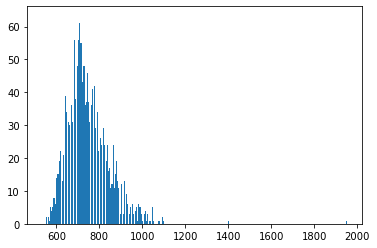

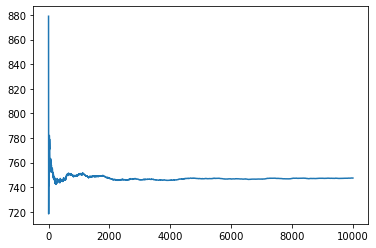

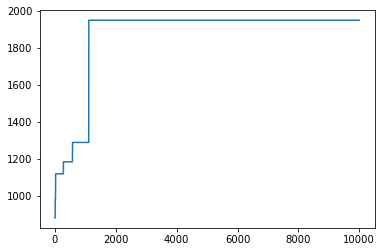

0
(984, array([ 98., 184., 265., ...,   0.,   0.,   0.]))
1
(1059, array([ 79., 181., 280., ...,   0.,   0.,   0.]))
2
(1021, array([94., 94., 94., ...,  0.,  0.,  0.]))
3
(826, array([ 95., 186., 186., ...,   0.,   0.,   0.]))
4
(1024, array([ 87., 168., 168., ...,   0.,   0.,   0.]))
5
(1198, array([ 80., 167., 252., ...,   0.,   0.,   0.]))
6
(914, array([ 93.,  93., 183., ...,   0.,   0.,   0.]))
7
(1177, array([ 88., 182., 283., ...,   0.,   0.,   0.]))
8
(1151, array([ 95., 182., 182., ...,   0.,   0.,   0.]))
9
(1059, array([ 94., 179., 278., ...,   0.,   0.,   0.]))
10
(1054, array([104., 104., 200., ...,   0.,   0.,   0.]))
11
(1160, array([114., 114., 219., ...,   0.,   0.,   0.]))
12
(1514, array([ 80., 184., 297., ...,   0.,   0.,   0.]))
13
(954, array([ 93., 193., 293., ...,   0.,   0.,   0.]))
14
(1157, array([ 90., 190., 293., ...,   0.,   0.,   0.]))
15
(1031, array([115., 212., 296., ...,   0.,   0.,   0.]))
16
(1208, array([106., 204., 309., ...,   0.,   0.,   0.]))


(1068, array([110., 110., 205., ...,   0.,   0.,   0.]))
140
(1090, array([ 92., 186., 281., ...,   0.,   0.,   0.]))
141
(1270, array([ 95., 182., 267., ...,   0.,   0.,   0.]))
142
(1277, array([ 89., 176., 176., ...,   0.,   0.,   0.]))
143
(1182, array([ 96.,  96., 188., ...,   0.,   0.,   0.]))
144
(926, array([ 98., 193., 293., ...,   0.,   0.,   0.]))
145
(959, array([107., 201., 284., ...,   0.,   0.,   0.]))
146
(1108, array([ 87., 171., 271., ...,   0.,   0.,   0.]))
147
(916, array([ 82., 182., 182., ...,   0.,   0.,   0.]))
148
(1078, array([ 98., 193., 279., ...,   0.,   0.,   0.]))
149
(1039, array([ 89., 159., 253., ...,   0.,   0.,   0.]))
150
(1181, array([ 87., 173., 173., ...,   0.,   0.,   0.]))
151
(1260, array([104., 104., 198., ...,   0.,   0.,   0.]))
152
(962, array([ 98.,  98., 180., ...,   0.,   0.,   0.]))
153
(1077, array([ 97., 205., 304., ...,   0.,   0.,   0.]))
154
(1000, array([ 96.,  96., 191., ...,   0.,   0.,   0.]))
155
(962, array([ 91., 161., 161

(1050, array([85., 85., 85., ...,  0.,  0.,  0.]))
276
(847, array([ 87.,  87., 184., ...,   0.,   0.,   0.]))
277
(975, array([ 85., 184., 284., ...,   0.,   0.,   0.]))
278
(1204, array([107., 107., 107., ...,   0.,   0.,   0.]))
279
(904, array([108., 210., 210., ...,   0.,   0.,   0.]))
280
(878, array([ 77., 163., 163., ...,   0.,   0.,   0.]))
281
(1249, array([107., 196., 293., ...,   0.,   0.,   0.]))
282
(1308, array([101., 198., 290., ...,   0.,   0.,   0.]))
283
(951, array([103., 169., 276., ...,   0.,   0.,   0.]))
284
(912, array([103., 197., 280., ...,   0.,   0.,   0.]))
285
(1187, array([82., 82., 82., ...,  0.,  0.,  0.]))
286
(1276, array([78., 78., 78., ...,  0.,  0.,  0.]))
287
(1429, array([102., 203., 294., ...,   0.,   0.,   0.]))
288
(993, array([114., 114., 114., ...,   0.,   0.,   0.]))
289
(912, array([ 99., 202., 293., ...,   0.,   0.,   0.]))
290
(1110, array([ 85., 175., 270., ...,   0.,   0.,   0.]))
291
(1003, array([ 86.,  86., 165., ...,   0.,   0.,  

(1254, array([ 91., 179., 264., ...,   0.,   0.,   0.]))
413
(1206, array([ 85., 173., 267., ...,   0.,   0.,   0.]))
414
(1027, array([105., 105., 105., ...,   0.,   0.,   0.]))
415
(985, array([119., 209., 277., ...,   0.,   0.,   0.]))
416
(1377, array([105., 105., 201., ...,   0.,   0.,   0.]))
417
(916, array([ 86., 173., 276., ...,   0.,   0.,   0.]))
418
(1053, array([ 90., 199., 314., ...,   0.,   0.,   0.]))
419
(1043, array([114., 199., 302., ...,   0.,   0.,   0.]))
420
(1016, array([ 86., 181., 274., ...,   0.,   0.,   0.]))
421
(975, array([85., 85., 85., ...,  0.,  0.,  0.]))
422
(1289, array([ 78., 165., 165., ...,   0.,   0.,   0.]))
423
(1096, array([104., 196., 303., ...,   0.,   0.,   0.]))
424
(1228, array([111., 205., 291., ...,   0.,   0.,   0.]))
425
(965, array([107., 194., 194., ...,   0.,   0.,   0.]))
426
(934, array([105., 190., 292., ...,   0.,   0.,   0.]))
427
(860, array([ 99.,  99., 187., ...,   0.,   0.,   0.]))
428
(979, array([ 83., 164., 164., ..., 

(1109, array([ 97.,  97., 173., ...,   0.,   0.,   0.]))
550
(1064, array([95., 95., 95., ...,  0.,  0.,  0.]))
551
(1272, array([103., 210., 300., ...,   0.,   0.,   0.]))
552
(1197, array([101., 199., 199., ...,   0.,   0.,   0.]))
553
(1073, array([66., 66., 66., ...,  0.,  0.,  0.]))
554
(1017, array([ 98., 196., 299., ...,   0.,   0.,   0.]))
555
(1074, array([ 79., 166., 254., ...,   0.,   0.,   0.]))
556
(983, array([103., 189., 272., ...,   0.,   0.,   0.]))
557
(1286, array([109., 109., 214., ...,   0.,   0.,   0.]))
558
(1165, array([88., 88., 88., ...,  0.,  0.,  0.]))
559
(1000, array([ 91., 170., 261., ...,   0.,   0.,   0.]))
560
(1137, array([ 98., 180., 271., ...,   0.,   0.,   0.]))
561
(1158, array([100., 189., 272., ...,   0.,   0.,   0.]))
562
(986, array([ 81., 169., 254., ...,   0.,   0.,   0.]))
563
(1268, array([79., 79., 79., ...,  0.,  0.,  0.]))
564
(1116, array([101., 101., 101., ...,   0.,   0.,   0.]))
565
(1165, array([105., 195., 317., ...,   0.,   0.,  

(840, array([111., 196., 295., ...,   0.,   0.,   0.]))
687
(1336, array([ 93., 178., 263., ...,   0.,   0.,   0.]))
688
(1123, array([108., 186., 284., ...,   0.,   0.,   0.]))
689
(1075, array([ 98.,  98., 179., ...,   0.,   0.,   0.]))
690
(907, array([ 87.,  87., 168., ...,   0.,   0.,   0.]))
691
(896, array([105., 189., 283., ...,   0.,   0.,   0.]))
692
(1169, array([ 85., 189., 285., ...,   0.,   0.,   0.]))
693
(911, array([ 98., 204., 289., ...,   0.,   0.,   0.]))
694
(969, array([ 98.,  98., 186., ...,   0.,   0.,   0.]))
695
(970, array([ 85., 170., 256., ...,   0.,   0.,   0.]))
696
(1027, array([ 97., 192., 283., ...,   0.,   0.,   0.]))
697
(891, array([89., 89., 89., ...,  0.,  0.,  0.]))
698
(1101, array([101., 180., 266., ...,   0.,   0.,   0.]))
699
(953, array([86., 86., 86., ...,  0.,  0.,  0.]))
700
(1150, array([ 86.,  86., 171., ...,   0.,   0.,   0.]))
701
(1141, array([89., 89., 89., ...,  0.,  0.,  0.]))
702
(1153, array([ 90., 183., 271., ...,   0.,   0.,  

(1030, array([ 85., 169., 256., ...,   0.,   0.,   0.]))
824
(948, array([ 76., 176., 274., ...,   0.,   0.,   0.]))
825
(1114, array([ 99., 187., 278., ...,   0.,   0.,   0.]))
826
(1018, array([ 96.,  96., 193., ...,   0.,   0.,   0.]))
827
(1741, array([92., 92., 92., ...,  0.,  0.,  0.]))
828
(1050, array([ 83., 186., 259., ...,   0.,   0.,   0.]))
829
(1040, array([ 76.,  76., 168., ...,   0.,   0.,   0.]))
830
(912, array([ 75., 189., 290., ...,   0.,   0.,   0.]))
831
(900, array([ 88., 180., 282., ...,   0.,   0.,   0.]))
832
(1030, array([ 93., 183., 283., ...,   0.,   0.,   0.]))
833
(1020, array([ 98., 179., 268., ...,   0.,   0.,   0.]))
834
(1347, array([119., 119., 119., ...,   0.,   0.,   0.]))
835
(926, array([113., 197., 197., ...,   0.,   0.,   0.]))
836
(1064, array([ 80., 160., 253., ...,   0.,   0.,   0.]))
837
(1060, array([116., 215., 301., ...,   0.,   0.,   0.]))
838
(1181, array([107., 107., 107., ...,   0.,   0.,   0.]))
839
(1035, array([ 90.,  90., 193., ..

(1131, array([ 97.,  97., 187., ...,   0.,   0.,   0.]))
960
(874, array([ 80., 152., 152., ...,   0.,   0.,   0.]))
961
(1070, array([ 89., 197., 197., ...,   0.,   0.,   0.]))
962
(1042, array([ 97., 186., 280., ...,   0.,   0.,   0.]))
963
(942, array([ 76., 156., 241., ...,   0.,   0.,   0.]))
964
(931, array([ 97., 199., 292., ...,   0.,   0.,   0.]))
965
(1372, array([ 93.,  93., 190., ...,   0.,   0.,   0.]))
966
(1116, array([ 89.,  89., 173., ...,   0.,   0.,   0.]))
967
(1081, array([ 97.,  97., 181., ...,   0.,   0.,   0.]))
968
(971, array([121., 216., 322., ...,   0.,   0.,   0.]))
969
(1148, array([ 79., 182., 267., ...,   0.,   0.,   0.]))
970
(960, array([ 92., 179., 254., ...,   0.,   0.,   0.]))
971
(922, array([ 95.,  95., 213., ...,   0.,   0.,   0.]))
972
(1055, array([108., 217., 298., ...,   0.,   0.,   0.]))
973
(1310, array([110., 200., 200., ...,   0.,   0.,   0.]))
974
(1040, array([ 85., 175., 272., ...,   0.,   0.,   0.]))
975
(980, array([ 90.,  90., 169.,

(877, array([ 96.,  96., 182., ...,   0.,   0.,   0.]))
1095
(918, array([109., 109., 109., ...,   0.,   0.,   0.]))
1096
(965, array([102., 176., 270., ...,   0.,   0.,   0.]))
1097
(894, array([ 62., 144., 230., ...,   0.,   0.,   0.]))
1098
(1068, array([ 79.,  79., 169., ...,   0.,   0.,   0.]))
1099
(1046, array([ 99., 176., 252., ...,   0.,   0.,   0.]))
1100
(831, array([94., 94., 94., ...,  0.,  0.,  0.]))
1101
(956, array([ 81., 172., 272., ...,   0.,   0.,   0.]))
1102
(920, array([ 91., 194., 269., ...,   0.,   0.,   0.]))
1103
(1085, array([106., 206., 285., ...,   0.,   0.,   0.]))
1104
(1100, array([77., 77., 77., ...,  0.,  0.,  0.]))
1105
(1223, array([93., 93., 93., ...,  0.,  0.,  0.]))
1106
(1148, array([ 86., 157., 243., ...,   0.,   0.,   0.]))
1107
(1056, array([ 95., 185., 185., ...,   0.,   0.,   0.]))
1108
(1133, array([ 93., 201., 286., ...,   0.,   0.,   0.]))
1109
(1077, array([ 92., 168., 252., ...,   0.,   0.,   0.]))
1110
(945, array([ 93., 173., 278., ..

(1158, array([ 96., 185., 276., ...,   0.,   0.,   0.]))
1230
(1003, array([101., 197., 292., ...,   0.,   0.,   0.]))
1231
(1044, array([ 82., 190., 190., ...,   0.,   0.,   0.]))
1232
(1127, array([103., 103., 103., ...,   0.,   0.,   0.]))
1233
(1096, array([ 91., 180., 255., ...,   0.,   0.,   0.]))
1234
(1107, array([ 90., 191., 283., ...,   0.,   0.,   0.]))
1235
(1088, array([102., 102., 196., ...,   0.,   0.,   0.]))
1236
(970, array([ 99., 197., 292., ...,   0.,   0.,   0.]))
1237
(889, array([ 81., 191., 291., ...,   0.,   0.,   0.]))
1238
(906, array([88., 88., 88., ...,  0.,  0.,  0.]))
1239
(902, array([83., 83., 83., ...,  0.,  0.,  0.]))
1240
(1006, array([83., 83., 83., ...,  0.,  0.,  0.]))
1241
(1052, array([ 86., 183., 288., ...,   0.,   0.,   0.]))
1242
(1005, array([ 83., 171., 268., ...,   0.,   0.,   0.]))
1243
(1012, array([ 86.,  86., 190., ...,   0.,   0.,   0.]))
1244
(1039, array([112., 202., 302., ...,   0.,   0.,   0.]))
1245
(1028, array([107., 204., 204.

(1079, array([112., 112., 112., ...,   0.,   0.,   0.]))
1365
(849, array([ 88., 172., 172., ...,   0.,   0.,   0.]))
1366
(1094, array([84., 84., 84., ...,  0.,  0.,  0.]))
1367
(876, array([ 93., 180., 257., ...,   0.,   0.,   0.]))
1368
(1010, array([ 93., 185., 270., ...,   0.,   0.,   0.]))
1369
(823, array([105., 105., 196., ...,   0.,   0.,   0.]))
1370
(1140, array([100., 100., 100., ...,   0.,   0.,   0.]))
1371
(890, array([ 88., 187., 258., ...,   0.,   0.,   0.]))
1372
(980, array([106., 199., 293., ...,   0.,   0.,   0.]))
1373
(1189, array([ 90., 194., 282., ...,   0.,   0.,   0.]))
1374
(1080, array([ 89., 177., 267., ...,   0.,   0.,   0.]))
1375
(909, array([ 85.,  85., 173., ...,   0.,   0.,   0.]))
1376
(890, array([ 92., 198., 290., ...,   0.,   0.,   0.]))
1377
(1044, array([ 88., 195., 281., ...,   0.,   0.,   0.]))
1378
(1353, array([ 95., 181., 274., ...,   0.,   0.,   0.]))
1379
(1249, array([107., 107., 201., ...,   0.,   0.,   0.]))
1380
(1237, array([ 89., 1

(901, array([104., 192., 274., ...,   0.,   0.,   0.]))
1499
(1071, array([119., 214., 306., ...,   0.,   0.,   0.]))
1500
(911, array([ 94., 188., 272., ...,   0.,   0.,   0.]))
1501
(973, array([ 88.,  88., 180., ...,   0.,   0.,   0.]))
1502
(1163, array([ 72., 146., 224., ...,   0.,   0.,   0.]))
1503
(1143, array([ 87., 178., 272., ...,   0.,   0.,   0.]))
1504
(1152, array([ 84., 188., 188., ...,   0.,   0.,   0.]))
1505
(983, array([ 77., 161., 252., ...,   0.,   0.,   0.]))
1506
(983, array([ 80., 186., 186., ...,   0.,   0.,   0.]))
1507
(860, array([ 84.,  84., 173., ...,   0.,   0.,   0.]))
1508
(1074, array([ 87., 183., 262., ...,   0.,   0.,   0.]))
1509
(918, array([ 91., 196., 278., ...,   0.,   0.,   0.]))
1510
(1020, array([95., 95., 95., ...,  0.,  0.,  0.]))
1511
(1379, array([109., 221., 302., ...,   0.,   0.,   0.]))
1512
(1126, array([81., 81., 81., ...,  0.,  0.,  0.]))
1513
(810, array([102., 190., 269., ...,   0.,   0.,   0.]))
1514
(962, array([ 93., 196., 267

(1061, array([102., 102., 102., ...,   0.,   0.,   0.]))
1633
(1006, array([ 89., 185., 185., ...,   0.,   0.,   0.]))
1634
(1235, array([ 86., 197., 197., ...,   0.,   0.,   0.]))
1635
(1004, array([ 80., 184., 281., ...,   0.,   0.,   0.]))
1636
(902, array([ 95., 195., 281., ...,   0.,   0.,   0.]))
1637
(905, array([ 87., 175., 261., ...,   0.,   0.,   0.]))
1638
(1135, array([102., 189., 189., ...,   0.,   0.,   0.]))
1639
(912, array([75., 75., 75., ...,  0.,  0.,  0.]))
1640
(952, array([ 96.,  96., 189., ...,   0.,   0.,   0.]))
1641
(924, array([ 91., 180., 180., ...,   0.,   0.,   0.]))
1642
(1583, array([ 99., 183., 183., ...,   0.,   0.,   0.]))
1643
(859, array([ 91., 189., 283., ...,   0.,   0.,   0.]))
1644
(932, array([ 79., 164., 262., ...,   0.,   0.,   0.]))
1645
(1025, array([71., 71., 71., ...,  0.,  0.,  0.]))
1646
(1035, array([ 94.,  94., 185., ...,   0.,   0.,   0.]))
1647
(927, array([ 93., 187., 263., ...,   0.,   0.,   0.]))
1648
(1133, array([ 92., 171., 25

(1016, array([94., 94., 94., ...,  0.,  0.,  0.]))
1768
(1035, array([ 98.,  98., 187., ...,   0.,   0.,   0.]))
1769
(1056, array([ 89.,  89., 180., ...,   0.,   0.,   0.]))
1770
(1127, array([100., 187., 269., ...,   0.,   0.,   0.]))
1771
(1014, array([ 87., 182., 182., ...,   0.,   0.,   0.]))
1772
(959, array([ 98.,  98., 189., ...,   0.,   0.,   0.]))
1773
(1222, array([ 77., 177., 280., ...,   0.,   0.,   0.]))
1774
(931, array([ 98.,  98., 186., ...,   0.,   0.,   0.]))
1775
(963, array([ 96.,  96., 176., ...,   0.,   0.,   0.]))
1776
(1290, array([ 95., 189., 284., ...,   0.,   0.,   0.]))
1777
(958, array([ 93., 180., 270., ...,   0.,   0.,   0.]))
1778
(993, array([ 90.,  90., 202., ...,   0.,   0.,   0.]))
1779
(1179, array([ 84., 183., 183., ...,   0.,   0.,   0.]))
1780
(1544, array([ 94., 186., 289., ...,   0.,   0.,   0.]))
1781
(1107, array([100., 174., 261., ...,   0.,   0.,   0.]))
1782
(940, array([ 91.,  91., 173., ...,   0.,   0.,   0.]))
1783
(1088, array([ 95., 

(936, array([ 84., 178., 281., ...,   0.,   0.,   0.]))
1903
(1022, array([ 98.,  98., 200., ...,   0.,   0.,   0.]))
1904
(855, array([115., 115., 208., ...,   0.,   0.,   0.]))
1905
(1143, array([110., 188., 276., ...,   0.,   0.,   0.]))
1906
(981, array([104., 207., 286., ...,   0.,   0.,   0.]))
1907
(1078, array([ 93.,  93., 176., ...,   0.,   0.,   0.]))
1908
(1052, array([97., 97., 97., ...,  0.,  0.,  0.]))
1909
(1141, array([ 97., 191., 289., ...,   0.,   0.,   0.]))
1910
(976, array([ 85., 165., 257., ...,   0.,   0.,   0.]))
1911
(1040, array([ 77., 183., 282., ...,   0.,   0.,   0.]))
1912
(1123, array([ 79., 160., 239., ...,   0.,   0.,   0.]))
1913
(1193, array([100., 180., 268., ...,   0.,   0.,   0.]))
1914
(1116, array([92., 92., 92., ...,  0.,  0.,  0.]))
1915
(920, array([103., 201., 278., ...,   0.,   0.,   0.]))
1916
(1066, array([ 86., 180., 272., ...,   0.,   0.,   0.]))
1917
(939, array([ 93., 165., 242., ...,   0.,   0.,   0.]))
1918
(974, array([ 87., 175., 2

(1047, array([ 98.,  98., 184., ...,   0.,   0.,   0.]))
2038
(918, array([ 99., 196., 196., ...,   0.,   0.,   0.]))
2039
(1093, array([92., 92., 92., ...,  0.,  0.,  0.]))
2040
(889, array([96., 96., 96., ...,  0.,  0.,  0.]))
2041
(945, array([ 91., 196., 285., ...,   0.,   0.,   0.]))
2042
(1040, array([ 94., 195., 276., ...,   0.,   0.,   0.]))
2043
(889, array([100., 191., 285., ...,   0.,   0.,   0.]))
2044
(927, array([ 91., 180., 277., ...,   0.,   0.,   0.]))
2045
(858, array([ 96., 172., 255., ...,   0.,   0.,   0.]))
2046
(881, array([102., 195., 271., ...,   0.,   0.,   0.]))
2047
(869, array([106., 193., 272., ...,   0.,   0.,   0.]))
2048
(1313, array([107., 107., 207., ...,   0.,   0.,   0.]))
2049
(1002, array([109., 189., 297., ...,   0.,   0.,   0.]))
2050
(923, array([100., 189., 269., ...,   0.,   0.,   0.]))
2051
(935, array([ 94.,  94., 188., ...,   0.,   0.,   0.]))
2052
(909, array([ 95., 177., 177., ...,   0.,   0.,   0.]))
2053
(1022, array([86., 86., 86., ..

(1097, array([ 91., 175., 275., ...,   0.,   0.,   0.]))
2173
(958, array([105., 210., 315., ...,   0.,   0.,   0.]))
2174
(1158, array([ 80., 171., 171., ...,   0.,   0.,   0.]))
2175
(933, array([ 89., 193., 269., ...,   0.,   0.,   0.]))
2176
(1073, array([102., 206., 296., ...,   0.,   0.,   0.]))
2177
(1187, array([106., 106., 192., ...,   0.,   0.,   0.]))
2178
(876, array([96., 96., 96., ...,  0.,  0.,  0.]))
2179
(1151, array([ 96., 191., 282., ...,   0.,   0.,   0.]))
2180
(901, array([ 98., 192., 272., ...,   0.,   0.,   0.]))
2181
(946, array([105., 187., 272., ...,   0.,   0.,   0.]))
2182
(1045, array([101., 101., 190., ...,   0.,   0.,   0.]))
2183
(967, array([ 92., 175., 270., ...,   0.,   0.,   0.]))
2184
(993, array([ 90., 195., 276., ...,   0.,   0.,   0.]))
2185
(952, array([90., 90., 90., ...,  0.,  0.,  0.]))
2186
(902, array([ 79., 169., 169., ...,   0.,   0.,   0.]))
2187
(992, array([ 92., 195., 195., ...,   0.,   0.,   0.]))
2188
(987, array([ 99., 190., 290.,

(858, array([ 80.,  80., 162., ...,   0.,   0.,   0.]))
2307
(995, array([104., 193., 283., ...,   0.,   0.,   0.]))
2308
(1158, array([103., 199., 279., ...,   0.,   0.,   0.]))
2309
(1084, array([ 93., 206., 298., ...,   0.,   0.,   0.]))
2310
(974, array([104., 104., 104., ...,   0.,   0.,   0.]))
2311
(1293, array([ 93., 179., 267., ...,   0.,   0.,   0.]))
2312
(970, array([ 91.,  91., 176., ...,   0.,   0.,   0.]))
2313
(1346, array([ 98.,  98., 181., ...,   0.,   0.,   0.]))
2314
(1438, array([107., 107., 107., ...,   0.,   0.,   0.]))
2315
(1041, array([87., 87., 87., ...,  0.,  0.,  0.]))
2316
(1029, array([ 94., 190., 305., ...,   0.,   0.,   0.]))
2317
(1204, array([112., 231., 330., ...,   0.,   0.,   0.]))
2318
(992, array([113., 205., 292., ...,   0.,   0.,   0.]))
2319
(990, array([83., 83., 83., ...,  0.,  0.,  0.]))
2320
(918, array([105., 105., 213., ...,   0.,   0.,   0.]))
2321
(1134, array([102., 102., 102., ...,   0.,   0.,   0.]))
2322
(1047, array([ 82.,  82., 1

(1070, array([ 92., 177., 276., ...,   0.,   0.,   0.]))
2441
(1016, array([ 77., 180., 259., ...,   0.,   0.,   0.]))
2442
(988, array([82., 82., 82., ...,  0.,  0.,  0.]))
2443
(965, array([ 89., 183., 183., ...,   0.,   0.,   0.]))
2444
(987, array([112., 213., 304., ...,   0.,   0.,   0.]))
2445
(1052, array([ 88.,  88., 182., ...,   0.,   0.,   0.]))
2446
(857, array([100., 100., 192., ...,   0.,   0.,   0.]))
2447
(993, array([ 91., 171., 262., ...,   0.,   0.,   0.]))
2448
(1156, array([ 95., 183., 265., ...,   0.,   0.,   0.]))
2449
(1109, array([88., 88., 88., ...,  0.,  0.,  0.]))
2450
(1340, array([98., 98., 98., ...,  0.,  0.,  0.]))
2451
(1015, array([ 84., 196., 291., ...,   0.,   0.,   0.]))
2452
(1042, array([ 97.,  97., 185., ...,   0.,   0.,   0.]))
2453
(881, array([81., 81., 81., ...,  0.,  0.,  0.]))
2454
(1004, array([81., 81., 81., ...,  0.,  0.,  0.]))
2455
(904, array([ 97., 188., 293., ...,   0.,   0.,   0.]))
2456
(961, array([89., 89., 89., ...,  0.,  0.,  0

(887, array([ 98., 210., 295., ...,   0.,   0.,   0.]))
2575
(991, array([ 99., 199., 289., ...,   0.,   0.,   0.]))
2576
(950, array([77., 77., 77., ...,  0.,  0.,  0.]))
2577
(917, array([ 96.,  96., 182., ...,   0.,   0.,   0.]))
2578
(1095, array([ 92.,  92., 185., ...,   0.,   0.,   0.]))
2579
(1038, array([ 75.,  75., 159., ...,   0.,   0.,   0.]))
2580
(1299, array([ 87., 184., 275., ...,   0.,   0.,   0.]))
2581
(1082, array([111., 111., 206., ...,   0.,   0.,   0.]))
2582
(1204, array([ 90.,  90., 199., ...,   0.,   0.,   0.]))
2583
(980, array([ 93.,  93., 199., ...,   0.,   0.,   0.]))
2584
(983, array([ 85., 189., 292., ...,   0.,   0.,   0.]))
2585
(1177, array([ 73., 169., 169., ...,   0.,   0.,   0.]))
2586
(943, array([ 93.,  93., 181., ...,   0.,   0.,   0.]))
2587
(1306, array([101., 203., 291., ...,   0.,   0.,   0.]))
2588
(1139, array([ 91., 202., 277., ...,   0.,   0.,   0.]))
2589
(1032, array([ 99., 202., 290., ...,   0.,   0.,   0.]))
2590
(975, array([ 94., 20

(931, array([ 95., 190., 190., ...,   0.,   0.,   0.]))
2709
(1116, array([ 80., 181., 257., ...,   0.,   0.,   0.]))
2710
(1030, array([88., 88., 88., ...,  0.,  0.,  0.]))
2711
(1155, array([87., 87., 87., ...,  0.,  0.,  0.]))
2712
(1104, array([ 98.,  98., 177., ...,   0.,   0.,   0.]))
2713
(1003, array([103., 192., 277., ...,   0.,   0.,   0.]))
2714
(970, array([113., 113., 206., ...,   0.,   0.,   0.]))
2715
(920, array([ 83., 165., 165., ...,   0.,   0.,   0.]))
2716
(1191, array([97., 97., 97., ...,  0.,  0.,  0.]))
2717
(968, array([106., 190., 284., ...,   0.,   0.,   0.]))
2718
(1099, array([ 98., 194., 194., ...,   0.,   0.,   0.]))
2719
(1032, array([ 96., 178., 266., ...,   0.,   0.,   0.]))
2720
(1020, array([ 99.,  99., 185., ...,   0.,   0.,   0.]))
2721
(1193, array([ 96., 188., 277., ...,   0.,   0.,   0.]))
2722
(1034, array([ 98.,  98., 200., ...,   0.,   0.,   0.]))
2723
(973, array([ 88., 185., 268., ...,   0.,   0.,   0.]))
2724
(983, array([91., 91., 91., ...

(890, array([100., 200., 273., ...,   0.,   0.,   0.]))
2844
(1249, array([106., 106., 106., ...,   0.,   0.,   0.]))
2845
(1158, array([ 86.,  86., 172., ...,   0.,   0.,   0.]))
2846
(856, array([ 85., 179., 279., ...,   0.,   0.,   0.]))
2847
(904, array([ 82., 169., 261., ...,   0.,   0.,   0.]))
2848
(1468, array([ 82.,  82., 167., ...,   0.,   0.,   0.]))
2849
(992, array([101., 101., 101., ...,   0.,   0.,   0.]))
2850
(826, array([92., 92., 92., ...,  0.,  0.,  0.]))
2851
(922, array([101., 194., 194., ...,   0.,   0.,   0.]))
2852
(1101, array([ 90., 194., 274., ...,   0.,   0.,   0.]))
2853
(1006, array([101., 101., 101., ...,   0.,   0.,   0.]))
2854
(1183, array([ 87., 179., 264., ...,   0.,   0.,   0.]))
2855
(955, array([110., 208., 294., ...,   0.,   0.,   0.]))
2856
(1272, array([ 98., 194., 282., ...,   0.,   0.,   0.]))
2857
(1393, array([ 91.,  91., 204., ...,   0.,   0.,   0.]))
2858
(805, array([105., 205., 298., ...,   0.,   0.,   0.]))
2859
(1063, array([ 93.,  9

(1353, array([ 96.,  96., 196., ...,   0.,   0.,   0.]))
2978
(1201, array([ 84., 194., 194., ...,   0.,   0.,   0.]))
2979
(1079, array([76., 76., 76., ...,  0.,  0.,  0.]))
2980
(1204, array([ 86.,  86., 186., ...,   0.,   0.,   0.]))
2981
(981, array([ 90., 191., 290., ...,   0.,   0.,   0.]))
2982
(1138, array([101., 206., 311., ...,   0.,   0.,   0.]))
2983
(1084, array([88., 88., 88., ...,  0.,  0.,  0.]))
2984
(962, array([111., 212., 310., ...,   0.,   0.,   0.]))
2985
(1043, array([ 98., 202., 291., ...,   0.,   0.,   0.]))
2986
(932, array([ 87., 187., 286., ...,   0.,   0.,   0.]))
2987
(977, array([ 87., 188., 284., ...,   0.,   0.,   0.]))
2988
(1283, array([ 79., 164., 255., ...,   0.,   0.,   0.]))
2989
(925, array([ 94.,  94., 188., ...,   0.,   0.,   0.]))
2990
(1140, array([ 81., 170., 277., ...,   0.,   0.,   0.]))
2991
(918, array([ 89., 179., 288., ...,   0.,   0.,   0.]))
2992
(1006, array([100., 196., 292., ...,   0.,   0.,   0.]))
2993
(1338, array([ 95., 208., 

(1156, array([108., 196., 196., ...,   0.,   0.,   0.]))
3112
(941, array([ 85.,  85., 186., ...,   0.,   0.,   0.]))
3113
(998, array([80., 80., 80., ...,  0.,  0.,  0.]))
3114
(1043, array([ 98., 212., 299., ...,   0.,   0.,   0.]))
3115
(1056, array([ 89., 200., 309., ...,   0.,   0.,   0.]))
3116
(1143, array([95., 95., 95., ...,  0.,  0.,  0.]))
3117
(980, array([84., 84., 84., ...,  0.,  0.,  0.]))
3118
(1006, array([99., 99., 99., ...,  0.,  0.,  0.]))
3119
(1123, array([ 91.,  91., 175., ...,   0.,   0.,   0.]))
3120
(898, array([ 85., 171., 171., ...,   0.,   0.,   0.]))
3121
(1084, array([102., 190., 287., ...,   0.,   0.,   0.]))
3122
(1062, array([93., 93., 93., ...,  0.,  0.,  0.]))
3123
(1079, array([ 79., 173., 264., ...,   0.,   0.,   0.]))
3124
(900, array([ 98.,  98., 174., ...,   0.,   0.,   0.]))
3125
(1131, array([ 82., 182., 277., ...,   0.,   0.,   0.]))
3126
(1145, array([ 94., 188., 274., ...,   0.,   0.,   0.]))
3127
(1211, array([ 95., 189., 279., ...,   0., 

(1504, array([97., 97., 97., ...,  0.,  0.,  0.]))
3247
(1042, array([ 81., 178., 178., ...,   0.,   0.,   0.]))
3248
(854, array([112., 203., 308., ...,   0.,   0.,   0.]))
3249
(837, array([110., 110., 201., ...,   0.,   0.,   0.]))
3250
(965, array([ 70., 171., 263., ...,   0.,   0.,   0.]))
3251
(1039, array([ 84., 174., 264., ...,   0.,   0.,   0.]))
3252
(1021, array([104., 104., 188., ...,   0.,   0.,   0.]))
3253
(990, array([ 89., 168., 270., ...,   0.,   0.,   0.]))
3254
(948, array([ 84., 169., 169., ...,   0.,   0.,   0.]))
3255
(1014, array([ 82., 162., 265., ...,   0.,   0.,   0.]))
3256
(1216, array([97., 97., 97., ...,  0.,  0.,  0.]))
3257
(1077, array([89., 89., 89., ...,  0.,  0.,  0.]))
3258
(1108, array([ 98.,  98., 202., ...,   0.,   0.,   0.]))
3259
(1009, array([ 86., 170., 253., ...,   0.,   0.,   0.]))
3260
(908, array([ 93., 189., 283., ...,   0.,   0.,   0.]))
3261
(934, array([ 86., 165., 165., ...,   0.,   0.,   0.]))
3262
(1072, array([101., 192., 300., .

(972, array([ 81., 159., 240., ...,   0.,   0.,   0.]))
3381
(1177, array([106., 106., 197., ...,   0.,   0.,   0.]))
3382
(827, array([91., 91., 91., ...,  0.,  0.,  0.]))
3383
(1299, array([ 91., 188., 278., ...,   0.,   0.,   0.]))
3384
(938, array([106., 193., 193., ...,   0.,   0.,   0.]))
3385
(958, array([86., 86., 86., ...,  0.,  0.,  0.]))
3386
(1019, array([ 91., 187., 279., ...,   0.,   0.,   0.]))
3387
(1064, array([ 95., 199., 199., ...,   0.,   0.,   0.]))
3388
(1133, array([ 98.,  98., 197., ...,   0.,   0.,   0.]))
3389
(1081, array([ 90.,  90., 187., ...,   0.,   0.,   0.]))
3390
(1273, array([ 98.,  98., 192., ...,   0.,   0.,   0.]))
3391
(982, array([ 93.,  93., 172., ...,   0.,   0.,   0.]))
3392
(966, array([ 91., 179., 253., ...,   0.,   0.,   0.]))
3393
(1412, array([103., 207., 308., ...,   0.,   0.,   0.]))
3394
(931, array([ 88.,  88., 188., ...,   0.,   0.,   0.]))
3395
(977, array([ 90., 182., 272., ...,   0.,   0.,   0.]))
3396
(1152, array([80., 80., 80.,

(1207, array([ 97., 197., 291., ...,   0.,   0.,   0.]))
3515
(906, array([82., 82., 82., ...,  0.,  0.,  0.]))
3516
(1003, array([82., 82., 82., ...,  0.,  0.,  0.]))
3517
(940, array([ 86., 167., 261., ...,   0.,   0.,   0.]))
3518
(1147, array([105., 195., 279., ...,   0.,   0.,   0.]))
3519
(1018, array([ 91., 187., 271., ...,   0.,   0.,   0.]))
3520
(1075, array([ 93., 176., 276., ...,   0.,   0.,   0.]))
3521
(1166, array([ 93.,  93., 167., ...,   0.,   0.,   0.]))
3522
(911, array([ 98., 188., 274., ...,   0.,   0.,   0.]))
3523
(1065, array([90., 90., 90., ...,  0.,  0.,  0.]))
3524
(1317, array([99., 99., 99., ...,  0.,  0.,  0.]))
3525
(981, array([85., 85., 85., ...,  0.,  0.,  0.]))
3526
(993, array([106., 201., 290., ...,   0.,   0.,   0.]))
3527
(1399, array([ 98.,  98., 189., ...,   0.,   0.,   0.]))
3528
(945, array([101., 191., 283., ...,   0.,   0.,   0.]))
3529
(1018, array([ 85., 177., 177., ...,   0.,   0.,   0.]))
3530
(1029, array([ 89., 185., 278., ...,   0.,  

(1163, array([ 87.,  87., 180., ...,   0.,   0.,   0.]))
3650
(1232, array([ 96.,  96., 180., ...,   0.,   0.,   0.]))
3651
(1019, array([ 98.,  98., 192., ...,   0.,   0.,   0.]))
3652
(1630, array([100., 100., 210., ...,   0.,   0.,   0.]))
3653
(999, array([ 86., 177., 259., ...,   0.,   0.,   0.]))
3654
(1081, array([ 92., 197., 271., ...,   0.,   0.,   0.]))
3655
(1063, array([ 92.,  92., 189., ...,   0.,   0.,   0.]))
3656
(952, array([ 90., 180., 265., ...,   0.,   0.,   0.]))
3657
(1026, array([101., 198., 273., ...,   0.,   0.,   0.]))
3658
(948, array([ 84.,  84., 160., ...,   0.,   0.,   0.]))
3659
(1099, array([106., 181., 293., ...,   0.,   0.,   0.]))
3660
(1229, array([86., 86., 86., ...,  0.,  0.,  0.]))
3661
(1072, array([ 84., 157., 264., ...,   0.,   0.,   0.]))
3662
(1102, array([ 90., 182., 266., ...,   0.,   0.,   0.]))
3663
(868, array([100., 197., 290., ...,   0.,   0.,   0.]))
3664
(1070, array([ 90., 190., 290., ...,   0.,   0.,   0.]))
3665
(999, array([110.,

(1076, array([117., 117., 207., ...,   0.,   0.,   0.]))
3784
(1038, array([77., 77., 77., ...,  0.,  0.,  0.]))
3785
(1003, array([89., 89., 89., ...,  0.,  0.,  0.]))
3786
(1092, array([ 89.,  89., 173., ...,   0.,   0.,   0.]))
3787
(1121, array([ 87., 184., 264., ...,   0.,   0.,   0.]))
3788
(1004, array([ 90., 190., 190., ...,   0.,   0.,   0.]))
3789
(1068, array([ 95., 176., 256., ...,   0.,   0.,   0.]))
3790
(1104, array([ 98., 194., 194., ...,   0.,   0.,   0.]))
3791
(1051, array([ 89.,  89., 168., ...,   0.,   0.,   0.]))
3792
(992, array([ 94., 181., 181., ...,   0.,   0.,   0.]))
3793
(965, array([ 82., 179., 273., ...,   0.,   0.,   0.]))
3794
(958, array([92., 92., 92., ...,  0.,  0.,  0.]))
3795
(1273, array([ 87., 174., 241., ...,   0.,   0.,   0.]))
3796
(969, array([ 97.,  97., 194., ...,   0.,   0.,   0.]))
3797
(1546, array([ 93., 171., 171., ...,   0.,   0.,   0.]))
3798
(1055, array([ 95., 187., 287., ...,   0.,   0.,   0.]))
3799
(1092, array([ 89., 170., 256.

3918
(1152, array([ 82., 160., 264., ...,   0.,   0.,   0.]))
3919
(935, array([ 86., 181., 263., ...,   0.,   0.,   0.]))
3920
(1137, array([ 92.,  92., 170., ...,   0.,   0.,   0.]))
3921
(1021, array([102., 193., 290., ...,   0.,   0.,   0.]))
3922
(1292, array([104., 104., 202., ...,   0.,   0.,   0.]))
3923
(1099, array([ 98., 201., 291., ...,   0.,   0.,   0.]))
3924
(1076, array([120., 220., 322., ...,   0.,   0.,   0.]))
3925
(1023, array([ 82.,  82., 178., ...,   0.,   0.,   0.]))
3926
(1156, array([ 83., 165., 260., ...,   0.,   0.,   0.]))
3927
(923, array([ 98.,  98., 181., ...,   0.,   0.,   0.]))
3928
(1105, array([ 82.,  82., 166., ...,   0.,   0.,   0.]))
3929
(915, array([ 93.,  93., 202., ...,   0.,   0.,   0.]))
3930
(871, array([105., 203., 203., ...,   0.,   0.,   0.]))
3931
(1002, array([101., 198., 293., ...,   0.,   0.,   0.]))
3932
(1259, array([86., 86., 86., ...,  0.,  0.,  0.]))
3933
(1014, array([ 95.,  95., 182., ...,   0.,   0.,   0.]))
3934
(975, array([

(940, array([93., 93., 93., ...,  0.,  0.,  0.]))
4053
(1178, array([ 77., 171., 274., ...,   0.,   0.,   0.]))
4054
(939, array([ 72., 155., 241., ...,   0.,   0.,   0.]))
4055
(987, array([100., 177., 177., ...,   0.,   0.,   0.]))
4056
(1035, array([103., 103., 191., ...,   0.,   0.,   0.]))
4057
(980, array([ 88., 188., 295., ...,   0.,   0.,   0.]))
4058
(955, array([ 93., 199., 282., ...,   0.,   0.,   0.]))
4059
(903, array([ 95.,  95., 183., ...,   0.,   0.,   0.]))
4060
(1127, array([82., 82., 82., ...,  0.,  0.,  0.]))
4061
(941, array([ 89., 200., 300., ...,   0.,   0.,   0.]))
4062
(885, array([ 97., 199., 282., ...,   0.,   0.,   0.]))
4063
(1281, array([ 91., 210., 317., ...,   0.,   0.,   0.]))
4064
(862, array([102., 211., 211., ...,   0.,   0.,   0.]))
4065
(1021, array([ 86., 178., 282., ...,   0.,   0.,   0.]))
4066
(1096, array([ 86., 181., 181., ...,   0.,   0.,   0.]))
4067
(894, array([ 93., 188., 280., ...,   0.,   0.,   0.]))
4068
(1023, array([ 85.,  85., 204.

4188
(1070, array([100., 177., 261., ...,   0.,   0.,   0.]))
4189
(916, array([104., 181., 181., ...,   0.,   0.,   0.]))
4190
(969, array([102., 102., 194., ...,   0.,   0.,   0.]))
4191
(883, array([ 90., 190., 280., ...,   0.,   0.,   0.]))
4192
(881, array([ 85., 176., 263., ...,   0.,   0.,   0.]))
4193
(873, array([ 96., 187., 276., ...,   0.,   0.,   0.]))
4194
(910, array([99., 99., 99., ...,  0.,  0.,  0.]))
4195
(974, array([96., 96., 96., ...,  0.,  0.,  0.]))
4196
(1116, array([85., 85., 85., ...,  0.,  0.,  0.]))
4197
(1137, array([ 91., 180., 286., ...,   0.,   0.,   0.]))
4198
(1100, array([100., 187., 274., ...,   0.,   0.,   0.]))
4199
(1115, array([ 81.,  81., 178., ...,   0.,   0.,   0.]))
4200
(905, array([ 91., 172., 172., ...,   0.,   0.,   0.]))
4201
(1110, array([ 90., 184., 277., ...,   0.,   0.,   0.]))
4202
(967, array([92., 92., 92., ...,  0.,  0.,  0.]))
4203
(1186, array([ 97.,  97., 178., ...,   0.,   0.,   0.]))
4204
(1128, array([111., 111., 208., ...,

(942, array([ 80.,  80., 172., ...,   0.,   0.,   0.]))
4323
(933, array([106., 198., 275., ...,   0.,   0.,   0.]))
4324
(1125, array([100., 193., 275., ...,   0.,   0.,   0.]))
4325
(944, array([ 98.,  98., 206., ...,   0.,   0.,   0.]))
4326
(1127, array([ 99., 179., 261., ...,   0.,   0.,   0.]))
4327
(949, array([ 78., 175., 175., ...,   0.,   0.,   0.]))
4328
(954, array([ 93., 182., 279., ...,   0.,   0.,   0.]))
4329
(968, array([ 92., 181., 264., ...,   0.,   0.,   0.]))
4330
(1068, array([ 91., 194., 194., ...,   0.,   0.,   0.]))
4331
(1113, array([ 89.,  89., 194., ...,   0.,   0.,   0.]))
4332
(1057, array([100., 188., 278., ...,   0.,   0.,   0.]))
4333
(1105, array([ 83., 181., 293., ...,   0.,   0.,   0.]))
4334
(1337, array([102., 192., 287., ...,   0.,   0.,   0.]))
4335
(1039, array([121., 220., 293., ...,   0.,   0.,   0.]))
4336
(1035, array([ 94., 199., 281., ...,   0.,   0.,   0.]))
4337
(1136, array([105., 202., 298., ...,   0.,   0.,   0.]))
4338
(924, array([9

4457
(1060, array([101., 187., 275., ...,   0.,   0.,   0.]))
4458
(923, array([ 96., 188., 277., ...,   0.,   0.,   0.]))
4459
(1006, array([100., 100., 100., ...,   0.,   0.,   0.]))
4460
(972, array([ 99., 188., 188., ...,   0.,   0.,   0.]))
4461
(1039, array([ 99.,  99., 185., ...,   0.,   0.,   0.]))
4462
(1023, array([100., 192., 192., ...,   0.,   0.,   0.]))
4463
(877, array([ 97., 178., 265., ...,   0.,   0.,   0.]))
4464
(946, array([80., 80., 80., ...,  0.,  0.,  0.]))
4465
(1137, array([ 91.,  91., 201., ...,   0.,   0.,   0.]))
4466
(1207, array([ 98.,  98., 195., ...,   0.,   0.,   0.]))
4467
(886, array([ 93., 183., 263., ...,   0.,   0.,   0.]))
4468
(931, array([ 81., 179., 276., ...,   0.,   0.,   0.]))
4469
(990, array([ 94., 208., 292., ...,   0.,   0.,   0.]))
4470
(1075, array([ 83., 174., 272., ...,   0.,   0.,   0.]))
4471
(958, array([ 90., 194., 277., ...,   0.,   0.,   0.]))
4472
(937, array([ 75., 162., 162., ...,   0.,   0.,   0.]))
4473
(1055, array([ 94.

(1072, array([ 91., 184., 293., ...,   0.,   0.,   0.]))
4592
(1000, array([100., 100., 100., ...,   0.,   0.,   0.]))
4593
(1128, array([ 91., 180., 270., ...,   0.,   0.,   0.]))
4594
(950, array([116., 212., 312., ...,   0.,   0.,   0.]))
4595
(924, array([ 82.,  82., 182., ...,   0.,   0.,   0.]))
4596
(1141, array([ 73.,  73., 156., ...,   0.,   0.,   0.]))
4597
(1062, array([ 81.,  81., 182., ...,   0.,   0.,   0.]))
4598
(982, array([101., 101., 101., ...,   0.,   0.,   0.]))
4599
(936, array([107., 107., 206., ...,   0.,   0.,   0.]))
4600
(1197, array([ 90., 186., 264., ...,   0.,   0.,   0.]))
4601
(1049, array([ 86., 162., 261., ...,   0.,   0.,   0.]))
4602
(958, array([96., 96., 96., ...,  0.,  0.,  0.]))
4603
(958, array([ 94., 191., 191., ...,   0.,   0.,   0.]))
4604
(1301, array([ 87., 181., 277., ...,   0.,   0.,   0.]))
4605
(1042, array([106., 204., 293., ...,   0.,   0.,   0.]))
4606
(918, array([107., 208., 295., ...,   0.,   0.,   0.]))
4607
(901, array([ 87., 16

(824, array([96., 96., 96., ...,  0.,  0.,  0.]))
4726
(1195, array([ 97.,  97., 183., ...,   0.,   0.,   0.]))
4727
(851, array([91., 91., 91., ...,  0.,  0.,  0.]))
4728
(887, array([ 96., 176., 265., ...,   0.,   0.,   0.]))
4729
(915, array([ 94., 185., 265., ...,   0.,   0.,   0.]))
4730
(1129, array([ 87.,  87., 181., ...,   0.,   0.,   0.]))
4731
(1029, array([ 86., 174., 239., ...,   0.,   0.,   0.]))
4732
(919, array([ 99., 188., 280., ...,   0.,   0.,   0.]))
4733
(881, array([ 83., 177., 251., ...,   0.,   0.,   0.]))
4734
(1061, array([ 86.,  86., 182., ...,   0.,   0.,   0.]))
4735
(947, array([ 95., 176., 259., ...,   0.,   0.,   0.]))
4736
(1196, array([ 77., 187., 279., ...,   0.,   0.,   0.]))
4737
(979, array([ 87.,  87., 190., ...,   0.,   0.,   0.]))
4738
(978, array([ 88., 191., 278., ...,   0.,   0.,   0.]))
4739
(844, array([ 90., 183., 276., ...,   0.,   0.,   0.]))
4740
(900, array([ 94.,  94., 173., ...,   0.,   0.,   0.]))
4741
(881, array([ 90.,  90., 182., 

(1023, array([115., 200., 289., ...,   0.,   0.,   0.]))
4861
(1050, array([ 92., 186., 286., ...,   0.,   0.,   0.]))
4862
(1201, array([102., 102., 102., ...,   0.,   0.,   0.]))
4863
(957, array([ 74.,  74., 167., ...,   0.,   0.,   0.]))
4864
(1010, array([ 96., 199., 199., ...,   0.,   0.,   0.]))
4865
(1350, array([111., 111., 213., ...,   0.,   0.,   0.]))
4866
(1053, array([ 93., 179., 276., ...,   0.,   0.,   0.]))
4867
(893, array([ 81., 164., 255., ...,   0.,   0.,   0.]))
4868
(1045, array([ 94.,  94., 196., ...,   0.,   0.,   0.]))
4869
(1004, array([ 91.,  91., 175., ...,   0.,   0.,   0.]))
4870
(1242, array([ 89.,  89., 161., ...,   0.,   0.,   0.]))
4871
(872, array([ 97., 187., 271., ...,   0.,   0.,   0.]))
4872
(1010, array([107., 107., 196., ...,   0.,   0.,   0.]))
4873
(1049, array([103., 201., 298., ...,   0.,   0.,   0.]))
4874
(1244, array([104., 204., 291., ...,   0.,   0.,   0.]))
4875
(1166, array([93., 93., 93., ...,  0.,  0.,  0.]))
4876
(909, array([104.

(1072, array([ 97.,  97., 204., ...,   0.,   0.,   0.]))
4995
(944, array([ 84., 178., 282., ...,   0.,   0.,   0.]))
4996
(1020, array([ 95., 174., 174., ...,   0.,   0.,   0.]))
4997
(1049, array([ 93., 180., 268., ...,   0.,   0.,   0.]))
4998
(1204, array([103., 103., 194., ...,   0.,   0.,   0.]))
4999
(1337, array([ 84., 187., 187., ...,   0.,   0.,   0.]))
5000
(1161, array([ 88., 175., 269., ...,   0.,   0.,   0.]))
5001
(1306, array([94., 94., 94., ...,  0.,  0.,  0.]))
5002
(939, array([104., 104., 207., ...,   0.,   0.,   0.]))
5003
(977, array([ 94., 195., 295., ...,   0.,   0.,   0.]))
5004
(1020, array([ 94., 187., 281., ...,   0.,   0.,   0.]))
5005
(952, array([ 90., 196., 196., ...,   0.,   0.,   0.]))
5006
(1059, array([ 81.,  81., 168., ...,   0.,   0.,   0.]))
5007
(1000, array([ 81.,  81., 175., ...,   0.,   0.,   0.]))
5008
(942, array([ 92.,  92., 171., ...,   0.,   0.,   0.]))
5009
(1104, array([ 73., 156., 235., ...,   0.,   0.,   0.]))
5010
(1072, array([104.,

(1255, array([103., 171., 171., ...,   0.,   0.,   0.]))
5129
(1006, array([101., 201., 296., ...,   0.,   0.,   0.]))
5130
(914, array([107., 107., 200., ...,   0.,   0.,   0.]))
5131
(1039, array([101., 101., 101., ...,   0.,   0.,   0.]))
5132
(1000, array([ 89.,  89., 183., ...,   0.,   0.,   0.]))
5133
(919, array([ 82., 175., 261., ...,   0.,   0.,   0.]))
5134
(978, array([101., 192., 305., ...,   0.,   0.,   0.]))
5135
(1131, array([ 93., 190., 281., ...,   0.,   0.,   0.]))
5136
(1329, array([ 99., 187., 267., ...,   0.,   0.,   0.]))
5137
(1076, array([ 87.,  87., 163., ...,   0.,   0.,   0.]))
5138
(1011, array([83., 83., 83., ...,  0.,  0.,  0.]))
5139
(1009, array([ 97., 178., 267., ...,   0.,   0.,   0.]))
5140
(938, array([77., 77., 77., ...,  0.,  0.,  0.]))
5141
(1034, array([108., 108., 202., ...,   0.,   0.,   0.]))
5142
(1184, array([96., 96., 96., ...,  0.,  0.,  0.]))
5143
(853, array([ 97., 190., 296., ...,   0.,   0.,   0.]))
5144
(985, array([ 85.,  85., 182., 

(951, array([ 78., 174., 257., ...,   0.,   0.,   0.]))
5263
(949, array([100., 180., 267., ...,   0.,   0.,   0.]))
5264
(983, array([ 97., 172., 267., ...,   0.,   0.,   0.]))
5265
(967, array([101., 204., 294., ...,   0.,   0.,   0.]))
5266
(1058, array([107., 107., 202., ...,   0.,   0.,   0.]))
5267
(944, array([ 97., 179., 278., ...,   0.,   0.,   0.]))
5268
(1276, array([76., 76., 76., ...,  0.,  0.,  0.]))
5269
(1172, array([ 95., 190., 279., ...,   0.,   0.,   0.]))
5270
(982, array([ 82.,  82., 177., ...,   0.,   0.,   0.]))
5271
(955, array([ 97., 193., 290., ...,   0.,   0.,   0.]))
5272
(1085, array([ 98., 182., 182., ...,   0.,   0.,   0.]))
5273
(904, array([ 78., 175., 267., ...,   0.,   0.,   0.]))
5274
(1035, array([106., 207., 282., ...,   0.,   0.,   0.]))
5275
(1196, array([ 99.,  99., 200., ...,   0.,   0.,   0.]))
5276
(898, array([102., 188., 283., ...,   0.,   0.,   0.]))
5277
(1184, array([104., 104., 104., ...,   0.,   0.,   0.]))
5278
(928, array([ 91., 202.

(999, array([ 94., 185., 262., ...,   0.,   0.,   0.]))
5397
(935, array([ 97., 194., 278., ...,   0.,   0.,   0.]))
5398
(963, array([ 78., 163., 257., ...,   0.,   0.,   0.]))
5399
(880, array([95., 95., 95., ...,  0.,  0.,  0.]))
5400
(1018, array([90., 90., 90., ...,  0.,  0.,  0.]))
5401
(1301, array([96., 96., 96., ...,  0.,  0.,  0.]))
5402
(1029, array([ 72., 170., 170., ...,   0.,   0.,   0.]))
5403
(923, array([129., 129., 228., ...,   0.,   0.,   0.]))
5404
(1407, array([105., 105., 105., ...,   0.,   0.,   0.]))
5405
(931, array([107., 185., 265., ...,   0.,   0.,   0.]))
5406
(1323, array([ 88., 181., 269., ...,   0.,   0.,   0.]))
5407
(1211, array([ 92.,  92., 193., ...,   0.,   0.,   0.]))
5408
(807, array([107., 208., 296., ...,   0.,   0.,   0.]))
5409
(1107, array([ 86., 181., 259., ...,   0.,   0.,   0.]))
5410
(900, array([ 93.,  93., 183., ...,   0.,   0.,   0.]))
5411
(1068, array([104., 181., 285., ...,   0.,   0.,   0.]))
5412
(876, array([ 99., 198., 279., ...

5531
(1053, array([103., 191., 270., ...,   0.,   0.,   0.]))
5532
(1264, array([ 81.,  81., 172., ...,   0.,   0.,   0.]))
5533
(941, array([88., 88., 88., ...,  0.,  0.,  0.]))
5534
(931, array([ 99., 190., 298., ...,   0.,   0.,   0.]))
5535
(935, array([ 73., 171., 266., ...,   0.,   0.,   0.]))
5536
(909, array([ 99., 187., 262., ...,   0.,   0.,   0.]))
5537
(1124, array([ 95., 191., 296., ...,   0.,   0.,   0.]))
5538
(929, array([ 88., 176., 272., ...,   0.,   0.,   0.]))
5539
(1110, array([103., 201., 290., ...,   0.,   0.,   0.]))
5540
(866, array([ 88., 185., 268., ...,   0.,   0.,   0.]))
5541
(1263, array([ 88., 200., 284., ...,   0.,   0.,   0.]))
5542
(1107, array([ 82.,  82., 191., ...,   0.,   0.,   0.]))
5543
(1020, array([108., 108., 212., ...,   0.,   0.,   0.]))
5544
(854, array([ 98.,  98., 180., ...,   0.,   0.,   0.]))
5545
(911, array([103., 103., 188., ...,   0.,   0.,   0.]))
5546
(1386, array([ 84., 170., 264., ...,   0.,   0.,   0.]))
5547
(938, array([ 93.

(1108, array([108., 193., 193., ...,   0.,   0.,   0.]))
5666
(1170, array([101., 101., 101., ...,   0.,   0.,   0.]))
5667
(1089, array([ 98., 174., 174., ...,   0.,   0.,   0.]))
5668
(974, array([ 87., 191., 282., ...,   0.,   0.,   0.]))
5669
(1068, array([56., 56., 56., ...,  0.,  0.,  0.]))
5670
(933, array([ 90., 182., 265., ...,   0.,   0.,   0.]))
5671
(1319, array([ 98.,  98., 189., ...,   0.,   0.,   0.]))
5672
(1099, array([ 94.,  94., 188., ...,   0.,   0.,   0.]))
5673
(1001, array([ 87.,  87., 175., ...,   0.,   0.,   0.]))
5674
(964, array([ 91., 195., 272., ...,   0.,   0.,   0.]))
5675
(911, array([101., 185., 274., ...,   0.,   0.,   0.]))
5676
(1115, array([ 96., 200., 200., ...,   0.,   0.,   0.]))
5677
(939, array([ 87., 174., 174., ...,   0.,   0.,   0.]))
5678
(1184, array([ 77.,  77., 169., ...,   0.,   0.,   0.]))
5679
(1061, array([ 93., 188., 283., ...,   0.,   0.,   0.]))
5680
(1149, array([102., 206., 323., ...,   0.,   0.,   0.]))
5681
(785, array([113., 

(1022, array([ 96.,  96., 192., ...,   0.,   0.,   0.]))
5800
(1314, array([ 93.,  93., 176., ...,   0.,   0.,   0.]))
5801
(1056, array([ 82.,  82., 182., ...,   0.,   0.,   0.]))
5802
(1074, array([101., 199., 281., ...,   0.,   0.,   0.]))
5803
(1066, array([ 93., 201., 291., ...,   0.,   0.,   0.]))
5804
(1087, array([ 88., 182., 288., ...,   0.,   0.,   0.]))
5805
(1130, array([99., 99., 99., ...,  0.,  0.,  0.]))
5806
(1146, array([114., 210., 298., ...,   0.,   0.,   0.]))
5807
(1023, array([114., 192., 295., ...,   0.,   0.,   0.]))
5808
(942, array([106., 194., 281., ...,   0.,   0.,   0.]))
5809
(934, array([ 90., 190., 293., ...,   0.,   0.,   0.]))
5810
(991, array([ 81., 172., 254., ...,   0.,   0.,   0.]))
5811
(1021, array([ 89.,  89., 189., ...,   0.,   0.,   0.]))
5812
(919, array([100., 100., 100., ...,   0.,   0.,   0.]))
5813
(994, array([ 82.,  82., 182., ...,   0.,   0.,   0.]))
5814
(987, array([ 90., 173., 269., ...,   0.,   0.,   0.]))
5815
(1122, array([ 77., 

(1106, array([111., 200., 200., ...,   0.,   0.,   0.]))
5934
(1019, array([ 85., 186., 276., ...,   0.,   0.,   0.]))
5935
(1137, array([ 89., 175., 275., ...,   0.,   0.,   0.]))
5936
(981, array([84., 84., 84., ...,  0.,  0.,  0.]))
5937
(1098, array([ 94., 191., 298., ...,   0.,   0.,   0.]))
5938
(830, array([ 95.,  95., 181., ...,   0.,   0.,   0.]))
5939
(972, array([100., 100., 100., ...,   0.,   0.,   0.]))
5940
(923, array([ 84.,  84., 186., ...,   0.,   0.,   0.]))
5941
(1464, array([104., 104., 104., ...,   0.,   0.,   0.]))
5942
(918, array([ 90., 189., 293., ...,   0.,   0.,   0.]))
5943
(999, array([ 95., 181., 278., ...,   0.,   0.,   0.]))
5944
(1126, array([ 79., 168., 168., ...,   0.,   0.,   0.]))
5945
(1157, array([ 90., 187., 285., ...,   0.,   0.,   0.]))
5946
(989, array([ 84., 178., 259., ...,   0.,   0.,   0.]))
5947
(1143, array([ 87., 175., 283., ...,   0.,   0.,   0.]))
5948
(790, array([ 94., 190., 282., ...,   0.,   0.,   0.]))
5949
(1072, array([105., 19

(1062, array([100., 205., 293., ...,   0.,   0.,   0.]))
6068
(1049, array([ 87.,  87., 189., ...,   0.,   0.,   0.]))
6069
(1023, array([117., 203., 291., ...,   0.,   0.,   0.]))
6070
(1265, array([96., 96., 96., ...,  0.,  0.,  0.]))
6071
(1085, array([ 95.,  95., 197., ...,   0.,   0.,   0.]))
6072
(1209, array([96., 96., 96., ...,  0.,  0.,  0.]))
6073
(996, array([101., 176., 254., ...,   0.,   0.,   0.]))
6074
(1208, array([89., 89., 89., ...,  0.,  0.,  0.]))
6075
(976, array([ 95.,  95., 188., ...,   0.,   0.,   0.]))
6076
(824, array([100., 194., 283., ...,   0.,   0.,   0.]))
6077
(1064, array([95., 95., 95., ...,  0.,  0.,  0.]))
6078
(1081, array([104., 104., 199., ...,   0.,   0.,   0.]))
6079
(1023, array([ 95., 175., 249., ...,   0.,   0.,   0.]))
6080
(909, array([109., 226., 307., ...,   0.,   0.,   0.]))
6081
(958, array([ 96.,  96., 187., ...,   0.,   0.,   0.]))
6082
(975, array([98., 98., 98., ...,  0.,  0.,  0.]))
6083
(1093, array([104., 201., 201., ...,   0.,  

(870, array([ 77., 180., 180., ...,   0.,   0.,   0.]))
6202
(991, array([ 92., 190., 273., ...,   0.,   0.,   0.]))
6203
(1124, array([ 97., 176., 273., ...,   0.,   0.,   0.]))
6204
(1125, array([ 95., 185., 289., ...,   0.,   0.,   0.]))
6205
(924, array([95., 95., 95., ...,  0.,  0.,  0.]))
6206
(924, array([90., 90., 90., ...,  0.,  0.,  0.]))
6207
(1124, array([103., 179., 264., ...,   0.,   0.,   0.]))
6208
(1006, array([ 99.,  99., 187., ...,   0.,   0.,   0.]))
6209
(1071, array([81., 81., 81., ...,  0.,  0.,  0.]))
6210
(1003, array([ 86.,  86., 164., ...,   0.,   0.,   0.]))
6211
(1124, array([104., 201., 281., ...,   0.,   0.,   0.]))
6212
(1400, array([112., 203., 291., ...,   0.,   0.,   0.]))
6213
(1221, array([100., 189., 275., ...,   0.,   0.,   0.]))
6214
(830, array([100., 208., 291., ...,   0.,   0.,   0.]))
6215
(984, array([ 90., 187., 266., ...,   0.,   0.,   0.]))
6216
(1212, array([88., 88., 88., ...,  0.,  0.,  0.]))
6217
(1024, array([ 77., 157., 266., ...,  

6336
(1243, array([ 87., 176., 261., ...,   0.,   0.,   0.]))
6337
(953, array([ 93., 169., 254., ...,   0.,   0.,   0.]))
6338
(1061, array([ 81., 178., 268., ...,   0.,   0.,   0.]))
6339
(808, array([119., 196., 283., ...,   0.,   0.,   0.]))
6340
(992, array([103., 103., 191., ...,   0.,   0.,   0.]))
6341
(1123, array([79., 79., 79., ...,  0.,  0.,  0.]))
6342
(908, array([102., 189., 285., ...,   0.,   0.,   0.]))
6343
(1104, array([ 95.,  95., 175., ...,   0.,   0.,   0.]))
6344
(953, array([102., 102., 212., ...,   0.,   0.,   0.]))
6345
(870, array([114., 114., 213., ...,   0.,   0.,   0.]))
6346
(881, array([110., 208., 285., ...,   0.,   0.,   0.]))
6347
(1092, array([ 94.,  94., 184., ...,   0.,   0.,   0.]))
6348
(890, array([ 94., 183., 266., ...,   0.,   0.,   0.]))
6349
(1045, array([103., 203., 291., ...,   0.,   0.,   0.]))
6350
(1003, array([ 94., 177., 267., ...,   0.,   0.,   0.]))
6351
(1014, array([114., 114., 225., ...,   0.,   0.,   0.]))
6352
(981, array([82.,

(1215, array([ 88.,  88., 198., ...,   0.,   0.,   0.]))
6471
(949, array([ 88., 176., 267., ...,   0.,   0.,   0.]))
6472
(932, array([ 89., 172., 248., ...,   0.,   0.,   0.]))
6473
(1022, array([100., 189., 266., ...,   0.,   0.,   0.]))
6474
(1361, array([113., 225., 304., ...,   0.,   0.,   0.]))
6475
(1062, array([101., 198., 294., ...,   0.,   0.,   0.]))
6476
(1109, array([101., 101., 101., ...,   0.,   0.,   0.]))
6477
(1047, array([103., 199., 279., ...,   0.,   0.,   0.]))
6478
(914, array([ 99.,  99., 199., ...,   0.,   0.,   0.]))
6479
(1017, array([88., 88., 88., ...,  0.,  0.,  0.]))
6480
(895, array([85., 85., 85., ...,  0.,  0.,  0.]))
6481
(990, array([100., 198., 288., ...,   0.,   0.,   0.]))
6482
(989, array([ 88.,  88., 171., ...,   0.,   0.,   0.]))
6483
(1325, array([106., 106., 210., ...,   0.,   0.,   0.]))
6484
(1105, array([83., 83., 83., ...,  0.,  0.,  0.]))
6485
(881, array([85., 85., 85., ...,  0.,  0.,  0.]))
6486
(1665, array([ 83., 167., 259., ...,   

(1095, array([ 80.,  80., 173., ...,   0.,   0.,   0.]))
6606
(912, array([ 99., 186., 186., ...,   0.,   0.,   0.]))
6607
(999, array([ 84., 185., 185., ...,   0.,   0.,   0.]))
6608
(896, array([ 97., 184., 265., ...,   0.,   0.,   0.]))
6609
(1108, array([ 95.,  95., 188., ...,   0.,   0.,   0.]))
6610
(901, array([ 75.,  75., 157., ...,   0.,   0.,   0.]))
6611
(1066, array([ 98., 196., 196., ...,   0.,   0.,   0.]))
6612
(1022, array([ 81., 174., 258., ...,   0.,   0.,   0.]))
6613
(1180, array([102., 102., 194., ...,   0.,   0.,   0.]))
6614
(1068, array([102., 212., 297., ...,   0.,   0.,   0.]))
6615
(1064, array([86., 86., 86., ...,  0.,  0.,  0.]))
6616
(1066, array([85., 85., 85., ...,  0.,  0.,  0.]))
6617
(990, array([ 97., 185., 287., ...,   0.,   0.,   0.]))
6618
(1046, array([73., 73., 73., ...,  0.,  0.,  0.]))
6619
(1017, array([ 87., 168., 268., ...,   0.,   0.,   0.]))
6620
(1021, array([76., 76., 76., ...,  0.,  0.,  0.]))
6621
(1065, array([ 99.,  99., 190., ..., 

(1107, array([89., 89., 89., ...,  0.,  0.,  0.]))
6740
(935, array([ 91., 180., 278., ...,   0.,   0.,   0.]))
6741
(1145, array([ 99.,  99., 196., ...,   0.,   0.,   0.]))
6742
(1129, array([101., 204., 296., ...,   0.,   0.,   0.]))
6743
(836, array([102., 102., 200., ...,   0.,   0.,   0.]))
6744
(952, array([ 85., 191., 280., ...,   0.,   0.,   0.]))
6745
(1171, array([ 96., 178., 178., ...,   0.,   0.,   0.]))
6746
(994, array([77., 77., 77., ...,  0.,  0.,  0.]))
6747
(1171, array([ 96., 194., 194., ...,   0.,   0.,   0.]))
6748
(1034, array([111., 208., 288., ...,   0.,   0.,   0.]))
6749
(1018, array([ 88., 172., 172., ...,   0.,   0.,   0.]))
6750
(951, array([ 93., 193., 296., ...,   0.,   0.,   0.]))
6751
(1105, array([ 84.,  84., 164., ...,   0.,   0.,   0.]))
6752
(898, array([108., 108., 108., ...,   0.,   0.,   0.]))
6753
(1190, array([ 97., 187., 288., ...,   0.,   0.,   0.]))
6754
(1218, array([ 91.,  91., 177., ...,   0.,   0.,   0.]))
6755
(1085, array([109., 109., 

(1079, array([ 95.,  95., 185., ...,   0.,   0.,   0.]))
6875
(1089, array([ 93., 183., 290., ...,   0.,   0.,   0.]))
6876
(1307, array([ 82., 187., 280., ...,   0.,   0.,   0.]))
6877
(937, array([103., 198., 314., ...,   0.,   0.,   0.]))
6878
(911, array([91., 91., 91., ...,  0.,  0.,  0.]))
6879
(1136, array([ 97., 182., 256., ...,   0.,   0.,   0.]))
6880
(915, array([100., 177., 278., ...,   0.,   0.,   0.]))
6881
(1050, array([ 96., 192., 293., ...,   0.,   0.,   0.]))
6882
(1237, array([ 93., 182., 261., ...,   0.,   0.,   0.]))
6883
(1133, array([ 92., 189., 282., ...,   0.,   0.,   0.]))
6884
(946, array([ 96.,  96., 195., ...,   0.,   0.,   0.]))
6885
(1073, array([ 92., 194., 296., ...,   0.,   0.,   0.]))
6886
(890, array([ 96., 178., 263., ...,   0.,   0.,   0.]))
6887
(1103, array([104., 172., 251., ...,   0.,   0.,   0.]))
6888
(921, array([ 97., 176., 262., ...,   0.,   0.,   0.]))
6889
(975, array([ 85., 175., 279., ...,   0.,   0.,   0.]))
6890
(948, array([102., 10

(1082, array([ 84., 190., 294., ...,   0.,   0.,   0.]))
7009
(1179, array([ 84.,  84., 175., ...,   0.,   0.,   0.]))
7010
(947, array([ 98., 203., 304., ...,   0.,   0.,   0.]))
7011
(962, array([102., 102., 190., ...,   0.,   0.,   0.]))
7012
(1073, array([103., 204., 289., ...,   0.,   0.,   0.]))
7013
(949, array([89., 89., 89., ...,  0.,  0.,  0.]))
7014
(1014, array([105., 105., 193., ...,   0.,   0.,   0.]))
7015
(886, array([111., 111., 216., ...,   0.,   0.,   0.]))
7016
(1109, array([108., 200., 289., ...,   0.,   0.,   0.]))
7017
(879, array([ 92., 189., 270., ...,   0.,   0.,   0.]))
7018
(1112, array([ 96., 185., 274., ...,   0.,   0.,   0.]))
7019
(993, array([93., 93., 93., ...,  0.,  0.,  0.]))
7020
(902, array([107., 205., 306., ...,   0.,   0.,   0.]))
7021
(1107, array([ 91., 187., 187., ...,   0.,   0.,   0.]))
7022
(1253, array([90., 90., 90., ...,  0.,  0.,  0.]))
7023
(895, array([ 83., 175., 272., ...,   0.,   0.,   0.]))
7024
(1294, array([ 91.,  91., 174., ..

(1351, array([ 99., 210., 300., ...,   0.,   0.,   0.]))
7143
(1248, array([ 87., 176., 267., ...,   0.,   0.,   0.]))
7144
(961, array([ 96., 170., 267., ...,   0.,   0.,   0.]))
7145
(1039, array([ 92., 182., 276., ...,   0.,   0.,   0.]))
7146
(1109, array([ 89., 178., 271., ...,   0.,   0.,   0.]))
7147
(1026, array([111., 202., 280., ...,   0.,   0.,   0.]))
7148
(1215, array([ 98., 197., 301., ...,   0.,   0.,   0.]))
7149
(985, array([ 95., 180., 275., ...,   0.,   0.,   0.]))
7150
(1071, array([ 89., 176., 176., ...,   0.,   0.,   0.]))
7151
(966, array([97., 97., 97., ...,  0.,  0.,  0.]))
7152
(927, array([ 92., 186., 273., ...,   0.,   0.,   0.]))
7153
(1047, array([93., 93., 93., ...,  0.,  0.,  0.]))
7154
(1069, array([ 84., 187., 301., ...,   0.,   0.,   0.]))
7155
(982, array([104., 104., 190., ...,   0.,   0.,   0.]))
7156
(1002, array([ 66., 176., 262., ...,   0.,   0.,   0.]))
7157
(879, array([ 80.,  80., 152., ...,   0.,   0.,   0.]))
7158
(1011, array([ 86., 173., 

(1030, array([ 83.,  83., 193., ...,   0.,   0.,   0.]))
7277
(1024, array([ 91.,  91., 164., ...,   0.,   0.,   0.]))
7278
(904, array([102., 189., 284., ...,   0.,   0.,   0.]))
7279
(921, array([101., 101., 101., ...,   0.,   0.,   0.]))
7280
(915, array([112., 182., 281., ...,   0.,   0.,   0.]))
7281
(949, array([102., 198., 290., ...,   0.,   0.,   0.]))
7282
(1272, array([ 99., 187., 268., ...,   0.,   0.,   0.]))
7283
(1173, array([ 98.,  98., 182., ...,   0.,   0.,   0.]))
7284
(1050, array([104., 219., 299., ...,   0.,   0.,   0.]))
7285
(965, array([ 84., 199., 199., ...,   0.,   0.,   0.]))
7286
(1047, array([ 84., 182., 276., ...,   0.,   0.,   0.]))
7287
(861, array([ 89., 178., 178., ...,   0.,   0.,   0.]))
7288
(1061, array([ 83., 175., 276., ...,   0.,   0.,   0.]))
7289
(1048, array([102., 181., 267., ...,   0.,   0.,   0.]))
7290
(1026, array([ 80., 173., 248., ...,   0.,   0.,   0.]))
7291
(972, array([ 87., 172., 265., ...,   0.,   0.,   0.]))
7292
(1033, array([ 

(1024, array([103., 202., 276., ...,   0.,   0.,   0.]))
7411
(1039, array([ 85., 174., 261., ...,   0.,   0.,   0.]))
7412
(993, array([84., 84., 84., ...,  0.,  0.,  0.]))
7413
(1167, array([ 96., 196., 304., ...,   0.,   0.,   0.]))
7414
(1036, array([92., 92., 92., ...,  0.,  0.,  0.]))
7415
(952, array([ 89., 180., 180., ...,   0.,   0.,   0.]))
7416
(1082, array([ 91., 173., 258., ...,   0.,   0.,   0.]))
7417
(1055, array([ 90., 194., 275., ...,   0.,   0.,   0.]))
7418
(1096, array([ 92., 183., 280., ...,   0.,   0.,   0.]))
7419
(1093, array([116., 116., 205., ...,   0.,   0.,   0.]))
7420
(1528, array([104., 104., 202., ...,   0.,   0.,   0.]))
7421
(969, array([107., 205., 294., ...,   0.,   0.,   0.]))
7422
(1130, array([ 96., 170., 170., ...,   0.,   0.,   0.]))
7423
(1218, array([88., 88., 88., ...,  0.,  0.,  0.]))
7424
(972, array([ 97.,  97., 183., ...,   0.,   0.,   0.]))
7425
(996, array([83., 83., 83., ...,  0.,  0.,  0.]))
7426
(1264, array([124., 225., 308., ..., 

(971, array([ 71.,  71., 154., ...,   0.,   0.,   0.]))
7546
(1021, array([95., 95., 95., ...,  0.,  0.,  0.]))
7547
(1277, array([ 86., 181., 266., ...,   0.,   0.,   0.]))
7548
(938, array([ 97., 188., 188., ...,   0.,   0.,   0.]))
7549
(983, array([108., 211., 306., ...,   0.,   0.,   0.]))
7550
(1029, array([ 93.,  93., 203., ...,   0.,   0.,   0.]))
7551
(1084, array([104., 195., 282., ...,   0.,   0.,   0.]))
7552
(971, array([84., 84., 84., ...,  0.,  0.,  0.]))
7553
(1254, array([84., 84., 84., ...,  0.,  0.,  0.]))
7554
(836, array([98., 98., 98., ...,  0.,  0.,  0.]))
7555
(1049, array([ 92., 186., 275., ...,   0.,   0.,   0.]))
7556
(979, array([108., 108., 211., ...,   0.,   0.,   0.]))
7557
(1149, array([110., 110., 110., ...,   0.,   0.,   0.]))
7558
(1034, array([ 74., 166., 254., ...,   0.,   0.,   0.]))
7559
(1139, array([111., 198., 283., ...,   0.,   0.,   0.]))
7560
(1002, array([102., 102., 199., ...,   0.,   0.,   0.]))
7561
(856, array([111., 111., 203., ...,   

(1115, array([ 98., 191., 191., ...,   0.,   0.,   0.]))
7681
(1022, array([108., 200., 308., ...,   0.,   0.,   0.]))
7682
(931, array([79., 79., 79., ...,  0.,  0.,  0.]))
7683
(1072, array([103., 103., 181., ...,   0.,   0.,   0.]))
7684
(1084, array([113., 223., 290., ...,   0.,   0.,   0.]))
7685
(1066, array([98., 98., 98., ...,  0.,  0.,  0.]))
7686
(984, array([ 86., 179., 179., ...,   0.,   0.,   0.]))
7687
(943, array([ 94.,  94., 195., ...,   0.,   0.,   0.]))
7688
(1114, array([111., 211., 292., ...,   0.,   0.,   0.]))
7689
(1341, array([ 88., 175., 260., ...,   0.,   0.,   0.]))
7690
(961, array([ 82.,  82., 179., ...,   0.,   0.,   0.]))
7691
(903, array([ 82.,  82., 169., ...,   0.,   0.,   0.]))
7692
(1424, array([ 97.,  97., 187., ...,   0.,   0.,   0.]))
7693
(929, array([ 98.,  98., 169., ...,   0.,   0.,   0.]))
7694
(1272, array([101., 197., 288., ...,   0.,   0.,   0.]))
7695
(1112, array([ 93., 181., 181., ...,   0.,   0.,   0.]))
7696
(984, array([ 88., 188., 2

(1100, array([ 99.,  99., 179., ...,   0.,   0.,   0.]))
7816
(968, array([ 87., 177., 177., ...,   0.,   0.,   0.]))
7817
(992, array([103., 103., 103., ...,   0.,   0.,   0.]))
7818
(1010, array([100., 100., 100., ...,   0.,   0.,   0.]))
7819
(1172, array([108., 108., 108., ...,   0.,   0.,   0.]))
7820
(1024, array([ 84., 181., 265., ...,   0.,   0.,   0.]))
7821
(1252, array([ 77., 158., 254., ...,   0.,   0.,   0.]))
7822
(1175, array([ 92.,  92., 184., ...,   0.,   0.,   0.]))
7823
(1107, array([96., 96., 96., ...,  0.,  0.,  0.]))
7824
(1130, array([ 97., 177., 267., ...,   0.,   0.,   0.]))
7825
(1059, array([ 82.,  82., 168., ...,   0.,   0.,   0.]))
7826
(1239, array([ 91., 199., 278., ...,   0.,   0.,   0.]))
7827
(931, array([106., 186., 279., ...,   0.,   0.,   0.]))
7828
(879, array([ 89., 176., 260., ...,   0.,   0.,   0.]))
7829
(879, array([110., 220., 337., ...,   0.,   0.,   0.]))
7830
(970, array([ 99., 181., 247., ...,   0.,   0.,   0.]))
7831
(943, array([104., 1

(930, array([ 75.,  75., 159., ...,   0.,   0.,   0.]))
7950
(984, array([96., 96., 96., ...,  0.,  0.,  0.]))
7951
(983, array([88., 88., 88., ...,  0.,  0.,  0.]))
7952
(1152, array([107., 189., 276., ...,   0.,   0.,   0.]))
7953
(1114, array([ 91., 179., 263., ...,   0.,   0.,   0.]))
7954
(1093, array([ 90.,  90., 175., ...,   0.,   0.,   0.]))
7955
(1254, array([ 95., 178., 278., ...,   0.,   0.,   0.]))
7956
(1044, array([110., 223., 306., ...,   0.,   0.,   0.]))
7957
(862, array([ 90., 176., 253., ...,   0.,   0.,   0.]))
7958
(1032, array([ 87., 181., 181., ...,   0.,   0.,   0.]))
7959
(1412, array([97., 97., 97., ...,  0.,  0.,  0.]))
7960
(929, array([ 98., 182., 278., ...,   0.,   0.,   0.]))
7961
(1196, array([ 79.,  79., 179., ...,   0.,   0.,   0.]))
7962
(1045, array([ 85., 181., 285., ...,   0.,   0.,   0.]))
7963
(1048, array([105., 213., 313., ...,   0.,   0.,   0.]))
7964
(1092, array([ 94.,  94., 177., ...,   0.,   0.,   0.]))
7965
(792, array([ 92.,  92., 188., 

(983, array([ 91.,  91., 169., ...,   0.,   0.,   0.]))
8084
(991, array([ 88., 172., 172., ...,   0.,   0.,   0.]))
8085
(880, array([ 83.,  83., 163., ...,   0.,   0.,   0.]))
8086
(976, array([76., 76., 76., ...,  0.,  0.,  0.]))
8087
(938, array([ 86., 174., 276., ...,   0.,   0.,   0.]))
8088
(1146, array([85., 85., 85., ...,  0.,  0.,  0.]))
8089
(937, array([ 68., 171., 271., ...,   0.,   0.,   0.]))
8090
(1493, array([ 76.,  76., 177., ...,   0.,   0.,   0.]))
8091
(1079, array([ 82.,  82., 178., ...,   0.,   0.,   0.]))
8092
(1157, array([ 83.,  83., 190., ...,   0.,   0.,   0.]))
8093
(1122, array([109., 109., 216., ...,   0.,   0.,   0.]))
8094
(1009, array([ 91.,  91., 178., ...,   0.,   0.,   0.]))
8095
(916, array([ 98.,  98., 203., ...,   0.,   0.,   0.]))
8096
(1077, array([ 81., 173., 288., ...,   0.,   0.,   0.]))
8097
(1278, array([ 97., 181., 181., ...,   0.,   0.,   0.]))
8098
(931, array([ 70., 181., 265., ...,   0.,   0.,   0.]))
8099
(974, array([ 90., 191., 191

(1014, array([101., 101., 101., ...,   0.,   0.,   0.]))
8219
(1150, array([105., 184., 263., ...,   0.,   0.,   0.]))
8220
(1114, array([100., 100., 194., ...,   0.,   0.,   0.]))
8221
(1218, array([102., 201., 287., ...,   0.,   0.,   0.]))
8222
(917, array([ 85., 180., 278., ...,   0.,   0.,   0.]))
8223
(966, array([86., 86., 86., ...,  0.,  0.,  0.]))
8224
(1130, array([100., 200., 293., ...,   0.,   0.,   0.]))
8225
(969, array([ 82., 176., 264., ...,   0.,   0.,   0.]))
8226
(1169, array([100., 100., 100., ...,   0.,   0.,   0.]))
8227
(1116, array([81., 81., 81., ...,  0.,  0.,  0.]))
8228
(955, array([ 89., 193., 277., ...,   0.,   0.,   0.]))
8229
(909, array([ 98., 181., 267., ...,   0.,   0.,   0.]))
8230
(1056, array([100., 197., 273., ...,   0.,   0.,   0.]))
8231
(1014, array([103., 103., 196., ...,   0.,   0.,   0.]))
8232
(888, array([ 96.,  96., 200., ...,   0.,   0.,   0.]))
8233
(999, array([ 82., 171., 171., ...,   0.,   0.,   0.]))
8234
(1231, array([ 86.,  86., 1

(887, array([ 95.,  95., 198., ...,   0.,   0.,   0.]))
8354
(940, array([ 92.,  92., 194., ...,   0.,   0.,   0.]))
8355
(955, array([ 95., 201., 294., ...,   0.,   0.,   0.]))
8356
(936, array([113., 113., 113., ...,   0.,   0.,   0.]))
8357
(1018, array([94., 94., 94., ...,  0.,  0.,  0.]))
8358
(888, array([ 87., 197., 197., ...,   0.,   0.,   0.]))
8359
(881, array([ 90.,  90., 190., ...,   0.,   0.,   0.]))
8360
(1047, array([104., 104., 201., ...,   0.,   0.,   0.]))
8361
(926, array([ 98.,  98., 203., ...,   0.,   0.,   0.]))
8362
(835, array([ 89.,  89., 169., ...,   0.,   0.,   0.]))
8363
(1084, array([100., 100., 100., ...,   0.,   0.,   0.]))
8364
(1031, array([ 96., 195., 281., ...,   0.,   0.,   0.]))
8365
(986, array([ 98., 194., 264., ...,   0.,   0.,   0.]))
8366
(1075, array([ 93., 185., 278., ...,   0.,   0.,   0.]))
8367
(917, array([101., 189., 290., ...,   0.,   0.,   0.]))
8368
(903, array([94., 94., 94., ...,  0.,  0.,  0.]))
8369
(1236, array([110., 110., 209.,

(888, array([ 83., 174., 257., ...,   0.,   0.,   0.]))
8488
(1076, array([ 87.,  87., 185., ...,   0.,   0.,   0.]))
8489
(977, array([72., 72., 72., ...,  0.,  0.,  0.]))
8490
(1171, array([109., 190., 190., ...,   0.,   0.,   0.]))
8491
(907, array([104., 104., 204., ...,   0.,   0.,   0.]))
8492
(1096, array([104., 199., 296., ...,   0.,   0.,   0.]))
8493
(1003, array([117., 193., 287., ...,   0.,   0.,   0.]))
8494
(899, array([ 96., 202., 300., ...,   0.,   0.,   0.]))
8495
(941, array([ 96.,  96., 164., ...,   0.,   0.,   0.]))
8496
(1069, array([ 93., 197., 289., ...,   0.,   0.,   0.]))
8497
(1005, array([ 90., 172., 270., ...,   0.,   0.,   0.]))
8498
(981, array([102., 102., 102., ...,   0.,   0.,   0.]))
8499
(1074, array([82., 82., 82., ...,  0.,  0.,  0.]))
8500
(1011, array([ 96., 187., 261., ...,   0.,   0.,   0.]))
8501
(888, array([105., 185., 280., ...,   0.,   0.,   0.]))
8502
(919, array([ 94., 189., 189., ...,   0.,   0.,   0.]))
8503
(1258, array([114., 214., 32

(962, array([ 89., 198., 285., ...,   0.,   0.,   0.]))
8622
(894, array([ 83., 195., 195., ...,   0.,   0.,   0.]))
8623
(1128, array([101., 205., 205., ...,   0.,   0.,   0.]))
8624
(945, array([ 92.,  92., 191., ...,   0.,   0.,   0.]))
8625
(1235, array([ 84.,  84., 204., ...,   0.,   0.,   0.]))
8626
(1171, array([ 96., 192., 276., ...,   0.,   0.,   0.]))
8627
(1151, array([83., 83., 83., ...,  0.,  0.,  0.]))
8628
(1223, array([ 87., 193., 193., ...,   0.,   0.,   0.]))
8629
(908, array([110., 185., 185., ...,   0.,   0.,   0.]))
8630
(988, array([ 89., 178., 285., ...,   0.,   0.,   0.]))
8631
(1086, array([109., 109., 191., ...,   0.,   0.,   0.]))
8632
(907, array([97., 97., 97., ...,  0.,  0.,  0.]))
8633
(955, array([ 95.,  95., 174., ...,   0.,   0.,   0.]))
8634
(956, array([ 95., 168., 255., ...,   0.,   0.,   0.]))
8635
(1175, array([ 87., 185., 285., ...,   0.,   0.,   0.]))
8636
(1055, array([98., 98., 98., ...,  0.,  0.,  0.]))
8637
(1066, array([103., 199., 313., ..

8756
(1441, array([ 91., 195., 195., ...,   0.,   0.,   0.]))
8757
(873, array([102., 192., 297., ...,   0.,   0.,   0.]))
8758
(948, array([ 86., 169., 256., ...,   0.,   0.,   0.]))
8759
(1114, array([109., 202., 296., ...,   0.,   0.,   0.]))
8760
(923, array([ 99., 178., 268., ...,   0.,   0.,   0.]))
8761
(1125, array([101., 176., 258., ...,   0.,   0.,   0.]))
8762
(1040, array([ 99., 202., 278., ...,   0.,   0.,   0.]))
8763
(1186, array([106., 195., 281., ...,   0.,   0.,   0.]))
8764
(1025, array([ 89., 194., 194., ...,   0.,   0.,   0.]))
8765
(947, array([ 94., 185., 274., ...,   0.,   0.,   0.]))
8766
(1014, array([ 90., 167., 258., ...,   0.,   0.,   0.]))
8767
(1364, array([ 82., 195., 195., ...,   0.,   0.,   0.]))
8768
(1044, array([90., 90., 90., ...,  0.,  0.,  0.]))
8769
(988, array([104., 194., 280., ...,   0.,   0.,   0.]))
8770
(1036, array([ 85., 159., 159., ...,   0.,   0.,   0.]))
8771
(1135, array([ 98., 197., 290., ...,   0.,   0.,   0.]))
8772
(860, array([8

(961, array([ 89., 181., 279., ...,   0.,   0.,   0.]))
8891
(955, array([ 96., 172., 265., ...,   0.,   0.,   0.]))
8892
(1015, array([101., 190., 281., ...,   0.,   0.,   0.]))
8893
(1067, array([ 95., 186., 287., ...,   0.,   0.,   0.]))
8894
(938, array([ 97., 185., 280., ...,   0.,   0.,   0.]))
8895
(937, array([ 93.,  93., 186., ...,   0.,   0.,   0.]))
8896
(1044, array([ 90., 189., 294., ...,   0.,   0.,   0.]))
8897
(918, array([ 93., 179., 280., ...,   0.,   0.,   0.]))
8898
(1080, array([102., 199., 300., ...,   0.,   0.,   0.]))
8899
(1154, array([ 92., 190., 276., ...,   0.,   0.,   0.]))
8900
(1066, array([ 99.,  99., 200., ...,   0.,   0.,   0.]))
8901
(914, array([ 90., 219., 305., ...,   0.,   0.,   0.]))
8902
(1233, array([ 94., 175., 260., ...,   0.,   0.,   0.]))
8903
(1035, array([ 92., 178., 257., ...,   0.,   0.,   0.]))
8904
(1321, array([ 85., 181., 277., ...,   0.,   0.,   0.]))
8905
(990, array([ 90., 192., 283., ...,   0.,   0.,   0.]))
8906
(1461, array([ 

(1154, array([104., 104., 104., ...,   0.,   0.,   0.]))
9025
(1059, array([87., 87., 87., ...,  0.,  0.,  0.]))
9026
(1517, array([84., 84., 84., ...,  0.,  0.,  0.]))
9027
(1062, array([ 86., 193., 193., ...,   0.,   0.,   0.]))
9028
(1129, array([ 82.,  82., 181., ...,   0.,   0.,   0.]))
9029
(1247, array([ 98.,  98., 180., ...,   0.,   0.,   0.]))
9030
(979, array([100., 197., 284., ...,   0.,   0.,   0.]))
9031
(1366, array([ 96., 177., 271., ...,   0.,   0.,   0.]))
9032
(995, array([ 76., 172., 267., ...,   0.,   0.,   0.]))
9033
(1107, array([ 83.,  83., 185., ...,   0.,   0.,   0.]))
9034
(1128, array([ 92., 172., 254., ...,   0.,   0.,   0.]))
9035
(1018, array([128., 208., 295., ...,   0.,   0.,   0.]))
9036
(979, array([ 78., 153., 261., ...,   0.,   0.,   0.]))
9037
(1132, array([ 94., 169., 169., ...,   0.,   0.,   0.]))
9038
(932, array([100., 100., 188., ...,   0.,   0.,   0.]))
9039
(1221, array([135., 231., 327., ...,   0.,   0.,   0.]))
9040
(900, array([84., 84., 8

(1106, array([101., 183., 271., ...,   0.,   0.,   0.]))
9159
(1068, array([ 92.,  92., 189., ...,   0.,   0.,   0.]))
9160
(1164, array([ 94., 166., 166., ...,   0.,   0.,   0.]))
9161
(1044, array([ 86.,  86., 174., ...,   0.,   0.,   0.]))
9162
(894, array([103., 198., 305., ...,   0.,   0.,   0.]))
9163
(1033, array([105., 105., 105., ...,   0.,   0.,   0.]))
9164
(1315, array([ 77., 163., 248., ...,   0.,   0.,   0.]))
9165
(1070, array([ 95., 178., 178., ...,   0.,   0.,   0.]))
9166
(1045, array([ 86.,  86., 185., ...,   0.,   0.,   0.]))
9167
(1496, array([ 83.,  83., 169., ...,   0.,   0.,   0.]))
9168
(1084, array([ 83.,  83., 166., ...,   0.,   0.,   0.]))
9169
(1147, array([ 97.,  97., 193., ...,   0.,   0.,   0.]))
9170
(1119, array([ 97., 168., 270., ...,   0.,   0.,   0.]))
9171
(930, array([99., 99., 99., ...,  0.,  0.,  0.]))
9172
(1006, array([101., 190., 190., ...,   0.,   0.,   0.]))
9173
(857, array([ 74.,  74., 179., ...,   0.,   0.,   0.]))
9174
(1174, array([ 90

(898, array([ 86., 183., 285., ...,   0.,   0.,   0.]))
9293
(1017, array([ 82.,  82., 158., ...,   0.,   0.,   0.]))
9294
(1088, array([ 86., 181., 269., ...,   0.,   0.,   0.]))
9295
(1288, array([104., 199., 269., ...,   0.,   0.,   0.]))
9296
(1055, array([104., 191., 191., ...,   0.,   0.,   0.]))
9297
(1013, array([ 94.,  94., 183., ...,   0.,   0.,   0.]))
9298
(955, array([105., 105., 105., ...,   0.,   0.,   0.]))
9299
(1042, array([ 88.,  88., 178., ...,   0.,   0.,   0.]))
9300
(1144, array([107., 215., 215., ...,   0.,   0.,   0.]))
9301
(1094, array([106., 106., 188., ...,   0.,   0.,   0.]))
9302
(1018, array([ 88.,  88., 183., ...,   0.,   0.,   0.]))
9303
(1169, array([92., 92., 92., ...,  0.,  0.,  0.]))
9304
(1034, array([ 76., 158., 253., ...,   0.,   0.,   0.]))
9305
(962, array([ 94.,  94., 181., ...,   0.,   0.,   0.]))
9306
(992, array([ 91., 182., 263., ...,   0.,   0.,   0.]))
9307
(1325, array([107., 181., 270., ...,   0.,   0.,   0.]))
9308
(880, array([93., 

(1031, array([ 92.,  92., 182., ...,   0.,   0.,   0.]))
9427
(1175, array([102., 195., 285., ...,   0.,   0.,   0.]))
9428
(1097, array([ 95.,  95., 183., ...,   0.,   0.,   0.]))
9429
(965, array([ 95., 195., 287., ...,   0.,   0.,   0.]))
9430
(997, array([ 85., 195., 280., ...,   0.,   0.,   0.]))
9431
(958, array([ 99., 200., 283., ...,   0.,   0.,   0.]))
9432
(1012, array([ 99.,  99., 196., ...,   0.,   0.,   0.]))
9433
(959, array([ 95., 199., 290., ...,   0.,   0.,   0.]))
9434
(959, array([ 93.,  93., 196., ...,   0.,   0.,   0.]))
9435
(948, array([ 87., 187., 279., ...,   0.,   0.,   0.]))
9436
(1037, array([81., 81., 81., ...,  0.,  0.,  0.]))
9437
(841, array([ 96., 182., 182., ...,   0.,   0.,   0.]))
9438
(1249, array([107., 203., 203., ...,   0.,   0.,   0.]))
9439
(1077, array([ 98.,  98., 192., ...,   0.,   0.,   0.]))
9440
(849, array([ 91.,  91., 163., ...,   0.,   0.,   0.]))
9441
(1148, array([ 95., 179., 258., ...,   0.,   0.,   0.]))
9442
(946, array([ 92.,  92

(948, array([108., 108., 215., ...,   0.,   0.,   0.]))
9561
(1021, array([ 91., 176., 277., ...,   0.,   0.,   0.]))
9562
(1059, array([ 93., 183., 284., ...,   0.,   0.,   0.]))
9563
(1089, array([100., 179., 272., ...,   0.,   0.,   0.]))
9564
(974, array([ 96.,  96., 189., ...,   0.,   0.,   0.]))
9565
(1216, array([ 91., 187., 265., ...,   0.,   0.,   0.]))
9566
(1207, array([ 89., 195., 195., ...,   0.,   0.,   0.]))
9567
(1028, array([ 82., 176., 268., ...,   0.,   0.,   0.]))
9568
(1194, array([ 87., 183., 257., ...,   0.,   0.,   0.]))
9569
(1118, array([ 92., 183., 268., ...,   0.,   0.,   0.]))
9570
(1026, array([88., 88., 88., ...,  0.,  0.,  0.]))
9571
(1160, array([ 81.,  81., 164., ...,   0.,   0.,   0.]))
9572
(1123, array([ 98., 176., 276., ...,   0.,   0.,   0.]))
9573
(977, array([93., 93., 93., ...,  0.,  0.,  0.]))
9574
(1026, array([ 94., 201., 292., ...,   0.,   0.,   0.]))
9575
(975, array([ 95.,  95., 193., ...,   0.,   0.,   0.]))
9576
(838, array([101., 101.,

(1013, array([ 94., 193., 274., ...,   0.,   0.,   0.]))
9695
(958, array([107., 203., 305., ...,   0.,   0.,   0.]))
9696
(941, array([105., 199., 199., ...,   0.,   0.,   0.]))
9697
(1140, array([ 94., 181., 263., ...,   0.,   0.,   0.]))
9698
(1084, array([83., 83., 83., ...,  0.,  0.,  0.]))
9699
(1424, array([96., 96., 96., ...,  0.,  0.,  0.]))
9700
(1134, array([109., 210., 319., ...,   0.,   0.,   0.]))
9701
(1137, array([88., 88., 88., ...,  0.,  0.,  0.]))
9702
(991, array([105., 189., 283., ...,   0.,   0.,   0.]))
9703
(865, array([ 91.,  91., 189., ...,   0.,   0.,   0.]))
9704
(977, array([ 84., 181., 272., ...,   0.,   0.,   0.]))
9705
(955, array([ 97., 176., 274., ...,   0.,   0.,   0.]))
9706
(1022, array([107., 107., 201., ...,   0.,   0.,   0.]))
9707
(918, array([ 85., 173., 265., ...,   0.,   0.,   0.]))
9708
(1187, array([ 89.,  89., 191., ...,   0.,   0.,   0.]))
9709
(1072, array([103., 177., 264., ...,   0.,   0.,   0.]))
9710
(1035, array([112., 112., 205., .

(1287, array([ 75., 168., 168., ...,   0.,   0.,   0.]))
9830
(943, array([101., 199., 285., ...,   0.,   0.,   0.]))
9831
(814, array([104., 197., 283., ...,   0.,   0.,   0.]))
9832
(1008, array([ 80.,  80., 174., ...,   0.,   0.,   0.]))
9833
(1004, array([101., 101., 101., ...,   0.,   0.,   0.]))
9834
(1039, array([109., 208., 319., ...,   0.,   0.,   0.]))
9835
(1112, array([ 76., 188., 274., ...,   0.,   0.,   0.]))
9836
(1020, array([ 95., 177., 279., ...,   0.,   0.,   0.]))
9837
(1215, array([105., 105., 189., ...,   0.,   0.,   0.]))
9838
(1025, array([90., 90., 90., ...,  0.,  0.,  0.]))
9839
(1020, array([94., 94., 94., ...,  0.,  0.,  0.]))
9840
(1209, array([ 85., 170., 260., ...,   0.,   0.,   0.]))
9841
(961, array([ 92., 185., 185., ...,   0.,   0.,   0.]))
9842
(955, array([88., 88., 88., ...,  0.,  0.,  0.]))
9843
(998, array([ 87., 168., 268., ...,   0.,   0.,   0.]))
9844
(1055, array([ 84.,  84., 176., ...,   0.,   0.,   0.]))
9845
(1127, array([87., 87., 87., ..

(1209, array([83., 83., 83., ...,  0.,  0.,  0.]))
9965
(1128, array([ 91., 180., 270., ...,   0.,   0.,   0.]))
9966
(984, array([ 82., 187., 291., ...,   0.,   0.,   0.]))
9967
(1107, array([ 71.,  71., 158., ...,   0.,   0.,   0.]))
9968
(1020, array([ 91.,  91., 164., ...,   0.,   0.,   0.]))
9969
(1093, array([99., 99., 99., ...,  0.,  0.,  0.]))
9970
(1108, array([108., 108., 108., ...,   0.,   0.,   0.]))
9971
(918, array([100., 197., 289., ...,   0.,   0.,   0.]))
9972
(918, array([107., 107., 205., ...,   0.,   0.,   0.]))
9973
(849, array([ 92.,  92., 180., ...,   0.,   0.,   0.]))
9974
(1085, array([92., 92., 92., ...,  0.,  0.,  0.]))
9975
(873, array([91., 91., 91., ...,  0.,  0.,  0.]))
9976
(1055, array([ 93., 177., 289., ...,   0.,   0.,   0.]))
9977
(1112, array([ 82., 177., 266., ...,   0.,   0.,   0.]))
9978
(976, array([ 82.,  82., 192., ...,   0.,   0.,   0.]))
9979
(1087, array([ 91., 168., 265., ...,   0.,   0.,   0.]))
9980
(1089, array([ 93.,  93., 173., ...,  

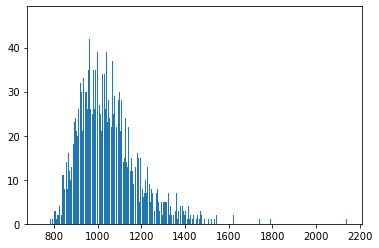

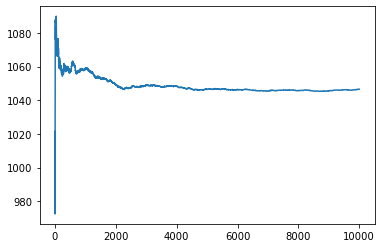

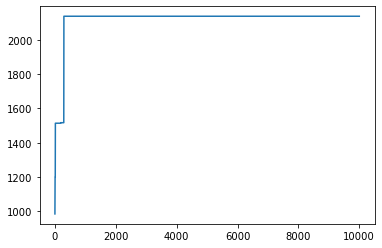

0
(1477, array([78., 78., 78., ...,  0.,  0.,  0.]))
1
(1376, array([65., 65., 65., ...,  0.,  0.,  0.]))
2
(1198, array([73., 73., 73., ...,  0.,  0.,  0.]))
3
(1211, array([ 70., 157., 157., ...,   0.,   0.,   0.]))
4
(1687, array([ 72., 153., 226., ...,   0.,   0.,   0.]))
5
(1501, array([77., 77., 77., ...,  0.,  0.,  0.]))
6
(1558, array([ 67., 130., 198., ...,   0.,   0.,   0.]))
7
(1572, array([ 73., 130., 130., ...,   0.,   0.,   0.]))
8
(1263, array([ 80., 150., 237., ...,   0.,   0.,   0.]))
9
(1301, array([64., 64., 64., ...,  0.,  0.,  0.]))
10
(1772, array([ 92., 166., 166., ...,   0.,   0.,   0.]))
11
(1439, array([ 80., 138., 138., ...,   0.,   0.,   0.]))
12
(1377, array([101., 183., 250., ...,   0.,   0.,   0.]))
13
(1362, array([66., 66., 66., ...,  0.,  0.,  0.]))
14
(1314, array([76., 76., 76., ...,  0.,  0.,  0.]))
15
(1349, array([76., 76., 76., ...,  0.,  0.,  0.]))
16
(1475, array([81., 81., 81., ...,  0.,  0.,  0.]))
17
(1230, array([ 59., 130., 196., ...,   0.

142
(1562, array([ 69., 139., 200., ...,   0.,   0.,   0.]))
143
(1475, array([ 60., 134., 134., ...,   0.,   0.,   0.]))
144
(1323, array([ 87., 162., 162., ...,   0.,   0.,   0.]))
145
(1232, array([ 70., 146., 223., ...,   0.,   0.,   0.]))
146
(1106, array([ 67.,  67., 143., ...,   0.,   0.,   0.]))
147
(1709, array([ 78., 157., 232., ...,   0.,   0.,   0.]))
148
(1633, array([ 63.,  63., 139., ...,   0.,   0.,   0.]))
149
(1378, array([85., 85., 85., ...,  0.,  0.,  0.]))
150
(1650, array([74., 74., 74., ...,  0.,  0.,  0.]))
151
(1144, array([ 78.,  78., 139., ...,   0.,   0.,   0.]))
152
(1171, array([75., 75., 75., ...,  0.,  0.,  0.]))
153
(1256, array([ 68., 144., 211., ...,   0.,   0.,   0.]))
154
(1342, array([79., 79., 79., ...,  0.,  0.,  0.]))
155
(1666, array([ 58.,  58., 137., ...,   0.,   0.,   0.]))
156
(1379, array([ 78., 151., 151., ...,   0.,   0.,   0.]))
157
(1555, array([ 82., 159., 226., ...,   0.,   0.,   0.]))
158
(1382, array([ 83., 179., 250., ...,   0.,  

(1618, array([81., 81., 81., ...,  0.,  0.,  0.]))
283
(1292, array([ 71., 137., 201., ...,   0.,   0.,   0.]))
284
(1273, array([61., 61., 61., ...,  0.,  0.,  0.]))
285
(1309, array([ 78., 150., 227., ...,   0.,   0.,   0.]))
286
(1398, array([ 71.,  71., 141., ...,   0.,   0.,   0.]))
287
(1483, array([85., 85., 85., ...,  0.,  0.,  0.]))
288
(1329, array([ 77., 146., 202., ...,   0.,   0.,   0.]))
289
(1478, array([60., 60., 60., ...,  0.,  0.,  0.]))
290
(1160, array([73., 73., 73., ...,  0.,  0.,  0.]))
291
(1477, array([ 75.,  75., 143., ...,   0.,   0.,   0.]))
292
(1261, array([ 80., 146., 219., ...,   0.,   0.,   0.]))
293
(1411, array([64., 64., 64., ...,  0.,  0.,  0.]))
294
(1317, array([ 80., 146., 146., ...,   0.,   0.,   0.]))
295
(1112, array([ 77., 140., 202., ...,   0.,   0.,   0.]))
296
(1358, array([59., 59., 59., ...,  0.,  0.,  0.]))
297
(1387, array([ 67., 149., 149., ...,   0.,   0.,   0.]))
298
(1257, array([ 59.,  59., 132., ...,   0.,   0.,   0.]))
299
(1233

(1172, array([68., 68., 68., ...,  0.,  0.,  0.]))
422
(1170, array([ 58., 138., 215., ...,   0.,   0.,   0.]))
423
(1133, array([ 63.,  63., 128., ...,   0.,   0.,   0.]))
424
(1157, array([72., 72., 72., ...,  0.,  0.,  0.]))
425
(1145, array([ 66., 154., 231., ...,   0.,   0.,   0.]))
426
(1274, array([74., 74., 74., ...,  0.,  0.,  0.]))
427
(1711, array([68., 68., 68., ...,  0.,  0.,  0.]))
428
(1421, array([ 69., 133., 133., ...,   0.,   0.,   0.]))
429
(1542, array([ 82.,  82., 147., ...,   0.,   0.,   0.]))
430
(1368, array([ 74.,  74., 150., ...,   0.,   0.,   0.]))
431
(1388, array([ 83., 149., 219., ...,   0.,   0.,   0.]))
432
(1163, array([ 59., 126., 193., ...,   0.,   0.,   0.]))
433
(1646, array([ 66.,  66., 142., ...,   0.,   0.,   0.]))
434
(1499, array([ 71., 142., 211., ...,   0.,   0.,   0.]))
435
(1227, array([ 80., 151., 235., ...,   0.,   0.,   0.]))
436
(1507, array([ 77., 161., 234., ...,   0.,   0.,   0.]))
437
(1316, array([ 79., 137., 137., ...,   0.,   0.,

(1266, array([ 74., 140., 206., ...,   0.,   0.,   0.]))
560
(1574, array([ 74., 131., 131., ...,   0.,   0.,   0.]))
561
(1183, array([77., 77., 77., ...,  0.,  0.,  0.]))
562
(1405, array([59., 59., 59., ...,  0.,  0.,  0.]))
563
(1233, array([ 80., 143., 202., ...,   0.,   0.,   0.]))
564
(1443, array([68., 68., 68., ...,  0.,  0.,  0.]))
565
(1328, array([73., 73., 73., ...,  0.,  0.,  0.]))
566
(1407, array([ 85.,  85., 149., ...,   0.,   0.,   0.]))
567
(1265, array([ 65., 133., 197., ...,   0.,   0.,   0.]))
568
(1235, array([ 65.,  65., 125., ...,   0.,   0.,   0.]))
569
(1419, array([ 69.,  69., 134., ...,   0.,   0.,   0.]))
570
(1146, array([85., 85., 85., ...,  0.,  0.,  0.]))
571
(1239, array([ 72., 147., 147., ...,   0.,   0.,   0.]))
572
(1186, array([67., 67., 67., ...,  0.,  0.,  0.]))
573
(1213, array([ 64.,  64., 147., ...,   0.,   0.,   0.]))
574
(1416, array([69., 69., 69., ...,  0.,  0.,  0.]))
575
(1309, array([ 80., 147., 215., ...,   0.,   0.,   0.]))
576
(1217

(1279, array([ 86., 165., 240., ...,   0.,   0.,   0.]))
699
(1176, array([79., 79., 79., ...,  0.,  0.,  0.]))
700
(1743, array([ 77., 146., 146., ...,   0.,   0.,   0.]))
701
(1338, array([69., 69., 69., ...,  0.,  0.,  0.]))
702
(1256, array([ 73., 148., 148., ...,   0.,   0.,   0.]))
703
(1253, array([ 76., 138., 216., ...,   0.,   0.,   0.]))
704
(1289, array([ 64., 112., 189., ...,   0.,   0.,   0.]))
705
(1326, array([ 62., 122., 122., ...,   0.,   0.,   0.]))
706
(1322, array([ 69., 137., 202., ...,   0.,   0.,   0.]))
707
(1339, array([77., 77., 77., ...,  0.,  0.,  0.]))
708
(1182, array([82., 82., 82., ...,  0.,  0.,  0.]))
709
(1138, array([77., 77., 77., ...,  0.,  0.,  0.]))
710
(1045, array([70., 70., 70., ...,  0.,  0.,  0.]))
711
(1543, array([ 68., 147., 207., ...,   0.,   0.,   0.]))
712
(1366, array([64., 64., 64., ...,  0.,  0.,  0.]))
713
(1223, array([ 87.,  87., 165., ...,   0.,   0.,   0.]))
714
(1297, array([58., 58., 58., ...,  0.,  0.,  0.]))
715
(1373, arra

(1335, array([ 76., 148., 208., ...,   0.,   0.,   0.]))
838
(1695, array([ 73., 147., 213., ...,   0.,   0.,   0.]))
839
(1180, array([73., 73., 73., ...,  0.,  0.,  0.]))
840
(1354, array([ 75., 157., 233., ...,   0.,   0.,   0.]))
841
(1402, array([ 77.,  77., 143., ...,   0.,   0.,   0.]))
842
(1434, array([76., 76., 76., ...,  0.,  0.,  0.]))
843
(1326, array([ 69.,  69., 136., ...,   0.,   0.,   0.]))
844
(1715, array([ 68., 116., 185., ...,   0.,   0.,   0.]))
845
(1158, array([ 79., 152., 224., ...,   0.,   0.,   0.]))
846
(1138, array([ 55., 123., 203., ...,   0.,   0.,   0.]))
847
(1244, array([ 59., 138., 205., ...,   0.,   0.,   0.]))
848
(1443, array([73., 73., 73., ...,  0.,  0.,  0.]))
849
(1463, array([62., 62., 62., ...,  0.,  0.,  0.]))
850
(1367, array([ 65., 140., 140., ...,   0.,   0.,   0.]))
851
(1136, array([ 68.,  68., 145., ...,   0.,   0.,   0.]))
852
(1211, array([ 67., 133., 133., ...,   0.,   0.,   0.]))
853
(1211, array([ 76.,  76., 143., ...,   0.,   0.,

(1466, array([66., 66., 66., ...,  0.,  0.,  0.]))
976
(1272, array([ 69., 149., 220., ...,   0.,   0.,   0.]))
977
(1754, array([69., 69., 69., ...,  0.,  0.,  0.]))
978
(1331, array([71., 71., 71., ...,  0.,  0.,  0.]))
979
(1146, array([ 82., 152., 152., ...,   0.,   0.,   0.]))
980
(1070, array([ 76., 141., 195., ...,   0.,   0.,   0.]))
981
(1452, array([ 73.,  73., 151., ...,   0.,   0.,   0.]))
982
(1482, array([ 70., 141., 213., ...,   0.,   0.,   0.]))
983
(1490, array([ 70.,  70., 144., ...,   0.,   0.,   0.]))
984
(1530, array([ 89.,  89., 163., ...,   0.,   0.,   0.]))
985
(1147, array([ 67.,  67., 144., ...,   0.,   0.,   0.]))
986
(1351, array([ 62.,  62., 154., ...,   0.,   0.,   0.]))
987
(1285, array([ 81., 160., 213., ...,   0.,   0.,   0.]))
988
(1221, array([ 71., 136., 192., ...,   0.,   0.,   0.]))
989
(1270, array([70., 70., 70., ...,  0.,  0.,  0.]))
990
(1401, array([ 73., 133., 133., ...,   0.,   0.,   0.]))
991
(1520, array([ 66.,  66., 126., ...,   0.,   0.,

(1278, array([68., 68., 68., ...,  0.,  0.,  0.]))
1113
(1190, array([75., 75., 75., ...,  0.,  0.,  0.]))
1114
(1539, array([ 77., 149., 149., ...,   0.,   0.,   0.]))
1115
(1163, array([ 59.,  59., 134., ...,   0.,   0.,   0.]))
1116
(2029, array([ 75., 163., 235., ...,   0.,   0.,   0.]))
1117
(1422, array([ 72., 157., 219., ...,   0.,   0.,   0.]))
1118
(1275, array([85., 85., 85., ...,  0.,  0.,  0.]))
1119
(1119, array([ 67., 146., 222., ...,   0.,   0.,   0.]))
1120
(1373, array([ 89.,  89., 154., ...,   0.,   0.,   0.]))
1121
(1225, array([53., 53., 53., ...,  0.,  0.,  0.]))
1122
(1161, array([ 64., 142., 142., ...,   0.,   0.,   0.]))
1123
(1542, array([60., 60., 60., ...,  0.,  0.,  0.]))
1124
(1200, array([ 74., 134., 134., ...,   0.,   0.,   0.]))
1125
(1497, array([ 67.,  67., 142., ...,   0.,   0.,   0.]))
1126
(1169, array([ 84., 144., 201., ...,   0.,   0.,   0.]))
1127
(1555, array([77., 77., 77., ...,  0.,  0.,  0.]))
1128
(1295, array([ 81., 154., 230., ...,   0.,  

(1319, array([82., 82., 82., ...,  0.,  0.,  0.]))
1250
(1249, array([ 73.,  73., 142., ...,   0.,   0.,   0.]))
1251
(1343, array([ 74., 142., 215., ...,   0.,   0.,   0.]))
1252
(1135, array([79., 79., 79., ...,  0.,  0.,  0.]))
1253
(1330, array([ 67., 139., 209., ...,   0.,   0.,   0.]))
1254
(1522, array([ 76., 146., 228., ...,   0.,   0.,   0.]))
1255
(1725, array([ 73., 128., 209., ...,   0.,   0.,   0.]))
1256
(1342, array([82., 82., 82., ...,  0.,  0.,  0.]))
1257
(1415, array([65., 65., 65., ...,  0.,  0.,  0.]))
1258
(1170, array([ 79., 159., 233., ...,   0.,   0.,   0.]))
1259
(1251, array([ 67., 133., 133., ...,   0.,   0.,   0.]))
1260
(1194, array([57., 57., 57., ...,  0.,  0.,  0.]))
1261
(1379, array([ 56., 120., 120., ...,   0.,   0.,   0.]))
1262
(1163, array([65., 65., 65., ...,  0.,  0.,  0.]))
1263
(1371, array([ 82.,  82., 154., ...,   0.,   0.,   0.]))
1264
(1455, array([ 69., 142., 205., ...,   0.,   0.,   0.]))
1265
(1288, array([66., 66., 66., ...,  0.,  0., 

(1240, array([ 68.,  68., 136., ...,   0.,   0.,   0.]))
1386
(1352, array([75., 75., 75., ...,  0.,  0.,  0.]))
1387
(1395, array([61., 61., 61., ...,  0.,  0.,  0.]))
1388
(1372, array([75., 75., 75., ...,  0.,  0.,  0.]))
1389
(1478, array([58., 58., 58., ...,  0.,  0.,  0.]))
1390
(1139, array([75., 75., 75., ...,  0.,  0.,  0.]))
1391
(1400, array([ 69., 129., 129., ...,   0.,   0.,   0.]))
1392
(1422, array([ 57., 136., 203., ...,   0.,   0.,   0.]))
1393
(1477, array([72., 72., 72., ...,  0.,  0.,  0.]))
1394
(1456, array([ 70., 147., 219., ...,   0.,   0.,   0.]))
1395
(1358, array([ 68.,  68., 133., ...,   0.,   0.,   0.]))
1396
(1300, array([ 79., 154., 154., ...,   0.,   0.,   0.]))
1397
(1155, array([70., 70., 70., ...,  0.,  0.,  0.]))
1398
(1271, array([76., 76., 76., ...,  0.,  0.,  0.]))
1399
(1225, array([ 70., 138., 215., ...,   0.,   0.,   0.]))
1400
(1463, array([ 82., 148., 217., ...,   0.,   0.,   0.]))
1401
(1655, array([ 56.,  56., 131., ...,   0.,   0.,   0.]))

(1728, array([ 66., 152., 220., ...,   0.,   0.,   0.]))
1522
(1329, array([ 76., 152., 223., ...,   0.,   0.,   0.]))
1523
(1326, array([ 76.,  76., 146., ...,   0.,   0.,   0.]))
1524
(1480, array([68., 68., 68., ...,  0.,  0.,  0.]))
1525
(1484, array([ 64.,  64., 138., ...,   0.,   0.,   0.]))
1526
(1282, array([63., 63., 63., ...,  0.,  0.,  0.]))
1527
(1375, array([62., 62., 62., ...,  0.,  0.,  0.]))
1528
(1307, array([ 85.,  85., 155., ...,   0.,   0.,   0.]))
1529
(1436, array([75., 75., 75., ...,  0.,  0.,  0.]))
1530
(1352, array([75., 75., 75., ...,  0.,  0.,  0.]))
1531
(2001, array([ 74.,  74., 152., ...,   0.,   0.,   0.]))
1532
(1630, array([ 68., 134., 195., ...,   0.,   0.,   0.]))
1533
(1482, array([73., 73., 73., ...,  0.,  0.,  0.]))
1534
(1307, array([73., 73., 73., ...,  0.,  0.,  0.]))
1535
(1071, array([64., 64., 64., ...,  0.,  0.,  0.]))
1536
(1732, array([ 83., 174., 238., ...,   0.,   0.,   0.]))
1537
(1524, array([ 71., 145., 209., ...,   0.,   0.,   0.]))

(1359, array([ 75., 133., 214., ...,   0.,   0.,   0.]))
1659
(1195, array([ 67.,  67., 137., ...,   0.,   0.,   0.]))
1660
(1486, array([ 56., 128., 203., ...,   0.,   0.,   0.]))
1661
(1484, array([ 54., 127., 127., ...,   0.,   0.,   0.]))
1662
(1438, array([ 69., 141., 211., ...,   0.,   0.,   0.]))
1663
(1272, array([ 72.,  72., 126., ...,   0.,   0.,   0.]))
1664
(1626, array([ 79.,  79., 136., ...,   0.,   0.,   0.]))
1665
(1299, array([ 85., 148., 221., ...,   0.,   0.,   0.]))
1666
(1125, array([ 64., 150., 218., ...,   0.,   0.,   0.]))
1667
(1517, array([ 71., 127., 177., ...,   0.,   0.,   0.]))
1668
(1775, array([79., 79., 79., ...,  0.,  0.,  0.]))
1669
(1621, array([ 63., 128., 193., ...,   0.,   0.,   0.]))
1670
(1663, array([70., 70., 70., ...,  0.,  0.,  0.]))
1671
(1316, array([ 61., 128., 210., ...,   0.,   0.,   0.]))
1672
(1602, array([ 73., 145., 211., ...,   0.,   0.,   0.]))
1673
(2110, array([ 72.,  72., 155., ...,   0.,   0.,   0.]))
1674
(1635, array([ 76., 

(1269, array([ 77., 157., 157., ...,   0.,   0.,   0.]))
1795
(1245, array([82., 82., 82., ...,  0.,  0.,  0.]))
1796
(1374, array([ 74.,  74., 149., ...,   0.,   0.,   0.]))
1797
(1327, array([75., 75., 75., ...,  0.,  0.,  0.]))
1798
(1229, array([ 59., 129., 223., ...,   0.,   0.,   0.]))
1799
(1330, array([ 63.,  63., 135., ...,   0.,   0.,   0.]))
1800
(1523, array([ 79., 157., 226., ...,   0.,   0.,   0.]))
1801
(1285, array([70., 70., 70., ...,  0.,  0.,  0.]))
1802
(1256, array([65., 65., 65., ...,  0.,  0.,  0.]))
1803
(1300, array([67., 67., 67., ...,  0.,  0.,  0.]))
1804
(1371, array([ 70., 134., 204., ...,   0.,   0.,   0.]))
1805
(1537, array([80., 80., 80., ...,  0.,  0.,  0.]))
1806
(1248, array([76., 76., 76., ...,  0.,  0.,  0.]))
1807
(1143, array([ 80., 151., 151., ...,   0.,   0.,   0.]))
1808
(1516, array([83., 83., 83., ...,  0.,  0.,  0.]))
1809
(1579, array([ 85., 150., 150., ...,   0.,   0.,   0.]))
1810
(1318, array([62., 62., 62., ...,  0.,  0.,  0.]))
1811


(1316, array([ 79., 144., 212., ...,   0.,   0.,   0.]))
1932
(1271, array([ 72., 154., 154., ...,   0.,   0.,   0.]))
1933
(1351, array([73., 73., 73., ...,  0.,  0.,  0.]))
1934
(1472, array([ 69., 145., 209., ...,   0.,   0.,   0.]))
1935
(1196, array([73., 73., 73., ...,  0.,  0.,  0.]))
1936
(1392, array([ 74.,  74., 148., ...,   0.,   0.,   0.]))
1937
(1300, array([89., 89., 89., ...,  0.,  0.,  0.]))
1938
(1280, array([72., 72., 72., ...,  0.,  0.,  0.]))
1939
(1458, array([80., 80., 80., ...,  0.,  0.,  0.]))
1940
(1313, array([ 72., 141., 141., ...,   0.,   0.,   0.]))
1941
(1529, array([ 62., 140., 211., ...,   0.,   0.,   0.]))
1942
(1289, array([59., 59., 59., ...,  0.,  0.,  0.]))
1943
(1160, array([60., 60., 60., ...,  0.,  0.,  0.]))
1944
(1199, array([69., 69., 69., ...,  0.,  0.,  0.]))
1945
(1402, array([52., 52., 52., ...,  0.,  0.,  0.]))
1946
(1238, array([ 78.,  78., 145., ...,   0.,   0.,   0.]))
1947
(1672, array([ 81., 148., 214., ...,   0.,   0.,   0.]))
1948


(1537, array([ 47.,  47., 126., ...,   0.,   0.,   0.]))
2069
(2027, array([ 64., 138., 203., ...,   0.,   0.,   0.]))
2070
(1092, array([71., 71., 71., ...,  0.,  0.,  0.]))
2071
(1544, array([ 75., 146., 213., ...,   0.,   0.,   0.]))
2072
(1264, array([86., 86., 86., ...,  0.,  0.,  0.]))
2073
(1336, array([ 60., 122., 122., ...,   0.,   0.,   0.]))
2074
(1523, array([ 69.,  69., 136., ...,   0.,   0.,   0.]))
2075
(1397, array([80., 80., 80., ...,  0.,  0.,  0.]))
2076
(1247, array([69., 69., 69., ...,  0.,  0.,  0.]))
2077
(2105, array([ 55., 122., 193., ...,   0.,   0.,   0.]))
2078
(1244, array([ 80.,  80., 152., ...,   0.,   0.,   0.]))
2079
(1355, array([ 68.,  68., 140., ...,   0.,   0.,   0.]))
2080
(1444, array([77., 77., 77., ...,  0.,  0.,  0.]))
2081
(1352, array([ 91., 151., 205., ...,   0.,   0.,   0.]))
2082
(1435, array([ 72.,  72., 143., ...,   0.,   0.,   0.]))
2083
(1894, array([73., 73., 73., ...,  0.,  0.,  0.]))
2084
(1205, array([ 69., 146., 227., ...,   0.,  

(1275, array([ 82., 155., 221., ...,   0.,   0.,   0.]))
2205
(1385, array([ 82., 141., 141., ...,   0.,   0.,   0.]))
2206
(1359, array([ 71.,  71., 147., ...,   0.,   0.,   0.]))
2207
(1380, array([ 81., 167., 245., ...,   0.,   0.,   0.]))
2208
(1314, array([ 64., 136., 136., ...,   0.,   0.,   0.]))
2209
(1280, array([78., 78., 78., ...,  0.,  0.,  0.]))
2210
(1569, array([77., 77., 77., ...,  0.,  0.,  0.]))
2211
(1120, array([74., 74., 74., ...,  0.,  0.,  0.]))
2212
(1365, array([ 80.,  80., 152., ...,   0.,   0.,   0.]))
2213
(1368, array([ 80., 151., 226., ...,   0.,   0.,   0.]))
2214
(1039, array([73., 73., 73., ...,  0.,  0.,  0.]))
2215
(1100, array([ 80.,  80., 154., ...,   0.,   0.,   0.]))
2216
(1200, array([ 59.,  59., 133., ...,   0.,   0.,   0.]))
2217
(1187, array([ 60., 137., 202., ...,   0.,   0.,   0.]))
2218
(1322, array([ 71.,  71., 140., ...,   0.,   0.,   0.]))
2219
(1391, array([69., 69., 69., ...,  0.,  0.,  0.]))
2220
(1301, array([77., 77., 77., ...,  0.,

(1626, array([77., 77., 77., ...,  0.,  0.,  0.]))
2342
(1498, array([ 87.,  87., 160., ...,   0.,   0.,   0.]))
2343
(1409, array([ 75., 133., 220., ...,   0.,   0.,   0.]))
2344
(1488, array([ 67., 149., 149., ...,   0.,   0.,   0.]))
2345
(1178, array([91., 91., 91., ...,  0.,  0.,  0.]))
2346
(1201, array([64., 64., 64., ...,  0.,  0.,  0.]))
2347
(1534, array([ 79.,  79., 142., ...,   0.,   0.,   0.]))
2348
(1835, array([ 60., 142., 214., ...,   0.,   0.,   0.]))
2349
(1444, array([64., 64., 64., ...,  0.,  0.,  0.]))
2350
(1149, array([ 70.,  70., 158., ...,   0.,   0.,   0.]))
2351
(1342, array([ 64.,  64., 143., ...,   0.,   0.,   0.]))
2352
(1391, array([ 65., 130., 130., ...,   0.,   0.,   0.]))
2353
(1316, array([71., 71., 71., ...,  0.,  0.,  0.]))
2354
(1394, array([60., 60., 60., ...,  0.,  0.,  0.]))
2355
(1377, array([ 78.,  78., 139., ...,   0.,   0.,   0.]))
2356
(1238, array([ 72., 135., 135., ...,   0.,   0.,   0.]))
2357
(1502, array([77., 77., 77., ...,  0.,  0., 

(1414, array([ 86.,  86., 148., ...,   0.,   0.,   0.]))
2478
(1405, array([ 66., 130., 130., ...,   0.,   0.,   0.]))
2479
(1872, array([81., 81., 81., ...,  0.,  0.,  0.]))
2480
(1425, array([ 61.,  61., 128., ...,   0.,   0.,   0.]))
2481
(1300, array([70., 70., 70., ...,  0.,  0.,  0.]))
2482
(1401, array([ 73., 123., 202., ...,   0.,   0.,   0.]))
2483
(1436, array([69., 69., 69., ...,  0.,  0.,  0.]))
2484
(1316, array([ 74., 144., 144., ...,   0.,   0.,   0.]))
2485
(1213, array([65., 65., 65., ...,  0.,  0.,  0.]))
2486
(1475, array([76., 76., 76., ...,  0.,  0.,  0.]))
2487
(1358, array([77., 77., 77., ...,  0.,  0.,  0.]))
2488
(1885, array([ 71.,  71., 158., ...,   0.,   0.,   0.]))
2489
(1155, array([ 66.,  66., 121., ...,   0.,   0.,   0.]))
2490
(1164, array([ 56., 123., 123., ...,   0.,   0.,   0.]))
2491
(1223, array([ 73., 156., 156., ...,   0.,   0.,   0.]))
2492
(1741, array([ 77., 140., 140., ...,   0.,   0.,   0.]))
2493
(1382, array([ 67., 148., 148., ...,   0.,  

(1343, array([ 66.,  66., 155., ...,   0.,   0.,   0.]))
2614
(1452, array([ 63., 134., 204., ...,   0.,   0.,   0.]))
2615
(1145, array([ 84., 157., 223., ...,   0.,   0.,   0.]))
2616
(1452, array([ 57., 126., 208., ...,   0.,   0.,   0.]))
2617
(1671, array([ 80., 162., 237., ...,   0.,   0.,   0.]))
2618
(1404, array([71., 71., 71., ...,  0.,  0.,  0.]))
2619
(1570, array([ 63., 139., 139., ...,   0.,   0.,   0.]))
2620
(1203, array([ 86., 161., 161., ...,   0.,   0.,   0.]))
2621
(1177, array([59., 59., 59., ...,  0.,  0.,  0.]))
2622
(1094, array([ 69., 140., 140., ...,   0.,   0.,   0.]))
2623
(1399, array([ 65., 138., 190., ...,   0.,   0.,   0.]))
2624
(1483, array([ 63., 154., 236., ...,   0.,   0.,   0.]))
2625
(1661, array([76., 76., 76., ...,  0.,  0.,  0.]))
2626
(1221, array([87., 87., 87., ...,  0.,  0.,  0.]))
2627
(1652, array([ 73., 134., 134., ...,   0.,   0.,   0.]))
2628
(1347, array([61., 61., 61., ...,  0.,  0.,  0.]))
2629
(1267, array([ 74.,  74., 150., ...,  

(1448, array([ 78.,  78., 145., ...,   0.,   0.,   0.]))
2751
(1582, array([79., 79., 79., ...,  0.,  0.,  0.]))
2752
(1539, array([61., 61., 61., ...,  0.,  0.,  0.]))
2753
(1218, array([ 69.,  69., 136., ...,   0.,   0.,   0.]))
2754
(1410, array([65., 65., 65., ...,  0.,  0.,  0.]))
2755
(1751, array([ 72., 136., 136., ...,   0.,   0.,   0.]))
2756
(1253, array([ 90., 170., 239., ...,   0.,   0.,   0.]))
2757
(1557, array([70., 70., 70., ...,  0.,  0.,  0.]))
2758
(1192, array([79., 79., 79., ...,  0.,  0.,  0.]))
2759
(1379, array([ 64.,  64., 147., ...,   0.,   0.,   0.]))
2760
(1323, array([65., 65., 65., ...,  0.,  0.,  0.]))
2761
(1744, array([ 74., 141., 200., ...,   0.,   0.,   0.]))
2762
(1368, array([ 82., 155., 214., ...,   0.,   0.,   0.]))
2763
(1430, array([ 82.,  82., 170., ...,   0.,   0.,   0.]))
2764
(1405, array([68., 68., 68., ...,  0.,  0.,  0.]))
2765
(1321, array([ 79., 158., 232., ...,   0.,   0.,   0.]))
2766
(1559, array([ 78., 144., 199., ...,   0.,   0.,  

(1238, array([ 68., 140., 200., ...,   0.,   0.,   0.]))
2887
(1852, array([ 76.,  76., 156., ...,   0.,   0.,   0.]))
2888
(1200, array([ 72.,  72., 132., ...,   0.,   0.,   0.]))
2889
(1319, array([73., 73., 73., ...,  0.,  0.,  0.]))
2890
(1221, array([ 96., 177., 241., ...,   0.,   0.,   0.]))
2891
(1298, array([ 72., 149., 215., ...,   0.,   0.,   0.]))
2892
(1428, array([ 74., 143., 143., ...,   0.,   0.,   0.]))
2893
(1331, array([ 74.,  74., 142., ...,   0.,   0.,   0.]))
2894
(1826, array([ 70., 152., 207., ...,   0.,   0.,   0.]))
2895
(1442, array([ 78., 146., 146., ...,   0.,   0.,   0.]))
2896
(1751, array([68., 68., 68., ...,  0.,  0.,  0.]))
2897
(1183, array([72., 72., 72., ...,  0.,  0.,  0.]))
2898
(1211, array([77., 77., 77., ...,  0.,  0.,  0.]))
2899
(1257, array([71., 71., 71., ...,  0.,  0.,  0.]))
2900
(1385, array([ 76., 142., 142., ...,   0.,   0.,   0.]))
2901
(1277, array([ 84., 149., 223., ...,   0.,   0.,   0.]))
2902
(1384, array([ 72., 145., 216., ...,  

(1265, array([ 77.,  77., 156., ...,   0.,   0.,   0.]))
3023
(1345, array([ 64.,  64., 134., ...,   0.,   0.,   0.]))
3024
(1277, array([ 62.,  62., 124., ...,   0.,   0.,   0.]))
3025
(1401, array([ 85., 145., 145., ...,   0.,   0.,   0.]))
3026
(1137, array([ 76., 136., 136., ...,   0.,   0.,   0.]))
3027
(1189, array([ 67., 135., 135., ...,   0.,   0.,   0.]))
3028
(1479, array([65., 65., 65., ...,  0.,  0.,  0.]))
3029
(1256, array([ 63.,  63., 146., ...,   0.,   0.,   0.]))
3030
(1262, array([ 61., 128., 128., ...,   0.,   0.,   0.]))
3031
(1415, array([ 65., 135., 210., ...,   0.,   0.,   0.]))
3032
(1258, array([70., 70., 70., ...,  0.,  0.,  0.]))
3033
(1689, array([ 88.,  88., 149., ...,   0.,   0.,   0.]))
3034
(1390, array([80., 80., 80., ...,  0.,  0.,  0.]))
3035
(1396, array([72., 72., 72., ...,  0.,  0.,  0.]))
3036
(1402, array([57., 57., 57., ...,  0.,  0.,  0.]))
3037
(1181, array([ 75., 144., 213., ...,   0.,   0.,   0.]))
3038
(1528, array([ 70., 141., 221., ...,  

(1322, array([ 67., 147., 209., ...,   0.,   0.,   0.]))
3159
(1333, array([ 70., 139., 207., ...,   0.,   0.,   0.]))
3160
(1265, array([ 78., 156., 228., ...,   0.,   0.,   0.]))
3161
(1236, array([ 94., 176., 233., ...,   0.,   0.,   0.]))
3162
(1259, array([ 72., 130., 208., ...,   0.,   0.,   0.]))
3163
(1703, array([ 67., 117., 184., ...,   0.,   0.,   0.]))
3164
(1395, array([76., 76., 76., ...,  0.,  0.,  0.]))
3165
(1416, array([72., 72., 72., ...,  0.,  0.,  0.]))
3166
(1314, array([63., 63., 63., ...,  0.,  0.,  0.]))
3167
(1532, array([ 70.,  70., 133., ...,   0.,   0.,   0.]))
3168
(1776, array([ 79.,  79., 154., ...,   0.,   0.,   0.]))
3169
(1720, array([ 67., 145., 205., ...,   0.,   0.,   0.]))
3170
(1662, array([ 72., 149., 149., ...,   0.,   0.,   0.]))
3171
(1203, array([78., 78., 78., ...,  0.,  0.,  0.]))
3172
(1615, array([ 71.,  71., 141., ...,   0.,   0.,   0.]))
3173
(1159, array([72., 72., 72., ...,  0.,  0.,  0.]))
3174
(1599, array([ 75.,  75., 140., ...,  

3294
(1356, array([ 72., 168., 168., ...,   0.,   0.,   0.]))
3295
(1698, array([61., 61., 61., ...,  0.,  0.,  0.]))
3296
(1419, array([ 70.,  70., 128., ...,   0.,   0.,   0.]))
3297
(1243, array([ 68., 132., 204., ...,   0.,   0.,   0.]))
3298
(1281, array([ 67., 148., 148., ...,   0.,   0.,   0.]))
3299
(1389, array([ 76., 136., 136., ...,   0.,   0.,   0.]))
3300
(1395, array([64., 64., 64., ...,  0.,  0.,  0.]))
3301
(1259, array([ 79.,  79., 154., ...,   0.,   0.,   0.]))
3302
(1124, array([ 82., 150., 150., ...,   0.,   0.,   0.]))
3303
(1351, array([58., 58., 58., ...,  0.,  0.,  0.]))
3304
(1201, array([77., 77., 77., ...,  0.,  0.,  0.]))
3305
(1240, array([81., 81., 81., ...,  0.,  0.,  0.]))
3306
(1222, array([ 82., 164., 229., ...,   0.,   0.,   0.]))
3307
(1495, array([72., 72., 72., ...,  0.,  0.,  0.]))
3308
(1472, array([ 59., 125., 125., ...,   0.,   0.,   0.]))
3309
(1387, array([68., 68., 68., ...,  0.,  0.,  0.]))
3310
(1695, array([ 80.,  80., 163., ...,   0.,   

(1444, array([72., 72., 72., ...,  0.,  0.,  0.]))
3431
(1198, array([70., 70., 70., ...,  0.,  0.,  0.]))
3432
(1402, array([ 89., 156., 233., ...,   0.,   0.,   0.]))
3433
(1342, array([ 55.,  55., 134., ...,   0.,   0.,   0.]))
3434
(1340, array([74., 74., 74., ...,  0.,  0.,  0.]))
3435
(1540, array([ 71., 151., 227., ...,   0.,   0.,   0.]))
3436
(1834, array([ 72.,  72., 141., ...,   0.,   0.,   0.]))
3437
(1483, array([63., 63., 63., ...,  0.,  0.,  0.]))
3438
(1576, array([ 59., 136., 136., ...,   0.,   0.,   0.]))
3439
(1175, array([ 76., 148., 148., ...,   0.,   0.,   0.]))
3440
(1583, array([ 59., 132., 132., ...,   0.,   0.,   0.]))
3441
(1530, array([ 88., 168., 230., ...,   0.,   0.,   0.]))
3442
(1233, array([71., 71., 71., ...,  0.,  0.,  0.]))
3443
(1383, array([75., 75., 75., ...,  0.,  0.,  0.]))
3444
(1447, array([66., 66., 66., ...,  0.,  0.,  0.]))
3445
(1277, array([69., 69., 69., ...,  0.,  0.,  0.]))
3446
(1442, array([61., 61., 61., ...,  0.,  0.,  0.]))
3447


(1141, array([ 64., 131., 131., ...,   0.,   0.,   0.]))
3568
(1250, array([ 60., 123., 196., ...,   0.,   0.,   0.]))
3569
(1300, array([68., 68., 68., ...,  0.,  0.,  0.]))
3570
(1304, array([64., 64., 64., ...,  0.,  0.,  0.]))
3571
(1577, array([69., 69., 69., ...,  0.,  0.,  0.]))
3572
(1197, array([67., 67., 67., ...,  0.,  0.,  0.]))
3573
(1363, array([ 68., 128., 195., ...,   0.,   0.,   0.]))
3574
(1165, array([ 68., 135., 200., ...,   0.,   0.,   0.]))
3575
(1406, array([ 75.,  75., 153., ...,   0.,   0.,   0.]))
3576
(1193, array([63., 63., 63., ...,  0.,  0.,  0.]))
3577
(1449, array([ 77., 160., 229., ...,   0.,   0.,   0.]))
3578
(1260, array([66., 66., 66., ...,  0.,  0.,  0.]))
3579
(1841, array([ 74., 148., 148., ...,   0.,   0.,   0.]))
3580
(1199, array([68., 68., 68., ...,  0.,  0.,  0.]))
3581
(1168, array([ 67., 132., 132., ...,   0.,   0.,   0.]))
3582
(1241, array([90., 90., 90., ...,  0.,  0.,  0.]))
3583
(1489, array([ 80.,  80., 156., ...,   0.,   0.,   0.]))

3704
(1423, array([ 82.,  82., 156., ...,   0.,   0.,   0.]))
3705
(1642, array([ 81.,  81., 153., ...,   0.,   0.,   0.]))
3706
(1261, array([ 57.,  57., 132., ...,   0.,   0.,   0.]))
3707
(1382, array([ 73.,  73., 144., ...,   0.,   0.,   0.]))
3708
(1976, array([73., 73., 73., ...,  0.,  0.,  0.]))
3709
(1306, array([61., 61., 61., ...,  0.,  0.,  0.]))
3710
(1061, array([ 58., 133., 208., ...,   0.,   0.,   0.]))
3711
(1087, array([81., 81., 81., ...,  0.,  0.,  0.]))
3712
(1241, array([63., 63., 63., ...,  0.,  0.,  0.]))
3713
(1401, array([ 71.,  71., 148., ...,   0.,   0.,   0.]))
3714
(1450, array([73., 73., 73., ...,  0.,  0.,  0.]))
3715
(1732, array([ 71., 135., 193., ...,   0.,   0.,   0.]))
3716
(1356, array([ 71., 144., 144., ...,   0.,   0.,   0.]))
3717
(1182, array([ 65.,  65., 135., ...,   0.,   0.,   0.]))
3718
(1371, array([63., 63., 63., ...,  0.,  0.,  0.]))
3719
(1399, array([67., 67., 67., ...,  0.,  0.,  0.]))
3720
(1231, array([ 78., 152., 223., ...,   0.,   

(1402, array([ 72.,  72., 143., ...,   0.,   0.,   0.]))
3841
(1473, array([ 81., 160., 223., ...,   0.,   0.,   0.]))
3842
(1483, array([ 67., 137., 137., ...,   0.,   0.,   0.]))
3843
(1210, array([68., 68., 68., ...,  0.,  0.,  0.]))
3844
(1145, array([ 58.,  58., 119., ...,   0.,   0.,   0.]))
3845
(1293, array([76., 76., 76., ...,  0.,  0.,  0.]))
3846
(1402, array([78., 78., 78., ...,  0.,  0.,  0.]))
3847
(1282, array([ 69., 128., 204., ...,   0.,   0.,   0.]))
3848
(1140, array([ 65., 141., 198., ...,   0.,   0.,   0.]))
3849
(1292, array([ 60.,  60., 134., ...,   0.,   0.,   0.]))
3850
(1235, array([78., 78., 78., ...,  0.,  0.,  0.]))
3851
(1168, array([ 64., 124., 208., ...,   0.,   0.,   0.]))
3852
(1374, array([62., 62., 62., ...,  0.,  0.,  0.]))
3853
(1417, array([ 80., 160., 160., ...,   0.,   0.,   0.]))
3854
(1218, array([ 62., 150., 150., ...,   0.,   0.,   0.]))
3855
(1355, array([ 87.,  87., 158., ...,   0.,   0.,   0.]))
3856
(1478, array([67., 67., 67., ...,  0.,

(1430, array([ 69., 140., 209., ...,   0.,   0.,   0.]))
3977
(1387, array([ 69.,  69., 143., ...,   0.,   0.,   0.]))
3978
(1361, array([ 72., 155., 226., ...,   0.,   0.,   0.]))
3979
(1634, array([ 68., 124., 124., ...,   0.,   0.,   0.]))
3980
(1134, array([ 77., 140., 140., ...,   0.,   0.,   0.]))
3981
(1206, array([67., 67., 67., ...,  0.,  0.,  0.]))
3982
(1210, array([75., 75., 75., ...,  0.,  0.,  0.]))
3983
(1269, array([ 74., 136., 197., ...,   0.,   0.,   0.]))
3984
(1283, array([ 83., 153., 153., ...,   0.,   0.,   0.]))
3985
(1686, array([ 79., 154., 230., ...,   0.,   0.,   0.]))
3986
(1422, array([ 48.,  48., 122., ...,   0.,   0.,   0.]))
3987
(1623, array([ 57., 127., 127., ...,   0.,   0.,   0.]))
3988
(1237, array([68., 68., 68., ...,  0.,  0.,  0.]))
3989
(1446, array([78., 78., 78., ...,  0.,  0.,  0.]))
3990
(1383, array([ 55., 119., 173., ...,   0.,   0.,   0.]))
3991
(1262, array([ 72., 152., 222., ...,   0.,   0.,   0.]))
3992
(1840, array([ 72.,  72., 142., 

(1410, array([ 76.,  76., 132., ...,   0.,   0.,   0.]))
4114
(1277, array([ 61.,  61., 122., ...,   0.,   0.,   0.]))
4115
(1250, array([ 82., 148., 230., ...,   0.,   0.,   0.]))
4116
(1366, array([67., 67., 67., ...,  0.,  0.,  0.]))
4117
(1367, array([73., 73., 73., ...,  0.,  0.,  0.]))
4118
(1011, array([ 72.,  72., 140., ...,   0.,   0.,   0.]))
4119
(1411, array([67., 67., 67., ...,  0.,  0.,  0.]))
4120
(1358, array([73., 73., 73., ...,  0.,  0.,  0.]))
4121
(1427, array([ 65.,  65., 148., ...,   0.,   0.,   0.]))
4122
(1323, array([70., 70., 70., ...,  0.,  0.,  0.]))
4123
(1328, array([74., 74., 74., ...,  0.,  0.,  0.]))
4124
(1320, array([ 79.,  79., 128., ...,   0.,   0.,   0.]))
4125
(1702, array([57., 57., 57., ...,  0.,  0.,  0.]))
4126
(1247, array([68., 68., 68., ...,  0.,  0.,  0.]))
4127
(1266, array([ 77.,  77., 143., ...,   0.,   0.,   0.]))
4128
(1302, array([62., 62., 62., ...,  0.,  0.,  0.]))
4129
(1254, array([ 80.,  80., 134., ...,   0.,   0.,   0.]))
4130


(1505, array([ 80., 154., 214., ...,   0.,   0.,   0.]))
4251
(1215, array([ 72., 145., 218., ...,   0.,   0.,   0.]))
4252
(1288, array([70., 70., 70., ...,  0.,  0.,  0.]))
4253
(1442, array([ 69., 132., 132., ...,   0.,   0.,   0.]))
4254
(1454, array([ 79., 145., 145., ...,   0.,   0.,   0.]))
4255
(1517, array([67., 67., 67., ...,  0.,  0.,  0.]))
4256
(1277, array([ 61.,  61., 132., ...,   0.,   0.,   0.]))
4257
(1191, array([71., 71., 71., ...,  0.,  0.,  0.]))
4258
(1337, array([80., 80., 80., ...,  0.,  0.,  0.]))
4259
(1515, array([ 73.,  73., 131., ...,   0.,   0.,   0.]))
4260
(1169, array([ 78., 154., 213., ...,   0.,   0.,   0.]))
4261
(1355, array([ 77., 153., 229., ...,   0.,   0.,   0.]))
4262
(1152, array([ 64.,  64., 129., ...,   0.,   0.,   0.]))
4263
(1225, array([ 68., 126., 207., ...,   0.,   0.,   0.]))
4264
(1258, array([69., 69., 69., ...,  0.,  0.,  0.]))
4265
(1524, array([71., 71., 71., ...,  0.,  0.,  0.]))
4266
(1434, array([69., 69., 69., ...,  0.,  0., 

(1278, array([ 72.,  72., 149., ...,   0.,   0.,   0.]))
4387
(1524, array([ 68., 147., 219., ...,   0.,   0.,   0.]))
4388
(1368, array([ 73., 144., 144., ...,   0.,   0.,   0.]))
4389
(1501, array([ 77., 156., 220., ...,   0.,   0.,   0.]))
4390
(1392, array([81., 81., 81., ...,  0.,  0.,  0.]))
4391
(1385, array([67., 67., 67., ...,  0.,  0.,  0.]))
4392
(1528, array([ 79.,  79., 160., ...,   0.,   0.,   0.]))
4393
(1363, array([ 89., 153., 221., ...,   0.,   0.,   0.]))
4394
(1345, array([77., 77., 77., ...,  0.,  0.,  0.]))
4395
(1377, array([ 70., 131., 213., ...,   0.,   0.,   0.]))
4396
(1147, array([64., 64., 64., ...,  0.,  0.,  0.]))
4397
(1738, array([ 54., 116., 173., ...,   0.,   0.,   0.]))
4398
(1196, array([ 71.,  71., 137., ...,   0.,   0.,   0.]))
4399
(1105, array([ 72.,  72., 142., ...,   0.,   0.,   0.]))
4400
(1306, array([ 81., 143., 143., ...,   0.,   0.,   0.]))
4401
(1147, array([ 68., 145., 145., ...,   0.,   0.,   0.]))
4402
(1129, array([ 59., 127., 196., 

(1400, array([ 59.,  59., 133., ...,   0.,   0.,   0.]))
4523
(1348, array([ 67.,  67., 130., ...,   0.,   0.,   0.]))
4524
(1472, array([83., 83., 83., ...,  0.,  0.,  0.]))
4525
(1292, array([63., 63., 63., ...,  0.,  0.,  0.]))
4526
(1169, array([80., 80., 80., ...,  0.,  0.,  0.]))
4527
(1258, array([ 65., 123., 171., ...,   0.,   0.,   0.]))
4528
(1633, array([ 76., 149., 212., ...,   0.,   0.,   0.]))
4529
(1394, array([ 74., 143., 233., ...,   0.,   0.,   0.]))
4530
(1701, array([71., 71., 71., ...,  0.,  0.,  0.]))
4531
(1572, array([69., 69., 69., ...,  0.,  0.,  0.]))
4532
(1210, array([84., 84., 84., ...,  0.,  0.,  0.]))
4533
(1325, array([ 69.,  69., 156., ...,   0.,   0.,   0.]))
4534
(1308, array([ 73.,  73., 134., ...,   0.,   0.,   0.]))
4535
(1556, array([ 81., 147., 147., ...,   0.,   0.,   0.]))
4536
(1197, array([81., 81., 81., ...,  0.,  0.,  0.]))
4537
(1476, array([57., 57., 57., ...,  0.,  0.,  0.]))
4538
(1155, array([ 78.,  78., 160., ...,   0.,   0.,   0.]))

(1309, array([ 67.,  67., 143., ...,   0.,   0.,   0.]))
4659
(1833, array([ 72., 143., 143., ...,   0.,   0.,   0.]))
4660
(1331, array([ 71., 146., 219., ...,   0.,   0.,   0.]))
4661
(1151, array([77., 77., 77., ...,  0.,  0.,  0.]))
4662
(1124, array([ 85.,  85., 179., ...,   0.,   0.,   0.]))
4663
(1105, array([84., 84., 84., ...,  0.,  0.,  0.]))
4664
(1133, array([74., 74., 74., ...,  0.,  0.,  0.]))
4665
(1585, array([ 73., 140., 212., ...,   0.,   0.,   0.]))
4666
(1671, array([ 87., 166., 226., ...,   0.,   0.,   0.]))
4667
(1165, array([75., 75., 75., ...,  0.,  0.,  0.]))
4668
(1243, array([65., 65., 65., ...,  0.,  0.,  0.]))
4669
(1162, array([ 88., 169., 240., ...,   0.,   0.,   0.]))
4670
(1181, array([78., 78., 78., ...,  0.,  0.,  0.]))
4671
(1363, array([79., 79., 79., ...,  0.,  0.,  0.]))
4672
(1407, array([ 84., 162., 240., ...,   0.,   0.,   0.]))
4673
(1493, array([ 83., 148., 219., ...,   0.,   0.,   0.]))
4674
(1272, array([ 84., 150., 213., ...,   0.,   0.,  

(1570, array([ 69., 117., 187., ...,   0.,   0.,   0.]))
4796
(1569, array([ 80., 150., 212., ...,   0.,   0.,   0.]))
4797
(1879, array([ 69.,  69., 133., ...,   0.,   0.,   0.]))
4798
(1345, array([ 77., 151., 236., ...,   0.,   0.,   0.]))
4799
(1382, array([ 77.,  77., 143., ...,   0.,   0.,   0.]))
4800
(1697, array([ 78., 143., 198., ...,   0.,   0.,   0.]))
4801
(1754, array([ 79., 160., 222., ...,   0.,   0.,   0.]))
4802
(1227, array([ 66.,  66., 127., ...,   0.,   0.,   0.]))
4803
(1165, array([ 67.,  67., 139., ...,   0.,   0.,   0.]))
4804
(1327, array([79., 79., 79., ...,  0.,  0.,  0.]))
4805
(1365, array([61., 61., 61., ...,  0.,  0.,  0.]))
4806
(1309, array([78., 78., 78., ...,  0.,  0.,  0.]))
4807
(1241, array([ 72., 152., 221., ...,   0.,   0.,   0.]))
4808
(1192, array([ 68.,  68., 132., ...,   0.,   0.,   0.]))
4809
(1444, array([ 77.,  77., 152., ...,   0.,   0.,   0.]))
4810
(1294, array([ 72.,  72., 143., ...,   0.,   0.,   0.]))
4811
(1366, array([76., 76., 76

(1494, array([88., 88., 88., ...,  0.,  0.,  0.]))
4933
(1261, array([82., 82., 82., ...,  0.,  0.,  0.]))
4934
(1718, array([ 71., 155., 222., ...,   0.,   0.,   0.]))
4935
(1283, array([ 70.,  70., 128., ...,   0.,   0.,   0.]))
4936
(1203, array([81., 81., 81., ...,  0.,  0.,  0.]))
4937
(1243, array([ 72.,  72., 146., ...,   0.,   0.,   0.]))
4938
(1265, array([ 77., 139., 226., ...,   0.,   0.,   0.]))
4939
(1566, array([ 87., 156., 216., ...,   0.,   0.,   0.]))
4940
(1144, array([ 70.,  70., 143., ...,   0.,   0.,   0.]))
4941
(1322, array([ 69.,  69., 142., ...,   0.,   0.,   0.]))
4942
(1149, array([74., 74., 74., ...,  0.,  0.,  0.]))
4943
(1308, array([ 83.,  83., 156., ...,   0.,   0.,   0.]))
4944
(1723, array([66., 66., 66., ...,  0.,  0.,  0.]))
4945
(1439, array([ 67.,  67., 135., ...,   0.,   0.,   0.]))
4946
(1309, array([ 72.,  72., 147., ...,   0.,   0.,   0.]))
4947
(1383, array([ 62., 141., 203., ...,   0.,   0.,   0.]))
4948
(1350, array([66., 66., 66., ...,  0.,

(2052, array([ 68., 149., 149., ...,   0.,   0.,   0.]))
5069
(1312, array([ 68., 141., 206., ...,   0.,   0.,   0.]))
5070
(1112, array([ 74.,  74., 142., ...,   0.,   0.,   0.]))
5071
(1112, array([ 62.,  62., 139., ...,   0.,   0.,   0.]))
5072
(1665, array([74., 74., 74., ...,  0.,  0.,  0.]))
5073
(1293, array([65., 65., 65., ...,  0.,  0.,  0.]))
5074
(1088, array([ 63.,  63., 133., ...,   0.,   0.,   0.]))
5075
(1677, array([65., 65., 65., ...,  0.,  0.,  0.]))
5076
(1727, array([85., 85., 85., ...,  0.,  0.,  0.]))
5077
(1236, array([ 70.,  70., 140., ...,   0.,   0.,   0.]))
5078
(1558, array([ 77.,  77., 153., ...,   0.,   0.,   0.]))
5079
(2009, array([ 61., 128., 128., ...,   0.,   0.,   0.]))
5080
(1296, array([80., 80., 80., ...,  0.,  0.,  0.]))
5081
(1531, array([ 86.,  86., 144., ...,   0.,   0.,   0.]))
5082
(1433, array([ 87., 152., 226., ...,   0.,   0.,   0.]))
5083
(1221, array([ 67.,  67., 145., ...,   0.,   0.,   0.]))
5084
(1682, array([ 72.,  72., 147., ...,  

(1369, array([ 58., 128., 128., ...,   0.,   0.,   0.]))
5206
(1271, array([ 86., 154., 234., ...,   0.,   0.,   0.]))
5207
(1678, array([ 70., 134., 134., ...,   0.,   0.,   0.]))
5208
(1721, array([ 77., 146., 208., ...,   0.,   0.,   0.]))
5209
(1553, array([57., 57., 57., ...,  0.,  0.,  0.]))
5210
(1420, array([ 56., 117., 117., ...,   0.,   0.,   0.]))
5211
(1384, array([ 76.,  76., 153., ...,   0.,   0.,   0.]))
5212
(1322, array([62., 62., 62., ...,  0.,  0.,  0.]))
5213
(1532, array([ 68., 124., 124., ...,   0.,   0.,   0.]))
5214
(1495, array([58., 58., 58., ...,  0.,  0.,  0.]))
5215
(1187, array([ 86.,  86., 156., ...,   0.,   0.,   0.]))
5216
(1801, array([ 61., 126., 195., ...,   0.,   0.,   0.]))
5217
(1291, array([ 62., 119., 119., ...,   0.,   0.,   0.]))
5218
(1613, array([56., 56., 56., ...,  0.,  0.,  0.]))
5219
(1166, array([ 63.,  63., 139., ...,   0.,   0.,   0.]))
5220
(1270, array([ 85., 143., 143., ...,   0.,   0.,   0.]))
5221
(1274, array([ 70., 141., 216., 

(1172, array([ 92., 161., 238., ...,   0.,   0.,   0.]))
5342
(1520, array([ 74., 151., 211., ...,   0.,   0.,   0.]))
5343
(1271, array([ 73.,  73., 132., ...,   0.,   0.,   0.]))
5344
(1589, array([72., 72., 72., ...,  0.,  0.,  0.]))
5345
(1097, array([ 75.,  75., 151., ...,   0.,   0.,   0.]))
5346
(1216, array([ 84., 154., 212., ...,   0.,   0.,   0.]))
5347
(1241, array([ 76., 142., 142., ...,   0.,   0.,   0.]))
5348
(1150, array([64., 64., 64., ...,  0.,  0.,  0.]))
5349
(1247, array([66., 66., 66., ...,  0.,  0.,  0.]))
5350
(1140, array([73., 73., 73., ...,  0.,  0.,  0.]))
5351
(1151, array([ 69.,  69., 142., ...,   0.,   0.,   0.]))
5352
(1540, array([ 73., 150., 227., ...,   0.,   0.,   0.]))
5353
(1562, array([ 56.,  56., 123., ...,   0.,   0.,   0.]))
5354
(1350, array([65., 65., 65., ...,  0.,  0.,  0.]))
5355
(1722, array([ 81.,  81., 147., ...,   0.,   0.,   0.]))
5356
(1292, array([ 67., 146., 228., ...,   0.,   0.,   0.]))
5357
(1527, array([ 71.,  71., 158., ...,  

(1516, array([ 73.,  73., 143., ...,   0.,   0.,   0.]))
5479
(1346, array([78., 78., 78., ...,  0.,  0.,  0.]))
5480
(1241, array([ 78., 156., 221., ...,   0.,   0.,   0.]))
5481
(1223, array([ 78.,  78., 134., ...,   0.,   0.,   0.]))
5482
(1542, array([ 69., 143., 210., ...,   0.,   0.,   0.]))
5483
(1077, array([67., 67., 67., ...,  0.,  0.,  0.]))
5484
(1273, array([ 65., 141., 215., ...,   0.,   0.,   0.]))
5485
(1503, array([64., 64., 64., ...,  0.,  0.,  0.]))
5486
(1312, array([ 87., 156., 156., ...,   0.,   0.,   0.]))
5487
(1241, array([65., 65., 65., ...,  0.,  0.,  0.]))
5488
(1192, array([ 71., 134., 198., ...,   0.,   0.,   0.]))
5489
(1562, array([65., 65., 65., ...,  0.,  0.,  0.]))
5490
(1444, array([ 73., 148., 215., ...,   0.,   0.,   0.]))
5491
(1183, array([ 77.,  77., 135., ...,   0.,   0.,   0.]))
5492
(1440, array([ 73., 148., 219., ...,   0.,   0.,   0.]))
5493
(1523, array([ 74.,  74., 149., ...,   0.,   0.,   0.]))
5494
(1374, array([ 76.,  76., 138., ...,  

(1270, array([ 82.,  82., 156., ...,   0.,   0.,   0.]))
5615
(1512, array([ 76., 140., 196., ...,   0.,   0.,   0.]))
5616
(1342, array([ 75., 141., 141., ...,   0.,   0.,   0.]))
5617
(1159, array([73., 73., 73., ...,  0.,  0.,  0.]))
5618
(1277, array([ 55.,  55., 119., ...,   0.,   0.,   0.]))
5619
(1723, array([ 72.,  72., 150., ...,   0.,   0.,   0.]))
5620
(1556, array([ 67.,  67., 135., ...,   0.,   0.,   0.]))
5621
(1384, array([77., 77., 77., ...,  0.,  0.,  0.]))
5622
(1370, array([69., 69., 69., ...,  0.,  0.,  0.]))
5623
(1131, array([ 62., 123., 193., ...,   0.,   0.,   0.]))
5624
(1349, array([74., 74., 74., ...,  0.,  0.,  0.]))
5625
(1482, array([83., 83., 83., ...,  0.,  0.,  0.]))
5626
(1190, array([ 56., 108., 108., ...,   0.,   0.,   0.]))
5627
(1214, array([68., 68., 68., ...,  0.,  0.,  0.]))
5628
(1185, array([ 76.,  76., 146., ...,   0.,   0.,   0.]))
5629
(1307, array([ 64.,  64., 128., ...,   0.,   0.,   0.]))
5630
(1277, array([68., 68., 68., ...,  0.,  0., 

5751
(1276, array([ 81., 150., 215., ...,   0.,   0.,   0.]))
5752
(1116, array([75., 75., 75., ...,  0.,  0.,  0.]))
5753
(1191, array([ 70.,  70., 145., ...,   0.,   0.,   0.]))
5754
(1395, array([62., 62., 62., ...,  0.,  0.,  0.]))
5755
(1365, array([80., 80., 80., ...,  0.,  0.,  0.]))
5756
(1339, array([63., 63., 63., ...,  0.,  0.,  0.]))
5757
(1714, array([ 59., 134., 196., ...,   0.,   0.,   0.]))
5758
(1249, array([82., 82., 82., ...,  0.,  0.,  0.]))
5759
(1403, array([70., 70., 70., ...,  0.,  0.,  0.]))
5760
(1218, array([78., 78., 78., ...,  0.,  0.,  0.]))
5761
(1268, array([ 73., 148., 148., ...,   0.,   0.,   0.]))
5762
(1331, array([ 68., 129., 191., ...,   0.,   0.,   0.]))
5763
(1349, array([ 74.,  74., 146., ...,   0.,   0.,   0.]))
5764
(1225, array([ 71., 136., 201., ...,   0.,   0.,   0.]))
5765
(1711, array([ 78., 136., 209., ...,   0.,   0.,   0.]))
5766
(1611, array([77., 77., 77., ...,  0.,  0.,  0.]))
5767
(1199, array([76., 76., 76., ...,  0.,  0.,  0.]))


(1249, array([ 65., 113., 181., ...,   0.,   0.,   0.]))
5889
(1465, array([84., 84., 84., ...,  0.,  0.,  0.]))
5890
(1326, array([64., 64., 64., ...,  0.,  0.,  0.]))
5891
(1377, array([87., 87., 87., ...,  0.,  0.,  0.]))
5892
(1531, array([84., 84., 84., ...,  0.,  0.,  0.]))
5893
(1338, array([ 66., 136., 136., ...,   0.,   0.,   0.]))
5894
(1367, array([ 69., 146., 146., ...,   0.,   0.,   0.]))
5895
(1584, array([72., 72., 72., ...,  0.,  0.,  0.]))
5896
(1557, array([ 82., 155., 224., ...,   0.,   0.,   0.]))
5897
(1318, array([ 82.,  82., 168., ...,   0.,   0.,   0.]))
5898
(1391, array([ 75., 146., 206., ...,   0.,   0.,   0.]))
5899
(1231, array([ 71.,  71., 147., ...,   0.,   0.,   0.]))
5900
(1273, array([60., 60., 60., ...,  0.,  0.,  0.]))
5901
(1202, array([56., 56., 56., ...,  0.,  0.,  0.]))
5902
(1359, array([75., 75., 75., ...,  0.,  0.,  0.]))
5903
(1456, array([ 65., 132., 132., ...,   0.,   0.,   0.]))
5904
(1162, array([ 83.,  83., 178., ...,   0.,   0.,   0.]))

6025
(1231, array([ 67.,  67., 150., ...,   0.,   0.,   0.]))
6026
(1274, array([ 59., 145., 220., ...,   0.,   0.,   0.]))
6027
(1602, array([ 64., 135., 194., ...,   0.,   0.,   0.]))
6028
(1415, array([ 84., 150., 223., ...,   0.,   0.,   0.]))
6029
(1398, array([ 72., 147., 147., ...,   0.,   0.,   0.]))
6030
(1487, array([50., 50., 50., ...,  0.,  0.,  0.]))
6031
(1597, array([ 81.,  81., 150., ...,   0.,   0.,   0.]))
6032
(1259, array([ 66.,  66., 142., ...,   0.,   0.,   0.]))
6033
(1479, array([ 68., 149., 216., ...,   0.,   0.,   0.]))
6034
(1291, array([ 84., 154., 230., ...,   0.,   0.,   0.]))
6035
(1241, array([ 72., 136., 206., ...,   0.,   0.,   0.]))
6036
(1415, array([ 60.,  60., 128., ...,   0.,   0.,   0.]))
6037
(1467, array([ 81.,  81., 135., ...,   0.,   0.,   0.]))
6038
(1122, array([79., 79., 79., ...,  0.,  0.,  0.]))
6039
(1310, array([ 55.,  55., 126., ...,   0.,   0.,   0.]))
6040
(1351, array([ 67.,  67., 150., ...,   0.,   0.,   0.]))
6041
(1233, array([7

(1361, array([ 79., 149., 222., ...,   0.,   0.,   0.]))
6162
(1517, array([63., 63., 63., ...,  0.,  0.,  0.]))
6163
(1167, array([ 71., 144., 216., ...,   0.,   0.,   0.]))
6164
(1258, array([ 90., 159., 222., ...,   0.,   0.,   0.]))
6165
(1292, array([68., 68., 68., ...,  0.,  0.,  0.]))
6166
(1447, array([ 81., 153., 153., ...,   0.,   0.,   0.]))
6167
(1698, array([ 70., 160., 235., ...,   0.,   0.,   0.]))
6168
(1307, array([ 73.,  73., 132., ...,   0.,   0.,   0.]))
6169
(1388, array([ 80.,  80., 149., ...,   0.,   0.,   0.]))
6170
(1407, array([ 72., 136., 199., ...,   0.,   0.,   0.]))
6171
(1208, array([74., 74., 74., ...,  0.,  0.,  0.]))
6172
(1890, array([ 74., 145., 209., ...,   0.,   0.,   0.]))
6173
(1413, array([ 91., 152., 213., ...,   0.,   0.,   0.]))
6174
(1296, array([ 73.,  73., 132., ...,   0.,   0.,   0.]))
6175
(1509, array([63., 63., 63., ...,  0.,  0.,  0.]))
6176
(1198, array([71., 71., 71., ...,  0.,  0.,  0.]))
6177
(1380, array([63., 63., 63., ...,  0.,

(1273, array([ 72., 136., 208., ...,   0.,   0.,   0.]))
6298
(1457, array([71., 71., 71., ...,  0.,  0.,  0.]))
6299
(1552, array([ 68.,  68., 129., ...,   0.,   0.,   0.]))
6300
(1259, array([ 77., 145., 218., ...,   0.,   0.,   0.]))
6301
(1038, array([ 78.,  78., 144., ...,   0.,   0.,   0.]))
6302
(1446, array([ 63., 127., 182., ...,   0.,   0.,   0.]))
6303
(1459, array([ 71., 146., 214., ...,   0.,   0.,   0.]))
6304
(1083, array([ 71.,  71., 144., ...,   0.,   0.,   0.]))
6305
(1471, array([ 76.,  76., 134., ...,   0.,   0.,   0.]))
6306
(1154, array([ 74.,  74., 133., ...,   0.,   0.,   0.]))
6307
(1241, array([ 76.,  76., 146., ...,   0.,   0.,   0.]))
6308
(1188, array([67., 67., 67., ...,  0.,  0.,  0.]))
6309
(1242, array([ 79., 158., 238., ...,   0.,   0.,   0.]))
6310
(1150, array([ 57.,  57., 126., ...,   0.,   0.,   0.]))
6311
(1574, array([ 68.,  68., 123., ...,   0.,   0.,   0.]))
6312
(1295, array([ 59.,  59., 129., ...,   0.,   0.,   0.]))
6313
(1346, array([73., 7

(1211, array([83., 83., 83., ...,  0.,  0.,  0.]))
6434
(1238, array([ 77., 154., 154., ...,   0.,   0.,   0.]))
6435
(1295, array([63., 63., 63., ...,  0.,  0.,  0.]))
6436
(1261, array([ 71., 150., 150., ...,   0.,   0.,   0.]))
6437
(1601, array([77., 77., 77., ...,  0.,  0.,  0.]))
6438
(1552, array([ 70., 151., 216., ...,   0.,   0.,   0.]))
6439
(1309, array([ 71., 148., 148., ...,   0.,   0.,   0.]))
6440
(1372, array([56., 56., 56., ...,  0.,  0.,  0.]))
6441
(1352, array([ 72., 135., 202., ...,   0.,   0.,   0.]))
6442
(1438, array([ 82., 157., 218., ...,   0.,   0.,   0.]))
6443
(1636, array([ 68.,  68., 145., ...,   0.,   0.,   0.]))
6444
(1255, array([68., 68., 68., ...,  0.,  0.,  0.]))
6445
(1339, array([ 77.,  77., 139., ...,   0.,   0.,   0.]))
6446
(1309, array([ 71., 131., 197., ...,   0.,   0.,   0.]))
6447
(1565, array([75., 75., 75., ...,  0.,  0.,  0.]))
6448
(1238, array([ 79., 145., 145., ...,   0.,   0.,   0.]))
6449
(1386, array([ 67., 156., 245., ...,   0.,  

(1345, array([72., 72., 72., ...,  0.,  0.,  0.]))
6571
(1404, array([ 88., 157., 157., ...,   0.,   0.,   0.]))
6572
(1378, array([ 84., 159., 221., ...,   0.,   0.,   0.]))
6573
(1258, array([ 62., 126., 191., ...,   0.,   0.,   0.]))
6574
(1899, array([ 74.,  74., 145., ...,   0.,   0.,   0.]))
6575
(1368, array([ 81.,  81., 167., ...,   0.,   0.,   0.]))
6576
(1078, array([ 71., 147., 147., ...,   0.,   0.,   0.]))
6577
(1047, array([ 69., 149., 149., ...,   0.,   0.,   0.]))
6578
(1227, array([80., 80., 80., ...,  0.,  0.,  0.]))
6579
(1502, array([ 62., 118., 195., ...,   0.,   0.,   0.]))
6580
(1442, array([70., 70., 70., ...,  0.,  0.,  0.]))
6581
(1235, array([89., 89., 89., ...,  0.,  0.,  0.]))
6582
(1472, array([86., 86., 86., ...,  0.,  0.,  0.]))
6583
(1319, array([ 88., 166., 244., ...,   0.,   0.,   0.]))
6584
(1312, array([ 83., 136., 198., ...,   0.,   0.,   0.]))
6585
(1141, array([83., 83., 83., ...,  0.,  0.,  0.]))
6586
(1690, array([ 82., 150., 220., ...,   0.,  

(1437, array([ 80., 144., 144., ...,   0.,   0.,   0.]))
6708
(1336, array([ 72., 145., 216., ...,   0.,   0.,   0.]))
6709
(1679, array([ 64.,  64., 129., ...,   0.,   0.,   0.]))
6710
(1859, array([ 81., 154., 154., ...,   0.,   0.,   0.]))
6711
(1364, array([75., 75., 75., ...,  0.,  0.,  0.]))
6712
(1460, array([ 81., 159., 227., ...,   0.,   0.,   0.]))
6713
(1242, array([ 65., 143., 205., ...,   0.,   0.,   0.]))
6714
(1684, array([ 80.,  80., 159., ...,   0.,   0.,   0.]))
6715
(1321, array([71., 71., 71., ...,  0.,  0.,  0.]))
6716
(1614, array([ 73.,  73., 144., ...,   0.,   0.,   0.]))
6717
(1413, array([ 76.,  76., 143., ...,   0.,   0.,   0.]))
6718
(1565, array([73., 73., 73., ...,  0.,  0.,  0.]))
6719
(1439, array([ 73.,  73., 147., ...,   0.,   0.,   0.]))
6720
(1453, array([ 63.,  63., 136., ...,   0.,   0.,   0.]))
6721
(1492, array([82., 82., 82., ...,  0.,  0.,  0.]))
6722
(1436, array([ 63., 123., 191., ...,   0.,   0.,   0.]))
6723
(1249, array([66., 66., 66., ...

6844
(1442, array([ 81., 149., 149., ...,   0.,   0.,   0.]))
6845
(1330, array([70., 70., 70., ...,  0.,  0.,  0.]))
6846
(1362, array([58., 58., 58., ...,  0.,  0.,  0.]))
6847
(1579, array([79., 79., 79., ...,  0.,  0.,  0.]))
6848
(1347, array([ 70.,  70., 156., ...,   0.,   0.,   0.]))
6849
(1347, array([ 74.,  74., 144., ...,   0.,   0.,   0.]))
6850
(1324, array([75., 75., 75., ...,  0.,  0.,  0.]))
6851
(1806, array([70., 70., 70., ...,  0.,  0.,  0.]))
6852
(1191, array([69., 69., 69., ...,  0.,  0.,  0.]))
6853
(1188, array([72., 72., 72., ...,  0.,  0.,  0.]))
6854
(1239, array([71., 71., 71., ...,  0.,  0.,  0.]))
6855
(1464, array([55., 55., 55., ...,  0.,  0.,  0.]))
6856
(1310, array([60., 60., 60., ...,  0.,  0.,  0.]))
6857
(1441, array([ 86.,  86., 158., ...,   0.,   0.,   0.]))
6858
(1320, array([ 78., 131., 199., ...,   0.,   0.,   0.]))
6859
(1611, array([ 70., 133., 133., ...,   0.,   0.,   0.]))
6860
(1424, array([ 73., 132., 132., ...,   0.,   0.,   0.]))
6861
(

(1322, array([ 74., 142., 142., ...,   0.,   0.,   0.]))
6982
(1126, array([ 60.,  60., 131., ...,   0.,   0.,   0.]))
6983
(1590, array([60., 60., 60., ...,  0.,  0.,  0.]))
6984
(1347, array([ 70.,  70., 136., ...,   0.,   0.,   0.]))
6985
(1362, array([71., 71., 71., ...,  0.,  0.,  0.]))
6986
(1513, array([ 72.,  72., 132., ...,   0.,   0.,   0.]))
6987
(1173, array([ 75., 140., 140., ...,   0.,   0.,   0.]))
6988
(1128, array([ 60.,  60., 139., ...,   0.,   0.,   0.]))
6989
(1432, array([ 75., 143., 216., ...,   0.,   0.,   0.]))
6990
(1236, array([66., 66., 66., ...,  0.,  0.,  0.]))
6991
(1352, array([ 72., 149., 237., ...,   0.,   0.,   0.]))
6992
(1295, array([ 81., 160., 160., ...,   0.,   0.,   0.]))
6993
(1334, array([72., 72., 72., ...,  0.,  0.,  0.]))
6994
(1772, array([69., 69., 69., ...,  0.,  0.,  0.]))
6995
(1263, array([68., 68., 68., ...,  0.,  0.,  0.]))
6996
(1212, array([ 73.,  73., 144., ...,   0.,   0.,   0.]))
6997
(1190, array([74., 74., 74., ...,  0.,  0., 

(1389, array([ 74.,  74., 137., ...,   0.,   0.,   0.]))
7119
(1323, array([ 65.,  65., 130., ...,   0.,   0.,   0.]))
7120
(1098, array([ 76., 138., 138., ...,   0.,   0.,   0.]))
7121
(1648, array([57., 57., 57., ...,  0.,  0.,  0.]))
7122
(1285, array([ 77., 161., 161., ...,   0.,   0.,   0.]))
7123
(1325, array([ 80., 150., 150., ...,   0.,   0.,   0.]))
7124
(1511, array([69., 69., 69., ...,  0.,  0.,  0.]))
7125
(1540, array([67., 67., 67., ...,  0.,  0.,  0.]))
7126
(1293, array([ 82.,  82., 136., ...,   0.,   0.,   0.]))
7127
(1263, array([ 77., 141., 198., ...,   0.,   0.,   0.]))
7128
(1508, array([ 68., 146., 215., ...,   0.,   0.,   0.]))
7129
(1638, array([ 69., 141., 141., ...,   0.,   0.,   0.]))
7130
(1226, array([ 79., 145., 213., ...,   0.,   0.,   0.]))
7131
(1419, array([ 74.,  74., 146., ...,   0.,   0.,   0.]))
7132
(1254, array([ 64.,  64., 137., ...,   0.,   0.,   0.]))
7133
(1272, array([73., 73., 73., ...,  0.,  0.,  0.]))
7134
(1261, array([ 79., 154., 238., 

(1034, array([ 70., 132., 208., ...,   0.,   0.,   0.]))
7255
(1195, array([85., 85., 85., ...,  0.,  0.,  0.]))
7256
(1587, array([ 77., 150., 150., ...,   0.,   0.,   0.]))
7257
(1424, array([ 73.,  73., 154., ...,   0.,   0.,   0.]))
7258
(1282, array([ 79., 157., 220., ...,   0.,   0.,   0.]))
7259
(1911, array([ 76., 161., 161., ...,   0.,   0.,   0.]))
7260
(1353, array([ 66.,  66., 155., ...,   0.,   0.,   0.]))
7261
(1257, array([ 76., 142., 142., ...,   0.,   0.,   0.]))
7262
(1231, array([57., 57., 57., ...,  0.,  0.,  0.]))
7263
(1394, array([ 71., 145., 221., ...,   0.,   0.,   0.]))
7264
(1267, array([ 68.,  68., 137., ...,   0.,   0.,   0.]))
7265
(1385, array([ 75.,  75., 144., ...,   0.,   0.,   0.]))
7266
(1232, array([70., 70., 70., ...,  0.,  0.,  0.]))
7267
(1263, array([75., 75., 75., ...,  0.,  0.,  0.]))
7268
(1294, array([ 71., 141., 141., ...,   0.,   0.,   0.]))
7269
(1325, array([70., 70., 70., ...,  0.,  0.,  0.]))
7270
(1407, array([ 75.,  75., 165., ...,  

(1465, array([ 77.,  77., 135., ...,   0.,   0.,   0.]))
7391
(1691, array([61., 61., 61., ...,  0.,  0.,  0.]))
7392
(1685, array([ 64., 133., 217., ...,   0.,   0.,   0.]))
7393
(1308, array([ 68., 142., 142., ...,   0.,   0.,   0.]))
7394
(1427, array([ 71., 129., 129., ...,   0.,   0.,   0.]))
7395
(1405, array([ 83.,  83., 151., ...,   0.,   0.,   0.]))
7396
(1302, array([70., 70., 70., ...,  0.,  0.,  0.]))
7397
(1243, array([ 80., 155., 155., ...,   0.,   0.,   0.]))
7398
(1685, array([59., 59., 59., ...,  0.,  0.,  0.]))
7399
(1580, array([81., 81., 81., ...,  0.,  0.,  0.]))
7400
(1549, array([ 85., 171., 171., ...,   0.,   0.,   0.]))
7401
(1734, array([ 81., 145., 214., ...,   0.,   0.,   0.]))
7402
(1603, array([59., 59., 59., ...,  0.,  0.,  0.]))
7403
(1179, array([61., 61., 61., ...,  0.,  0.,  0.]))
7404
(1227, array([ 81., 165., 165., ...,   0.,   0.,   0.]))
7405
(1579, array([64., 64., 64., ...,  0.,  0.,  0.]))
7406
(1247, array([ 72.,  72., 137., ...,   0.,   0.,  

(1514, array([ 71., 141., 199., ...,   0.,   0.,   0.]))
7527
(1255, array([ 52., 117., 117., ...,   0.,   0.,   0.]))
7528
(1373, array([ 83., 163., 219., ...,   0.,   0.,   0.]))
7529
(1239, array([ 71., 146., 146., ...,   0.,   0.,   0.]))
7530
(1287, array([ 78.,  78., 149., ...,   0.,   0.,   0.]))
7531
(1323, array([70., 70., 70., ...,  0.,  0.,  0.]))
7532
(1267, array([ 78., 138., 138., ...,   0.,   0.,   0.]))
7533
(1486, array([77., 77., 77., ...,  0.,  0.,  0.]))
7534
(1268, array([ 70.,  70., 139., ...,   0.,   0.,   0.]))
7535
(1511, array([77., 77., 77., ...,  0.,  0.,  0.]))
7536
(1480, array([ 63.,  63., 139., ...,   0.,   0.,   0.]))
7537
(1215, array([ 64.,  64., 127., ...,   0.,   0.,   0.]))
7538
(1186, array([64., 64., 64., ...,  0.,  0.,  0.]))
7539
(1083, array([ 72., 145., 213., ...,   0.,   0.,   0.]))
7540
(1225, array([ 82.,  82., 155., ...,   0.,   0.,   0.]))
7541
(1637, array([56., 56., 56., ...,  0.,  0.,  0.]))
7542
(1375, array([ 75., 143., 143., ...,  

(1921, array([90., 90., 90., ...,  0.,  0.,  0.]))
7663
(1315, array([ 70., 138., 212., ...,   0.,   0.,   0.]))
7664
(1175, array([ 74.,  74., 135., ...,   0.,   0.,   0.]))
7665
(1244, array([66., 66., 66., ...,  0.,  0.,  0.]))
7666
(1318, array([73., 73., 73., ...,  0.,  0.,  0.]))
7667
(1259, array([64., 64., 64., ...,  0.,  0.,  0.]))
7668
(1253, array([ 86., 154., 218., ...,   0.,   0.,   0.]))
7669
(1258, array([ 53., 130., 211., ...,   0.,   0.,   0.]))
7670
(1627, array([61., 61., 61., ...,  0.,  0.,  0.]))
7671
(1351, array([ 62., 141., 141., ...,   0.,   0.,   0.]))
7672
(1572, array([ 70.,  70., 128., ...,   0.,   0.,   0.]))
7673
(1329, array([64., 64., 64., ...,  0.,  0.,  0.]))
7674
(1352, array([ 66.,  66., 137., ...,   0.,   0.,   0.]))
7675
(1135, array([80., 80., 80., ...,  0.,  0.,  0.]))
7676
(1265, array([ 81., 145., 228., ...,   0.,   0.,   0.]))
7677
(1556, array([ 70., 147., 225., ...,   0.,   0.,   0.]))
7678
(1746, array([ 78., 146., 215., ...,   0.,   0.,  

(1178, array([87., 87., 87., ...,  0.,  0.,  0.]))
7800
(1211, array([ 83., 149., 231., ...,   0.,   0.,   0.]))
7801
(1340, array([53., 53., 53., ...,  0.,  0.,  0.]))
7802
(1428, array([ 87., 161., 218., ...,   0.,   0.,   0.]))
7803
(1696, array([ 81.,  81., 151., ...,   0.,   0.,   0.]))
7804
(1067, array([74., 74., 74., ...,  0.,  0.,  0.]))
7805
(1737, array([ 68., 156., 224., ...,   0.,   0.,   0.]))
7806
(2005, array([60., 60., 60., ...,  0.,  0.,  0.]))
7807
(1564, array([74., 74., 74., ...,  0.,  0.,  0.]))
7808
(1522, array([ 68.,  68., 139., ...,   0.,   0.,   0.]))
7809
(1297, array([ 72.,  72., 142., ...,   0.,   0.,   0.]))
7810
(1464, array([67., 67., 67., ...,  0.,  0.,  0.]))
7811
(1406, array([ 68.,  68., 133., ...,   0.,   0.,   0.]))
7812
(1869, array([ 80., 163., 163., ...,   0.,   0.,   0.]))
7813
(1433, array([ 82., 141., 218., ...,   0.,   0.,   0.]))
7814
(1308, array([82., 82., 82., ...,  0.,  0.,  0.]))
7815
(1088, array([ 68., 134., 206., ...,   0.,   0.,  

(1438, array([ 55., 128., 128., ...,   0.,   0.,   0.]))
7937
(1971, array([67., 67., 67., ...,  0.,  0.,  0.]))
7938
(1164, array([ 79.,  79., 154., ...,   0.,   0.,   0.]))
7939
(1384, array([81., 81., 81., ...,  0.,  0.,  0.]))
7940
(1486, array([ 82., 157., 223., ...,   0.,   0.,   0.]))
7941
(1291, array([ 54., 119., 194., ...,   0.,   0.,   0.]))
7942
(1428, array([76., 76., 76., ...,  0.,  0.,  0.]))
7943
(1149, array([ 66., 144., 144., ...,   0.,   0.,   0.]))
7944
(1411, array([ 68., 159., 241., ...,   0.,   0.,   0.]))
7945
(1253, array([ 82., 157., 157., ...,   0.,   0.,   0.]))
7946
(1532, array([ 82., 145., 214., ...,   0.,   0.,   0.]))
7947
(1297, array([73., 73., 73., ...,  0.,  0.,  0.]))
7948
(1354, array([77., 77., 77., ...,  0.,  0.,  0.]))
7949
(1229, array([ 87., 138., 138., ...,   0.,   0.,   0.]))
7950
(1317, array([ 71., 141., 141., ...,   0.,   0.,   0.]))
7951
(1205, array([ 83., 148., 148., ...,   0.,   0.,   0.]))
7952
(1123, array([79., 79., 79., ...,  0.,

(1251, array([65., 65., 65., ...,  0.,  0.,  0.]))
8074
(1537, array([ 79., 156., 216., ...,   0.,   0.,   0.]))
8075
(1186, array([58., 58., 58., ...,  0.,  0.,  0.]))
8076
(1272, array([74., 74., 74., ...,  0.,  0.,  0.]))
8077
(1353, array([ 88., 149., 231., ...,   0.,   0.,   0.]))
8078
(1446, array([ 78., 138., 198., ...,   0.,   0.,   0.]))
8079
(1624, array([64., 64., 64., ...,  0.,  0.,  0.]))
8080
(1246, array([66., 66., 66., ...,  0.,  0.,  0.]))
8081
(1855, array([ 93., 153., 233., ...,   0.,   0.,   0.]))
8082
(1382, array([ 83.,  83., 151., ...,   0.,   0.,   0.]))
8083
(1223, array([ 74., 154., 209., ...,   0.,   0.,   0.]))
8084
(1248, array([68., 68., 68., ...,  0.,  0.,  0.]))
8085
(1603, array([87., 87., 87., ...,  0.,  0.,  0.]))
8086
(1076, array([67., 67., 67., ...,  0.,  0.,  0.]))
8087
(1239, array([85., 85., 85., ...,  0.,  0.,  0.]))
8088
(1470, array([ 90.,  90., 145., ...,   0.,   0.,   0.]))
8089
(1376, array([65., 65., 65., ...,  0.,  0.,  0.]))
8090
(1279,

(1346, array([ 65., 143., 216., ...,   0.,   0.,   0.]))
8210
(1453, array([71., 71., 71., ...,  0.,  0.,  0.]))
8211
(1332, array([ 79.,  79., 162., ...,   0.,   0.,   0.]))
8212
(1211, array([ 51., 119., 191., ...,   0.,   0.,   0.]))
8213
(1363, array([ 80., 138., 199., ...,   0.,   0.,   0.]))
8214
(1649, array([ 82., 160., 228., ...,   0.,   0.,   0.]))
8215
(1278, array([ 68., 134., 206., ...,   0.,   0.,   0.]))
8216
(1656, array([ 68., 146., 231., ...,   0.,   0.,   0.]))
8217
(1599, array([75., 75., 75., ...,  0.,  0.,  0.]))
8218
(1385, array([ 79.,  79., 146., ...,   0.,   0.,   0.]))
8219
(1407, array([69., 69., 69., ...,  0.,  0.,  0.]))
8220
(1314, array([63., 63., 63., ...,  0.,  0.,  0.]))
8221
(1341, array([78., 78., 78., ...,  0.,  0.,  0.]))
8222
(1356, array([ 69., 148., 217., ...,   0.,   0.,   0.]))
8223
(1543, array([71., 71., 71., ...,  0.,  0.,  0.]))
8224
(1596, array([ 78., 140., 208., ...,   0.,   0.,   0.]))
8225
(1467, array([65., 65., 65., ...,  0.,  0., 

(1569, array([77., 77., 77., ...,  0.,  0.,  0.]))
8347
(1416, array([ 83., 157., 230., ...,   0.,   0.,   0.]))
8348
(1330, array([ 72.,  72., 127., ...,   0.,   0.,   0.]))
8349
(1606, array([ 74.,  74., 136., ...,   0.,   0.,   0.]))
8350
(1489, array([68., 68., 68., ...,  0.,  0.,  0.]))
8351
(1287, array([ 83., 157., 157., ...,   0.,   0.,   0.]))
8352
(1198, array([69., 69., 69., ...,  0.,  0.,  0.]))
8353
(1516, array([78., 78., 78., ...,  0.,  0.,  0.]))
8354
(1270, array([72., 72., 72., ...,  0.,  0.,  0.]))
8355
(1214, array([76., 76., 76., ...,  0.,  0.,  0.]))
8356
(1562, array([ 75., 145., 145., ...,   0.,   0.,   0.]))
8357
(1516, array([73., 73., 73., ...,  0.,  0.,  0.]))
8358
(1667, array([77., 77., 77., ...,  0.,  0.,  0.]))
8359
(1942, array([ 68., 123., 192., ...,   0.,   0.,   0.]))
8360
(2128, array([ 66., 141., 203., ...,   0.,   0.,   0.]))
8361
(1325, array([ 71.,  71., 131., ...,   0.,   0.,   0.]))
8362
(1605, array([ 76., 129., 129., ...,   0.,   0.,   0.]))

8483
(1896, array([ 80.,  80., 142., ...,   0.,   0.,   0.]))
8484
(1650, array([ 78., 134., 204., ...,   0.,   0.,   0.]))
8485
(1395, array([71., 71., 71., ...,  0.,  0.,  0.]))
8486
(1523, array([71., 71., 71., ...,  0.,  0.,  0.]))
8487
(1560, array([ 75., 141., 218., ...,   0.,   0.,   0.]))
8488
(1391, array([64., 64., 64., ...,  0.,  0.,  0.]))
8489
(1203, array([ 65., 138., 210., ...,   0.,   0.,   0.]))
8490
(1670, array([ 74., 145., 216., ...,   0.,   0.,   0.]))
8491
(1059, array([ 74., 142., 219., ...,   0.,   0.,   0.]))
8492
(1229, array([ 63., 142., 224., ...,   0.,   0.,   0.]))
8493
(1411, array([ 65., 133., 200., ...,   0.,   0.,   0.]))
8494
(1335, array([ 71.,  71., 144., ...,   0.,   0.,   0.]))
8495
(1436, array([ 69., 132., 200., ...,   0.,   0.,   0.]))
8496
(1218, array([ 89.,  89., 168., ...,   0.,   0.,   0.]))
8497
(1653, array([ 66., 121., 121., ...,   0.,   0.,   0.]))
8498
(1381, array([68., 68., 68., ...,  0.,  0.,  0.]))
8499
(1510, array([ 60., 125., 2

(1355, array([ 66., 141., 141., ...,   0.,   0.,   0.]))
8620
(1226, array([ 63.,  63., 124., ...,   0.,   0.,   0.]))
8621
(1239, array([ 75., 159., 232., ...,   0.,   0.,   0.]))
8622
(1517, array([71., 71., 71., ...,  0.,  0.,  0.]))
8623
(1593, array([ 66.,  66., 158., ...,   0.,   0.,   0.]))
8624
(1419, array([72., 72., 72., ...,  0.,  0.,  0.]))
8625
(1440, array([ 67., 136., 200., ...,   0.,   0.,   0.]))
8626
(1422, array([67., 67., 67., ...,  0.,  0.,  0.]))
8627
(1154, array([ 59., 124., 191., ...,   0.,   0.,   0.]))
8628
(1718, array([ 75.,  75., 139., ...,   0.,   0.,   0.]))
8629
(1478, array([ 76.,  76., 132., ...,   0.,   0.,   0.]))
8630
(1698, array([ 66.,  66., 126., ...,   0.,   0.,   0.]))
8631
(1232, array([ 64., 141., 209., ...,   0.,   0.,   0.]))
8632
(2043, array([ 65., 130., 203., ...,   0.,   0.,   0.]))
8633
(1583, array([ 61.,  61., 141., ...,   0.,   0.,   0.]))
8634
(1297, array([77., 77., 77., ...,  0.,  0.,  0.]))
8635
(1581, array([ 64., 145., 221., 

(1133, array([ 75.,  75., 138., ...,   0.,   0.,   0.]))
8757
(1468, array([ 96., 166., 236., ...,   0.,   0.,   0.]))
8758
(1428, array([ 70.,  70., 136., ...,   0.,   0.,   0.]))
8759
(1571, array([ 75., 134., 134., ...,   0.,   0.,   0.]))
8760
(1994, array([ 78.,  78., 138., ...,   0.,   0.,   0.]))
8761
(1448, array([76., 76., 76., ...,  0.,  0.,  0.]))
8762
(1232, array([65., 65., 65., ...,  0.,  0.,  0.]))
8763
(1179, array([67., 67., 67., ...,  0.,  0.,  0.]))
8764
(1778, array([81., 81., 81., ...,  0.,  0.,  0.]))
8765
(1231, array([ 74.,  74., 165., ...,   0.,   0.,   0.]))
8766
(1311, array([ 72.,  72., 138., ...,   0.,   0.,   0.]))
8767
(1371, array([ 65., 127., 127., ...,   0.,   0.,   0.]))
8768
(1632, array([ 63., 129., 208., ...,   0.,   0.,   0.]))
8769
(1443, array([ 78., 146., 146., ...,   0.,   0.,   0.]))
8770
(1283, array([ 76.,  76., 149., ...,   0.,   0.,   0.]))
8771
(1718, array([ 61., 135., 135., ...,   0.,   0.,   0.]))
8772
(1407, array([66., 66., 66., ...

(1410, array([60., 60., 60., ...,  0.,  0.,  0.]))
8894
(1690, array([83., 83., 83., ...,  0.,  0.,  0.]))
8895
(1225, array([68., 68., 68., ...,  0.,  0.,  0.]))
8896
(1587, array([ 69., 144., 218., ...,   0.,   0.,   0.]))
8897
(1273, array([ 63.,  63., 112., ...,   0.,   0.,   0.]))
8898
(1151, array([80., 80., 80., ...,  0.,  0.,  0.]))
8899
(1163, array([ 62.,  62., 139., ...,   0.,   0.,   0.]))
8900
(1826, array([ 73., 146., 202., ...,   0.,   0.,   0.]))
8901
(1229, array([ 88., 172., 243., ...,   0.,   0.,   0.]))
8902
(1379, array([ 80., 141., 203., ...,   0.,   0.,   0.]))
8903
(1183, array([ 80., 145., 145., ...,   0.,   0.,   0.]))
8904
(1479, array([ 71., 137., 205., ...,   0.,   0.,   0.]))
8905
(1473, array([ 64.,  64., 129., ...,   0.,   0.,   0.]))
8906
(1585, array([65., 65., 65., ...,  0.,  0.,  0.]))
8907
(1370, array([55., 55., 55., ...,  0.,  0.,  0.]))
8908
(1258, array([ 78., 145., 145., ...,   0.,   0.,   0.]))
8909
(1302, array([ 74.,  74., 159., ...,   0.,  

(1236, array([71., 71., 71., ...,  0.,  0.,  0.]))
9030
(1365, array([69., 69., 69., ...,  0.,  0.,  0.]))
9031
(1068, array([ 76.,  76., 140., ...,   0.,   0.,   0.]))
9032
(1472, array([83., 83., 83., ...,  0.,  0.,  0.]))
9033
(1112, array([ 72.,  72., 155., ...,   0.,   0.,   0.]))
9034
(1644, array([ 80.,  80., 168., ...,   0.,   0.,   0.]))
9035
(1245, array([79., 79., 79., ...,  0.,  0.,  0.]))
9036
(1278, array([ 68.,  68., 143., ...,   0.,   0.,   0.]))
9037
(1427, array([68., 68., 68., ...,  0.,  0.,  0.]))
9038
(1642, array([85., 85., 85., ...,  0.,  0.,  0.]))
9039
(1296, array([ 77.,  77., 158., ...,   0.,   0.,   0.]))
9040
(1522, array([ 65., 125., 196., ...,   0.,   0.,   0.]))
9041
(1409, array([81., 81., 81., ...,  0.,  0.,  0.]))
9042
(1282, array([79., 79., 79., ...,  0.,  0.,  0.]))
9043
(1375, array([ 75.,  75., 132., ...,   0.,   0.,   0.]))
9044
(1153, array([92., 92., 92., ...,  0.,  0.,  0.]))
9045
(1216, array([ 79.,  79., 162., ...,   0.,   0.,   0.]))
9046


(1190, array([ 65., 130., 200., ...,   0.,   0.,   0.]))
9167
(1564, array([ 57., 122., 186., ...,   0.,   0.,   0.]))
9168
(1553, array([72., 72., 72., ...,  0.,  0.,  0.]))
9169
(1283, array([61., 61., 61., ...,  0.,  0.,  0.]))
9170
(1412, array([ 66., 123., 123., ...,   0.,   0.,   0.]))
9171
(1432, array([ 75., 145., 145., ...,   0.,   0.,   0.]))
9172
(1228, array([ 59.,  59., 121., ...,   0.,   0.,   0.]))
9173
(1517, array([ 81.,  81., 151., ...,   0.,   0.,   0.]))
9174
(1564, array([ 66., 148., 148., ...,   0.,   0.,   0.]))
9175
(1191, array([ 49., 111., 111., ...,   0.,   0.,   0.]))
9176
(1561, array([ 65., 134., 202., ...,   0.,   0.,   0.]))
9177
(1222, array([82., 82., 82., ...,  0.,  0.,  0.]))
9178
(1757, array([68., 68., 68., ...,  0.,  0.,  0.]))
9179
(1207, array([ 85., 154., 209., ...,   0.,   0.,   0.]))
9180
(1231, array([ 78.,  78., 140., ...,   0.,   0.,   0.]))
9181
(1423, array([ 58.,  58., 124., ...,   0.,   0.,   0.]))
9182
(1376, array([ 71., 132., 212., 

(2288, array([ 77.,  77., 145., ...,   0.,   0.,   0.]))
9304
(1439, array([ 74., 140., 219., ...,   0.,   0.,   0.]))
9305
(1717, array([76., 76., 76., ...,  0.,  0.,  0.]))
9306
(1188, array([ 85., 141., 220., ...,   0.,   0.,   0.]))
9307
(1298, array([79., 79., 79., ...,  0.,  0.,  0.]))
9308
(1154, array([63., 63., 63., ...,  0.,  0.,  0.]))
9309
(1561, array([63., 63., 63., ...,  0.,  0.,  0.]))
9310
(1625, array([ 76., 142., 224., ...,   0.,   0.,   0.]))
9311
(1218, array([ 75.,  75., 159., ...,   0.,   0.,   0.]))
9312
(1237, array([79., 79., 79., ...,  0.,  0.,  0.]))
9313
(1535, array([74., 74., 74., ...,  0.,  0.,  0.]))
9314
(1504, array([ 74., 146., 228., ...,   0.,   0.,   0.]))
9315
(1474, array([72., 72., 72., ...,  0.,  0.,  0.]))
9316
(1234, array([53., 53., 53., ...,  0.,  0.,  0.]))
9317
(1573, array([75., 75., 75., ...,  0.,  0.,  0.]))
9318
(1248, array([ 76.,  76., 144., ...,   0.,   0.,   0.]))
9319
(1410, array([ 72., 134., 134., ...,   0.,   0.,   0.]))
9320


(1105, array([75., 75., 75., ...,  0.,  0.,  0.]))
9441
(1282, array([ 75.,  75., 151., ...,   0.,   0.,   0.]))
9442
(1140, array([82., 82., 82., ...,  0.,  0.,  0.]))
9443
(1389, array([ 78., 148., 148., ...,   0.,   0.,   0.]))
9444
(1176, array([ 61.,  61., 123., ...,   0.,   0.,   0.]))
9445
(1153, array([ 57., 131., 205., ...,   0.,   0.,   0.]))
9446
(1652, array([ 63., 117., 117., ...,   0.,   0.,   0.]))
9447
(1397, array([62., 62., 62., ...,  0.,  0.,  0.]))
9448
(1549, array([61., 61., 61., ...,  0.,  0.,  0.]))
9449
(1150, array([69., 69., 69., ...,  0.,  0.,  0.]))
9450
(1353, array([66., 66., 66., ...,  0.,  0.,  0.]))
9451
(1140, array([ 73., 160., 160., ...,   0.,   0.,   0.]))
9452
(1461, array([67., 67., 67., ...,  0.,  0.,  0.]))
9453
(1370, array([81., 81., 81., ...,  0.,  0.,  0.]))
9454
(1219, array([ 70.,  70., 134., ...,   0.,   0.,   0.]))
9455
(1350, array([73., 73., 73., ...,  0.,  0.,  0.]))
9456
(1394, array([73., 73., 73., ...,  0.,  0.,  0.]))
9457
(1509,

(1160, array([ 54., 117., 117., ...,   0.,   0.,   0.]))
9578
(1727, array([ 68., 142., 204., ...,   0.,   0.,   0.]))
9579
(1109, array([ 73.,  73., 157., ...,   0.,   0.,   0.]))
9580
(1153, array([78., 78., 78., ...,  0.,  0.,  0.]))
9581
(1525, array([ 73., 141., 229., ...,   0.,   0.,   0.]))
9582
(1173, array([ 83., 160., 160., ...,   0.,   0.,   0.]))
9583
(1258, array([ 77.,  77., 147., ...,   0.,   0.,   0.]))
9584
(1451, array([ 76., 154., 226., ...,   0.,   0.,   0.]))
9585
(1253, array([69., 69., 69., ...,  0.,  0.,  0.]))
9586
(1133, array([72., 72., 72., ...,  0.,  0.,  0.]))
9587
(1162, array([ 62., 155., 233., ...,   0.,   0.,   0.]))
9588
(1650, array([ 73., 152., 230., ...,   0.,   0.,   0.]))
9589
(1299, array([80., 80., 80., ...,  0.,  0.,  0.]))
9590
(1124, array([ 72., 140., 205., ...,   0.,   0.,   0.]))
9591
(1125, array([68., 68., 68., ...,  0.,  0.,  0.]))
9592
(1565, array([ 75., 154., 154., ...,   0.,   0.,   0.]))
9593
(1580, array([ 76., 142., 211., ...,  

9714
(1305, array([ 78., 156., 156., ...,   0.,   0.,   0.]))
9715
(1312, array([ 68., 149., 149., ...,   0.,   0.,   0.]))
9716
(1405, array([ 79., 155., 218., ...,   0.,   0.,   0.]))
9717
(1189, array([67., 67., 67., ...,  0.,  0.,  0.]))
9718
(1564, array([54., 54., 54., ...,  0.,  0.,  0.]))
9719
(1382, array([ 77., 145., 226., ...,   0.,   0.,   0.]))
9720
(1433, array([88., 88., 88., ...,  0.,  0.,  0.]))
9721
(1451, array([ 75.,  75., 136., ...,   0.,   0.,   0.]))
9722
(1255, array([ 70., 147., 147., ...,   0.,   0.,   0.]))
9723
(1253, array([ 83., 154., 221., ...,   0.,   0.,   0.]))
9724
(1621, array([ 82., 139., 192., ...,   0.,   0.,   0.]))
9725
(1382, array([ 69., 134., 134., ...,   0.,   0.,   0.]))
9726
(1221, array([82., 82., 82., ...,  0.,  0.,  0.]))
9727
(1653, array([ 80.,  80., 156., ...,   0.,   0.,   0.]))
9728
(1367, array([ 52.,  52., 135., ...,   0.,   0.,   0.]))
9729
(1429, array([ 74.,  74., 144., ...,   0.,   0.,   0.]))
9730
(1266, array([ 73.,  73., 1

(1173, array([ 66., 145., 207., ...,   0.,   0.,   0.]))
9851
(1349, array([ 88.,  88., 161., ...,   0.,   0.,   0.]))
9852
(1307, array([ 77., 144., 213., ...,   0.,   0.,   0.]))
9853
(1300, array([ 71.,  71., 151., ...,   0.,   0.,   0.]))
9854
(1483, array([ 66., 134., 134., ...,   0.,   0.,   0.]))
9855
(1367, array([ 66.,  66., 139., ...,   0.,   0.,   0.]))
9856
(1282, array([54., 54., 54., ...,  0.,  0.,  0.]))
9857
(1303, array([73., 73., 73., ...,  0.,  0.,  0.]))
9858
(1512, array([ 86.,  86., 153., ...,   0.,   0.,   0.]))
9859
(1690, array([67., 67., 67., ...,  0.,  0.,  0.]))
9860
(1302, array([63., 63., 63., ...,  0.,  0.,  0.]))
9861
(1483, array([ 62., 129., 189., ...,   0.,   0.,   0.]))
9862
(1334, array([ 80., 161., 245., ...,   0.,   0.,   0.]))
9863
(1586, array([ 68., 133., 133., ...,   0.,   0.,   0.]))
9864
(1441, array([ 60., 140., 210., ...,   0.,   0.,   0.]))
9865
(1354, array([72., 72., 72., ...,  0.,  0.,  0.]))
9866
(1445, array([ 58., 135., 206., ...,  

(1247, array([ 61.,  61., 126., ...,   0.,   0.,   0.]))
9988
(1313, array([ 62., 130., 130., ...,   0.,   0.,   0.]))
9989
(1322, array([ 86.,  86., 145., ...,   0.,   0.,   0.]))
9990
(1281, array([ 83., 151., 222., ...,   0.,   0.,   0.]))
9991
(1707, array([69., 69., 69., ...,  0.,  0.,  0.]))
9992
(1512, array([76., 76., 76., ...,  0.,  0.,  0.]))
9993
(1268, array([ 68.,  68., 139., ...,   0.,   0.,   0.]))
9994
(1264, array([ 71.,  71., 127., ...,   0.,   0.,   0.]))
9995
(1299, array([ 76., 133., 211., ...,   0.,   0.,   0.]))
9996
(1144, array([ 72., 146., 223., ...,   0.,   0.,   0.]))
9997
(1550, array([ 57.,  57., 118., ...,   0.,   0.,   0.]))
9998
(1173, array([65., 65., 65., ...,  0.,  0.,  0.]))
9999
(1582, array([ 78., 140., 208., ...,   0.,   0.,   0.]))


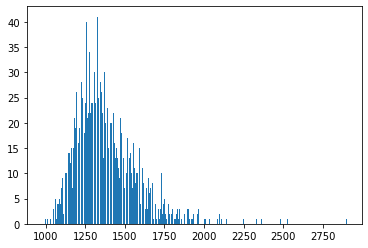

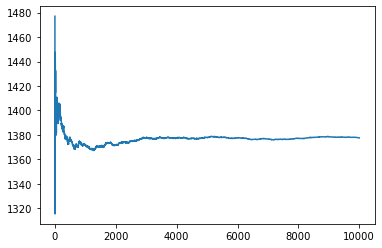

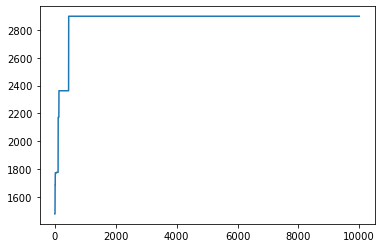

In [39]:
from joblib import Parallel, delayed

def sims(M,n):
    testround=10000
    rounds=np.zeros(testround)
    avg=np.zeros(testround)
    mx=np.zeros(testround)
    ret=Parallel(n_jobs=30)(delayed(sim)(M,n) for i in range(testround))
    for test in range (0,testround,1):
        print(test)
        print(ret[test])
        rounds[test],_=ret[test]
        avg[test]=sum(rounds)/(test+1)
        mx[test]=max(max(mx),rounds[test])

    r=collections.Counter(rounds)
    plt.bar(list(r.keys()), list(r.values()))
    plt.show()
    
    plt.plot(avg)
    plt.show()
    
    plt.plot(mx)
    plt.show()
    
interval = 10 #秒
M=10000
n=130 #署名参加者数
p=n/M
sims(M,n)

n=93 #署名参加者数
p=n/M
sims(M,n)

n=71 #署名参加者数
p=n/M
sims(M,n)

上記シミュレーションではすべてのユーザが直接的に署名の検証が可能になるまでのシステムとしての署名実行回数が$\gamma$回以下であることが示した．

次に，検証対象署名の保有者Holderが持つチェーン情報と検証者が持つチェーン情報から共同署名者をたどることで検証が可能になるまでに必要な署名ラウンドをシミュレーションする．

一つのシミュレーション結果として，共同署名者を見つけるまでに必要だった署名ラウンド数は下記のとおりであった．
- $\alpha=1/3$で$122$rounds=$20.3$分
- $\alpha=1/2$で$183$rounds=$30.5$分
- $\alpha=1/3$で$47$rounds=$7.83$分

In [33]:
def coli(M,n):
    p=n/M
    sigholderLedger=np.zeros(M)
    sigholderLedger[0]=1
    sigholderLedgerIndex=0 
    verifier = int(M*np.random.rand())
    verifierLedger=np.zeros(M)
    verifierLedger[verifier]=1
    verifierLedgerIndex=0
    round=0
    for loop in range (0,10000,1):
        siger=np.zeros(M)
        rand=np.random.rand(M)
        for i in range (0,M,1):
            if(rand[i]<p):
                siger[i]=1
        if siger[0]==1 or loop ==0:
            sigholderLedger=sigholderLedger+siger
            sigholderLedgerIndex+=1
            print("holder join in "+str(loop))
        if siger[verifier]==1:
            verifierLedger=verifierLedger+siger
            verifierLedgerIndex+=1
            print("verifier join in "+str(loop))
        # 署名者sigerと共有済み者stateとの重複を確認
        cor=np.matmul(verifierLedger,sigholderLedger.T)
        if cor >= 1:
            round = loop
            break
    print('round:{}\tM:{}\tn:{}\tsigholderledger:{}\tverifierledger:{}\tsindex:{}\tvindex:{}'.format(round,M,n,np.count_nonzero(sigholderLedger),np.count_nonzero(verifierLedger),sigholderLedgerIndex,verifierLedgerIndex))
    return round, sigholderLedgerIndex,verifierLedgerIndex,sigholderLedger,verifierLedger

M=10000
n=130 #署名参加者数
p=n/M
cround ,si,vi,sl,vl = coli(M,n)

n=93 #署名参加者数
p=n/M
cround ,si,vi,sl,vl = coli(M,n)

n=71 #署名参加者数
p=n/M
cround ,si,vi,sl,vl = coli(M,n)


holder join in 0
verifier join in 33
verifier join in 46
round:46	M:10000	n:130	sigholderledger:129	verifierledger:253	sindex:1	vindex:2
holder join in 0
holder join in 22
verifier join in 111
round:111	M:10000	n:93	sigholderledger:182	verifierledger:91	sindex:2	vindex:1
holder join in 0
verifier join in 129
round:129	M:10000	n:71	sigholderledger:78	verifierledger:77	sindex:1	vindex:1


検証対象署名の保有者Holderが持つチェーン情報と検証者が持つチェーン情報から共同署名者をたどることで検証が可能になるまでに必要な署名ラウンドをシミュレーションした一つのシミュレーション結果として，最短パスを探すことで検証可能になるまでに必要となった署名ラウンドと時間は以下の通り．


- $\alpha=1/3$で$0 \cdots500$rounds=$1.38$時間
- $\alpha=1/2$で$0 \cdots600$rounds=$1.66$時間
- $\alpha=1/3$で$0 \cdots600$rounds=$1.66$時間

実験の結果から署名をたどることでより短い検証不可能時間のみを許容し，検証すべき署名を検証できることを確認できた．

また，visつまり検証者が検証成功までに署名時間以降に実施した署名の数を見ると，Holderに比べて少なくなっていることから，検証不可能時間が多い場合の多くでは検証者が署名検証に参加していなかったことが推察される．つまり，検証者が署名に参加していなかったがゆえに検証ができない場合にのみ検証不可能時間が長くなるが，これは検証者の責任で推察できるものであるため，利用者＝検証者の納得性は得られると考える．

loop0
loop1
loop2
loop3
loop4
loop5
loop6
loop7
loop8
loop9
loop10
loop11
loop12
loop13
loop14
loop15
loop16
loop17
loop18
loop19
loop20
loop21
loop22
loop23
loop24
loop25
loop26
loop27
loop28
loop29
loop30
loop31
loop32
loop33
loop34
loop35
loop36
loop37
loop38
loop39
loop40
loop41
loop42
loop43
loop44
loop45
loop46
loop47
loop48
loop49
loop50
loop51
loop52
loop53
loop54
loop55
loop56
loop57
loop58
loop59
loop60
loop61
loop62
loop63
loop64
loop65
loop66
loop67
loop68
loop69
loop70
loop71
loop72
loop73
loop74
loop75
loop76
loop77
loop78
loop79
loop80
loop81
loop82
loop83
loop84
loop85
loop86
loop87
loop88
loop89
loop90
loop91
loop92
loop93
loop94
loop95
loop96
loop97
loop98
loop99
loop100
loop101
loop102
loop103
loop104
loop105
loop106
loop107
loop108
loop109
loop110
loop111
loop112
loop113
loop114
loop115
loop116
loop117
loop118
loop119
loop120
loop121
loop122
loop123
loop124
loop125
loop126
loop127
loop128
loop129
loop130
loop131
loop132
loop133
loop134
loop135
loop136
loop137
loop13

loop1033
loop1034
loop1035
loop1036
loop1037
loop1038
loop1039
loop1040
loop1041
loop1042
loop1043
loop1044
loop1045
loop1046
loop1047
loop1048
loop1049
loop1050
loop1051
loop1052
loop1053
loop1054
loop1055
loop1056
loop1057
loop1058
loop1059
loop1060
loop1061
loop1062
loop1063
loop1064
loop1065
loop1066
loop1067
loop1068
loop1069
loop1070
loop1071
loop1072
loop1073
loop1074
loop1075
loop1076
loop1077
loop1078
loop1079
loop1080
loop1081
loop1082
loop1083
loop1084
loop1085
loop1086
loop1087
loop1088
loop1089
loop1090
loop1091
loop1092
loop1093
loop1094
loop1095
loop1096
loop1097
loop1098
loop1099
loop1100
loop1101
loop1102
loop1103
loop1104
loop1105
loop1106
loop1107
loop1108
loop1109
loop1110
loop1111
loop1112
loop1113
loop1114
loop1115
loop1116
loop1117
loop1118
loop1119
loop1120
loop1121
loop1122
loop1123
loop1124
loop1125
loop1126
loop1127
loop1128
loop1129
loop1130
loop1131
loop1132
loop1133
loop1134
loop1135
loop1136
loop1137
loop1138
loop1139
loop1140
loop1141
loop1142
loop1143
l

loop1943
loop1944
loop1945
loop1946
loop1947
loop1948
loop1949
loop1950
loop1951
loop1952
loop1953
loop1954
loop1955
loop1956
loop1957
loop1958
loop1959
loop1960
loop1961
loop1962
loop1963
loop1964
loop1965
loop1966
loop1967
loop1968
loop1969
loop1970
loop1971
loop1972
loop1973
loop1974
loop1975
loop1976
loop1977
loop1978
loop1979
loop1980
loop1981
loop1982
loop1983
loop1984
loop1985
loop1986
loop1987
loop1988
loop1989
loop1990
loop1991
loop1992
loop1993
loop1994
loop1995
loop1996
loop1997
loop1998
loop1999
loop2000
loop2001
loop2002
loop2003
loop2004
loop2005
loop2006
loop2007
loop2008
loop2009
loop2010
loop2011
loop2012
loop2013
loop2014
loop2015
loop2016
loop2017
loop2018
loop2019
loop2020
loop2021
loop2022
loop2023
loop2024
loop2025
loop2026
loop2027
loop2028
loop2029
loop2030
loop2031
loop2032
loop2033
loop2034
loop2035
loop2036
loop2037
loop2038
loop2039
loop2040
loop2041
loop2042
loop2043
loop2044
loop2045
loop2046
loop2047
loop2048
loop2049
loop2050
loop2051
loop2052
loop2053
l

loop2853
loop2854
loop2855
loop2856
loop2857
loop2858
loop2859
loop2860
loop2861
loop2862
loop2863
loop2864
loop2865
loop2866
loop2867
loop2868
loop2869
loop2870
loop2871
loop2872
loop2873
loop2874
loop2875
loop2876
loop2877
loop2878
loop2879
loop2880
loop2881
loop2882
loop2883
loop2884
loop2885
loop2886
loop2887
loop2888
loop2889
loop2890
loop2891
loop2892
loop2893
loop2894
loop2895
loop2896
loop2897
loop2898
loop2899
loop2900
loop2901
loop2902
loop2903
loop2904
loop2905
loop2906
loop2907
loop2908
loop2909
loop2910
loop2911
loop2912
loop2913
loop2914
loop2915
loop2916
loop2917
loop2918
loop2919
loop2920
loop2921
loop2922
loop2923
loop2924
loop2925
loop2926
loop2927
loop2928
loop2929
loop2930
loop2931
loop2932
loop2933
loop2934
loop2935
loop2936
loop2937
loop2938
loop2939
loop2940
loop2941
loop2942
loop2943
loop2944
loop2945
loop2946
loop2947
loop2948
loop2949
loop2950
loop2951
loop2952
loop2953
loop2954
loop2955
loop2956
loop2957
loop2958
loop2959
loop2960
loop2961
loop2962
loop2963
l

loop3763
loop3764
loop3765
loop3766
loop3767
loop3768
loop3769
loop3770
loop3771
loop3772
loop3773
loop3774
loop3775
loop3776
loop3777
loop3778
loop3779
loop3780
loop3781
loop3782
loop3783
loop3784
loop3785
loop3786
loop3787
loop3788
loop3789
loop3790
loop3791
loop3792
loop3793
loop3794
loop3795
loop3796
loop3797
loop3798
loop3799
loop3800
loop3801
loop3802
loop3803
loop3804
loop3805
loop3806
loop3807
loop3808
loop3809
loop3810
loop3811
loop3812
loop3813
loop3814
loop3815
loop3816
loop3817
loop3818
loop3819
loop3820
loop3821
loop3822
loop3823
loop3824
loop3825
loop3826
loop3827
loop3828
loop3829
loop3830
loop3831
loop3832
loop3833
loop3834
loop3835
loop3836
loop3837
loop3838
loop3839
loop3840
loop3841
loop3842
loop3843
loop3844
loop3845
loop3846
loop3847
loop3848
loop3849
loop3850
loop3851
loop3852
loop3853
loop3854
loop3855
loop3856
loop3857
loop3858
loop3859
loop3860
loop3861
loop3862
loop3863
loop3864
loop3865
loop3866
loop3867
loop3868
loop3869
loop3870
loop3871
loop3872
loop3873
l

loop4673
loop4674
loop4675
loop4676
loop4677
loop4678
loop4679
loop4680
loop4681
loop4682
loop4683
loop4684
loop4685
loop4686
loop4687
loop4688
loop4689
loop4690
loop4691
loop4692
loop4693
loop4694
loop4695
loop4696
loop4697
loop4698
loop4699
loop4700
loop4701
loop4702
loop4703
loop4704
loop4705
loop4706
loop4707
loop4708
loop4709
loop4710
loop4711
loop4712
loop4713
loop4714
loop4715
loop4716
loop4717
loop4718
loop4719
loop4720
loop4721
loop4722
loop4723
loop4724
loop4725
loop4726
loop4727
loop4728
loop4729
loop4730
loop4731
loop4732
loop4733
loop4734
loop4735
loop4736
loop4737
loop4738
loop4739
loop4740
loop4741
loop4742
loop4743
loop4744
loop4745
loop4746
loop4747
loop4748
loop4749
loop4750
loop4751
loop4752
loop4753
loop4754
loop4755
loop4756
loop4757
loop4758
loop4759
loop4760
loop4761
loop4762
loop4763
loop4764
loop4765
loop4766
loop4767
loop4768
loop4769
loop4770
loop4771
loop4772
loop4773
loop4774
loop4775
loop4776
loop4777
loop4778
loop4779
loop4780
loop4781
loop4782
loop4783
l

loop5583
loop5584
loop5585
loop5586
loop5587
loop5588
loop5589
loop5590
loop5591
loop5592
loop5593
loop5594
loop5595
loop5596
loop5597
loop5598
loop5599
loop5600
loop5601
loop5602
loop5603
loop5604
loop5605
loop5606
loop5607
loop5608
loop5609
loop5610
loop5611
loop5612
loop5613
loop5614
loop5615
loop5616
loop5617
loop5618
loop5619
loop5620
loop5621
loop5622
loop5623
loop5624
loop5625
loop5626
loop5627
loop5628
loop5629
loop5630
loop5631
loop5632
loop5633
loop5634
loop5635
loop5636
loop5637
loop5638
loop5639
loop5640
loop5641
loop5642
loop5643
loop5644
loop5645
loop5646
loop5647
loop5648
loop5649
loop5650
loop5651
loop5652
loop5653
loop5654
loop5655
loop5656
loop5657
loop5658
loop5659
loop5660
loop5661
loop5662
loop5663
loop5664
loop5665
loop5666
loop5667
loop5668
loop5669
loop5670
loop5671
loop5672
loop5673
loop5674
loop5675
loop5676
loop5677
loop5678
loop5679
loop5680
loop5681
loop5682
loop5683
loop5684
loop5685
loop5686
loop5687
loop5688
loop5689
loop5690
loop5691
loop5692
loop5693
l

loop6493
loop6494
loop6495
loop6496
loop6497
loop6498
loop6499
loop6500
loop6501
loop6502
loop6503
loop6504
loop6505
loop6506
loop6507
loop6508
loop6509
loop6510
loop6511
loop6512
loop6513
loop6514
loop6515
loop6516
loop6517
loop6518
loop6519
loop6520
loop6521
loop6522
loop6523
loop6524
loop6525
loop6526
loop6527
loop6528
loop6529
loop6530
loop6531
loop6532
loop6533
loop6534
loop6535
loop6536
loop6537
loop6538
loop6539
loop6540
loop6541
loop6542
loop6543
loop6544
loop6545
loop6546
loop6547
loop6548
loop6549
loop6550
loop6551
loop6552
loop6553
loop6554
loop6555
loop6556
loop6557
loop6558
loop6559
loop6560
loop6561
loop6562
loop6563
loop6564
loop6565
loop6566
loop6567
loop6568
loop6569
loop6570
loop6571
loop6572
loop6573
loop6574
loop6575
loop6576
loop6577
loop6578
loop6579
loop6580
loop6581
loop6582
loop6583
loop6584
loop6585
loop6586
loop6587
loop6588
loop6589
loop6590
loop6591
loop6592
loop6593
loop6594
loop6595
loop6596
loop6597
loop6598
loop6599
loop6600
loop6601
loop6602
loop6603
l

loop7403
loop7404
loop7405
loop7406
loop7407
loop7408
loop7409
loop7410
loop7411
loop7412
loop7413
loop7414
loop7415
loop7416
loop7417
loop7418
loop7419
loop7420
loop7421
loop7422
loop7423
loop7424
loop7425
loop7426
loop7427
loop7428
loop7429
loop7430
loop7431
loop7432
loop7433
loop7434
loop7435
loop7436
loop7437
loop7438
loop7439
loop7440
loop7441
loop7442
loop7443
loop7444
loop7445
loop7446
loop7447
loop7448
loop7449
loop7450
loop7451
loop7452
loop7453
loop7454
loop7455
loop7456
loop7457
loop7458
loop7459
loop7460
loop7461
loop7462
loop7463
loop7464
loop7465
loop7466
loop7467
loop7468
loop7469
loop7470
loop7471
loop7472
loop7473
loop7474
loop7475
loop7476
loop7477
loop7478
loop7479
loop7480
loop7481
loop7482
loop7483
loop7484
loop7485
loop7486
loop7487
loop7488
loop7489
loop7490
loop7491
loop7492
loop7493
loop7494
loop7495
loop7496
loop7497
loop7498
loop7499
loop7500
loop7501
loop7502
loop7503
loop7504
loop7505
loop7506
loop7507
loop7508
loop7509
loop7510
loop7511
loop7512
loop7513
l

loop8313
loop8314
loop8315
loop8316
loop8317
loop8318
loop8319
loop8320
loop8321
loop8322
loop8323
loop8324
loop8325
loop8326
loop8327
loop8328
loop8329
loop8330
loop8331
loop8332
loop8333
loop8334
loop8335
loop8336
loop8337
loop8338
loop8339
loop8340
loop8341
loop8342
loop8343
loop8344
loop8345
loop8346
loop8347
loop8348
loop8349
loop8350
loop8351
loop8352
loop8353
loop8354
loop8355
loop8356
loop8357
loop8358
loop8359
loop8360
loop8361
loop8362
loop8363
loop8364
loop8365
loop8366
loop8367
loop8368
loop8369
loop8370
loop8371
loop8372
loop8373
loop8374
loop8375
loop8376
loop8377
loop8378
loop8379
loop8380
loop8381
loop8382
loop8383
loop8384
loop8385
loop8386
loop8387
loop8388
loop8389
loop8390
loop8391
loop8392
loop8393
loop8394
loop8395
loop8396
loop8397
loop8398
loop8399
loop8400
loop8401
loop8402
loop8403
loop8404
loop8405
loop8406
loop8407
loop8408
loop8409
loop8410
loop8411
loop8412
loop8413
loop8414
loop8415
loop8416
loop8417
loop8418
loop8419
loop8420
loop8421
loop8422
loop8423
l

loop9223
loop9224
loop9225
loop9226
loop9227
loop9228
loop9229
loop9230
loop9231
loop9232
loop9233
loop9234
loop9235
loop9236
loop9237
loop9238
loop9239
loop9240
loop9241
loop9242
loop9243
loop9244
loop9245
loop9246
loop9247
loop9248
loop9249
loop9250
loop9251
loop9252
loop9253
loop9254
loop9255
loop9256
loop9257
loop9258
loop9259
loop9260
loop9261
loop9262
loop9263
loop9264
loop9265
loop9266
loop9267
loop9268
loop9269
loop9270
loop9271
loop9272
loop9273
loop9274
loop9275
loop9276
loop9277
loop9278
loop9279
loop9280
loop9281
loop9282
loop9283
loop9284
loop9285
loop9286
loop9287
loop9288
loop9289
loop9290
loop9291
loop9292
loop9293
loop9294
loop9295
loop9296
loop9297
loop9298
loop9299
loop9300
loop9301
loop9302
loop9303
loop9304
loop9305
loop9306
loop9307
loop9308
loop9309
loop9310
loop9311
loop9312
loop9313
loop9314
loop9315
loop9316
loop9317
loop9318
loop9319
loop9320
loop9321
loop9322
loop9323
loop9324
loop9325
loop9326
loop9327
loop9328
loop9329
loop9330
loop9331
loop9332
loop9333
l

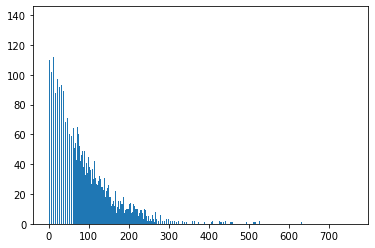

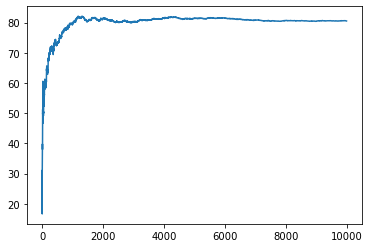

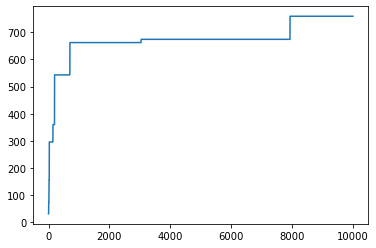

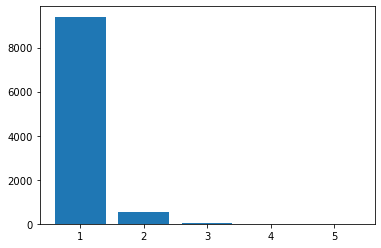

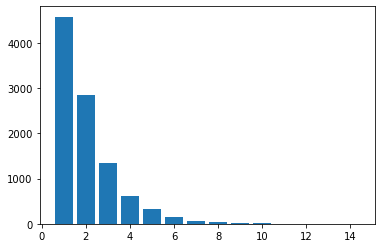

loop0
loop1
loop2
loop3
loop4
loop5
loop6
loop7
loop8
loop9
loop10
loop11
loop12
loop13
loop14
loop15
loop16
loop17
loop18
loop19
loop20
loop21
loop22
loop23
loop24
loop25
loop26
loop27
loop28
loop29
loop30
loop31
loop32
loop33
loop34
loop35
loop36
loop37
loop38
loop39
loop40
loop41
loop42
loop43
loop44
loop45
loop46
loop47
loop48
loop49
loop50
loop51
loop52
loop53
loop54
loop55
loop56
loop57
loop58
loop59
loop60
loop61
loop62
loop63
loop64
loop65
loop66
loop67
loop68
loop69
loop70
loop71
loop72
loop73
loop74
loop75
loop76
loop77
loop78
loop79
loop80
loop81
loop82
loop83
loop84
loop85
loop86
loop87
loop88
loop89
loop90
loop91
loop92
loop93
loop94
loop95
loop96
loop97
loop98
loop99
loop100
loop101
loop102
loop103
loop104
loop105
loop106
loop107
loop108
loop109
loop110
loop111
loop112
loop113
loop114
loop115
loop116
loop117
loop118
loop119
loop120
loop121
loop122
loop123
loop124
loop125
loop126
loop127
loop128
loop129
loop130
loop131
loop132
loop133
loop134
loop135
loop136
loop137
loop13

loop1033
loop1034
loop1035
loop1036
loop1037
loop1038
loop1039
loop1040
loop1041
loop1042
loop1043
loop1044
loop1045
loop1046
loop1047
loop1048
loop1049
loop1050
loop1051
loop1052
loop1053
loop1054
loop1055
loop1056
loop1057
loop1058
loop1059
loop1060
loop1061
loop1062
loop1063
loop1064
loop1065
loop1066
loop1067
loop1068
loop1069
loop1070
loop1071
loop1072
loop1073
loop1074
loop1075
loop1076
loop1077
loop1078
loop1079
loop1080
loop1081
loop1082
loop1083
loop1084
loop1085
loop1086
loop1087
loop1088
loop1089
loop1090
loop1091
loop1092
loop1093
loop1094
loop1095
loop1096
loop1097
loop1098
loop1099
loop1100
loop1101
loop1102
loop1103
loop1104
loop1105
loop1106
loop1107
loop1108
loop1109
loop1110
loop1111
loop1112
loop1113
loop1114
loop1115
loop1116
loop1117
loop1118
loop1119
loop1120
loop1121
loop1122
loop1123
loop1124
loop1125
loop1126
loop1127
loop1128
loop1129
loop1130
loop1131
loop1132
loop1133
loop1134
loop1135
loop1136
loop1137
loop1138
loop1139
loop1140
loop1141
loop1142
loop1143
l

loop1943
loop1944
loop1945
loop1946
loop1947
loop1948
loop1949
loop1950
loop1951
loop1952
loop1953
loop1954
loop1955
loop1956
loop1957
loop1958
loop1959
loop1960
loop1961
loop1962
loop1963
loop1964
loop1965
loop1966
loop1967
loop1968
loop1969
loop1970
loop1971
loop1972
loop1973
loop1974
loop1975
loop1976
loop1977
loop1978
loop1979
loop1980
loop1981
loop1982
loop1983
loop1984
loop1985
loop1986
loop1987
loop1988
loop1989
loop1990
loop1991
loop1992
loop1993
loop1994
loop1995
loop1996
loop1997
loop1998
loop1999
loop2000
loop2001
loop2002
loop2003
loop2004
loop2005
loop2006
loop2007
loop2008
loop2009
loop2010
loop2011
loop2012
loop2013
loop2014
loop2015
loop2016
loop2017
loop2018
loop2019
loop2020
loop2021
loop2022
loop2023
loop2024
loop2025
loop2026
loop2027
loop2028
loop2029
loop2030
loop2031
loop2032
loop2033
loop2034
loop2035
loop2036
loop2037
loop2038
loop2039
loop2040
loop2041
loop2042
loop2043
loop2044
loop2045
loop2046
loop2047
loop2048
loop2049
loop2050
loop2051
loop2052
loop2053
l

loop2853
loop2854
loop2855
loop2856
loop2857
loop2858
loop2859
loop2860
loop2861
loop2862
loop2863
loop2864
loop2865
loop2866
loop2867
loop2868
loop2869
loop2870
loop2871
loop2872
loop2873
loop2874
loop2875
loop2876
loop2877
loop2878
loop2879
loop2880
loop2881
loop2882
loop2883
loop2884
loop2885
loop2886
loop2887
loop2888
loop2889
loop2890
loop2891
loop2892
loop2893
loop2894
loop2895
loop2896
loop2897
loop2898
loop2899
loop2900
loop2901
loop2902
loop2903
loop2904
loop2905
loop2906
loop2907
loop2908
loop2909
loop2910
loop2911
loop2912
loop2913
loop2914
loop2915
loop2916
loop2917
loop2918
loop2919
loop2920
loop2921
loop2922
loop2923
loop2924
loop2925
loop2926
loop2927
loop2928
loop2929
loop2930
loop2931
loop2932
loop2933
loop2934
loop2935
loop2936
loop2937
loop2938
loop2939
loop2940
loop2941
loop2942
loop2943
loop2944
loop2945
loop2946
loop2947
loop2948
loop2949
loop2950
loop2951
loop2952
loop2953
loop2954
loop2955
loop2956
loop2957
loop2958
loop2959
loop2960
loop2961
loop2962
loop2963
l

loop3763
loop3764
loop3765
loop3766
loop3767
loop3768
loop3769
loop3770
loop3771
loop3772
loop3773
loop3774
loop3775
loop3776
loop3777
loop3778
loop3779
loop3780
loop3781
loop3782
loop3783
loop3784
loop3785
loop3786
loop3787
loop3788
loop3789
loop3790
loop3791
loop3792
loop3793
loop3794
loop3795
loop3796
loop3797
loop3798
loop3799
loop3800
loop3801
loop3802
loop3803
loop3804
loop3805
loop3806
loop3807
loop3808
loop3809
loop3810
loop3811
loop3812
loop3813
loop3814
loop3815
loop3816
loop3817
loop3818
loop3819
loop3820
loop3821
loop3822
loop3823
loop3824
loop3825
loop3826
loop3827
loop3828
loop3829
loop3830
loop3831
loop3832
loop3833
loop3834
loop3835
loop3836
loop3837
loop3838
loop3839
loop3840
loop3841
loop3842
loop3843
loop3844
loop3845
loop3846
loop3847
loop3848
loop3849
loop3850
loop3851
loop3852
loop3853
loop3854
loop3855
loop3856
loop3857
loop3858
loop3859
loop3860
loop3861
loop3862
loop3863
loop3864
loop3865
loop3866
loop3867
loop3868
loop3869
loop3870
loop3871
loop3872
loop3873
l

loop4673
loop4674
loop4675
loop4676
loop4677
loop4678
loop4679
loop4680
loop4681
loop4682
loop4683
loop4684
loop4685
loop4686
loop4687
loop4688
loop4689
loop4690
loop4691
loop4692
loop4693
loop4694
loop4695
loop4696
loop4697
loop4698
loop4699
loop4700
loop4701
loop4702
loop4703
loop4704
loop4705
loop4706
loop4707
loop4708
loop4709
loop4710
loop4711
loop4712
loop4713
loop4714
loop4715
loop4716
loop4717
loop4718
loop4719
loop4720
loop4721
loop4722
loop4723
loop4724
loop4725
loop4726
loop4727
loop4728
loop4729
loop4730
loop4731
loop4732
loop4733
loop4734
loop4735
loop4736
loop4737
loop4738
loop4739
loop4740
loop4741
loop4742
loop4743
loop4744
loop4745
loop4746
loop4747
loop4748
loop4749
loop4750
loop4751
loop4752
loop4753
loop4754
loop4755
loop4756
loop4757
loop4758
loop4759
loop4760
loop4761
loop4762
loop4763
loop4764
loop4765
loop4766
loop4767
loop4768
loop4769
loop4770
loop4771
loop4772
loop4773
loop4774
loop4775
loop4776
loop4777
loop4778
loop4779
loop4780
loop4781
loop4782
loop4783
l

loop5583
loop5584
loop5585
loop5586
loop5587
loop5588
loop5589
loop5590
loop5591
loop5592
loop5593
loop5594
loop5595
loop5596
loop5597
loop5598
loop5599
loop5600
loop5601
loop5602
loop5603
loop5604
loop5605
loop5606
loop5607
loop5608
loop5609
loop5610
loop5611
loop5612
loop5613
loop5614
loop5615
loop5616
loop5617
loop5618
loop5619
loop5620
loop5621
loop5622
loop5623
loop5624
loop5625
loop5626
loop5627
loop5628
loop5629
loop5630
loop5631
loop5632
loop5633
loop5634
loop5635
loop5636
loop5637
loop5638
loop5639
loop5640
loop5641
loop5642
loop5643
loop5644
loop5645
loop5646
loop5647
loop5648
loop5649
loop5650
loop5651
loop5652
loop5653
loop5654
loop5655
loop5656
loop5657
loop5658
loop5659
loop5660
loop5661
loop5662
loop5663
loop5664
loop5665
loop5666
loop5667
loop5668
loop5669
loop5670
loop5671
loop5672
loop5673
loop5674
loop5675
loop5676
loop5677
loop5678
loop5679
loop5680
loop5681
loop5682
loop5683
loop5684
loop5685
loop5686
loop5687
loop5688
loop5689
loop5690
loop5691
loop5692
loop5693
l

loop6493
loop6494
loop6495
loop6496
loop6497
loop6498
loop6499
loop6500
loop6501
loop6502
loop6503
loop6504
loop6505
loop6506
loop6507
loop6508
loop6509
loop6510
loop6511
loop6512
loop6513
loop6514
loop6515
loop6516
loop6517
loop6518
loop6519
loop6520
loop6521
loop6522
loop6523
loop6524
loop6525
loop6526
loop6527
loop6528
loop6529
loop6530
loop6531
loop6532
loop6533
loop6534
loop6535
loop6536
loop6537
loop6538
loop6539
loop6540
loop6541
loop6542
loop6543
loop6544
loop6545
loop6546
loop6547
loop6548
loop6549
loop6550
loop6551
loop6552
loop6553
loop6554
loop6555
loop6556
loop6557
loop6558
loop6559
loop6560
loop6561
loop6562
loop6563
loop6564
loop6565
loop6566
loop6567
loop6568
loop6569
loop6570
loop6571
loop6572
loop6573
loop6574
loop6575
loop6576
loop6577
loop6578
loop6579
loop6580
loop6581
loop6582
loop6583
loop6584
loop6585
loop6586
loop6587
loop6588
loop6589
loop6590
loop6591
loop6592
loop6593
loop6594
loop6595
loop6596
loop6597
loop6598
loop6599
loop6600
loop6601
loop6602
loop6603
l

loop7403
loop7404
loop7405
loop7406
loop7407
loop7408
loop7409
loop7410
loop7411
loop7412
loop7413
loop7414
loop7415
loop7416
loop7417
loop7418
loop7419
loop7420
loop7421
loop7422
loop7423
loop7424
loop7425
loop7426
loop7427
loop7428
loop7429
loop7430
loop7431
loop7432
loop7433
loop7434
loop7435
loop7436
loop7437
loop7438
loop7439
loop7440
loop7441
loop7442
loop7443
loop7444
loop7445
loop7446
loop7447
loop7448
loop7449
loop7450
loop7451
loop7452
loop7453
loop7454
loop7455
loop7456
loop7457
loop7458
loop7459
loop7460
loop7461
loop7462
loop7463
loop7464
loop7465
loop7466
loop7467
loop7468
loop7469
loop7470
loop7471
loop7472
loop7473
loop7474
loop7475
loop7476
loop7477
loop7478
loop7479
loop7480
loop7481
loop7482
loop7483
loop7484
loop7485
loop7486
loop7487
loop7488
loop7489
loop7490
loop7491
loop7492
loop7493
loop7494
loop7495
loop7496
loop7497
loop7498
loop7499
loop7500
loop7501
loop7502
loop7503
loop7504
loop7505
loop7506
loop7507
loop7508
loop7509
loop7510
loop7511
loop7512
loop7513
l

loop8313
loop8314
loop8315
loop8316
loop8317
loop8318
loop8319
loop8320
loop8321
loop8322
loop8323
loop8324
loop8325
loop8326
loop8327
loop8328
loop8329
loop8330
loop8331
loop8332
loop8333
loop8334
loop8335
loop8336
loop8337
loop8338
loop8339
loop8340
loop8341
loop8342
loop8343
loop8344
loop8345
loop8346
loop8347
loop8348
loop8349
loop8350
loop8351
loop8352
loop8353
loop8354
loop8355
loop8356
loop8357
loop8358
loop8359
loop8360
loop8361
loop8362
loop8363
loop8364
loop8365
loop8366
loop8367
loop8368
loop8369
loop8370
loop8371
loop8372
loop8373
loop8374
loop8375
loop8376
loop8377
loop8378
loop8379
loop8380
loop8381
loop8382
loop8383
loop8384
loop8385
loop8386
loop8387
loop8388
loop8389
loop8390
loop8391
loop8392
loop8393
loop8394
loop8395
loop8396
loop8397
loop8398
loop8399
loop8400
loop8401
loop8402
loop8403
loop8404
loop8405
loop8406
loop8407
loop8408
loop8409
loop8410
loop8411
loop8412
loop8413
loop8414
loop8415
loop8416
loop8417
loop8418
loop8419
loop8420
loop8421
loop8422
loop8423
l

loop9223
loop9224
loop9225
loop9226
loop9227
loop9228
loop9229
loop9230
loop9231
loop9232
loop9233
loop9234
loop9235
loop9236
loop9237
loop9238
loop9239
loop9240
loop9241
loop9242
loop9243
loop9244
loop9245
loop9246
loop9247
loop9248
loop9249
loop9250
loop9251
loop9252
loop9253
loop9254
loop9255
loop9256
loop9257
loop9258
loop9259
loop9260
loop9261
loop9262
loop9263
loop9264
loop9265
loop9266
loop9267
loop9268
loop9269
loop9270
loop9271
loop9272
loop9273
loop9274
loop9275
loop9276
loop9277
loop9278
loop9279
loop9280
loop9281
loop9282
loop9283
loop9284
loop9285
loop9286
loop9287
loop9288
loop9289
loop9290
loop9291
loop9292
loop9293
loop9294
loop9295
loop9296
loop9297
loop9298
loop9299
loop9300
loop9301
loop9302
loop9303
loop9304
loop9305
loop9306
loop9307
loop9308
loop9309
loop9310
loop9311
loop9312
loop9313
loop9314
loop9315
loop9316
loop9317
loop9318
loop9319
loop9320
loop9321
loop9322
loop9323
loop9324
loop9325
loop9326
loop9327
loop9328
loop9329
loop9330
loop9331
loop9332
loop9333
l

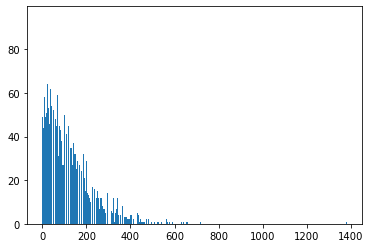

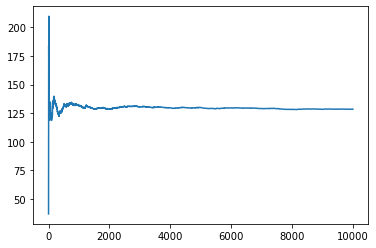

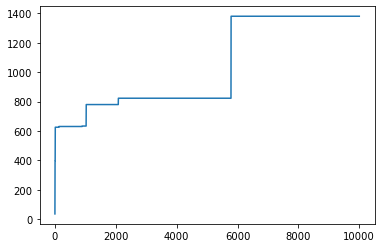

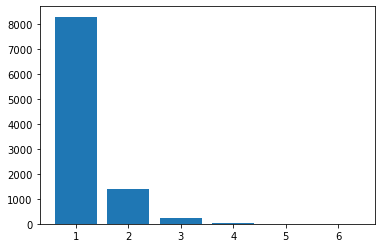

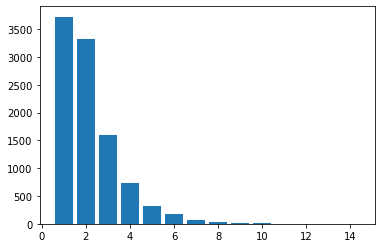

loop0
loop1
loop2
loop3
loop4
loop5
loop6
loop7
loop8
loop9
loop10
loop11
loop12
loop13
loop14
loop15
loop16
loop17
loop18
loop19
loop20
loop21
loop22
loop23
loop24
loop25
loop26
loop27
loop28
loop29
loop30
loop31
loop32
loop33
loop34
loop35
loop36
loop37
loop38
loop39
loop40
loop41
loop42
loop43
loop44
loop45
loop46
loop47
loop48
loop49
loop50
loop51
loop52
loop53
loop54
loop55
loop56
loop57
loop58
loop59
loop60
loop61
loop62
loop63
loop64
loop65
loop66
loop67
loop68
loop69
loop70
loop71
loop72
loop73
loop74
loop75
loop76
loop77
loop78
loop79
loop80
loop81
loop82
loop83
loop84
loop85
loop86
loop87
loop88
loop89
loop90
loop91
loop92
loop93
loop94
loop95
loop96
loop97
loop98
loop99
loop100
loop101
loop102
loop103
loop104
loop105
loop106
loop107
loop108
loop109
loop110
loop111
loop112
loop113
loop114
loop115
loop116
loop117
loop118
loop119
loop120
loop121
loop122
loop123
loop124
loop125
loop126
loop127
loop128
loop129
loop130
loop131
loop132
loop133
loop134
loop135
loop136
loop137
loop13

loop1033
loop1034
loop1035
loop1036
loop1037
loop1038
loop1039
loop1040
loop1041
loop1042
loop1043
loop1044
loop1045
loop1046
loop1047
loop1048
loop1049
loop1050
loop1051
loop1052
loop1053
loop1054
loop1055
loop1056
loop1057
loop1058
loop1059
loop1060
loop1061
loop1062
loop1063
loop1064
loop1065
loop1066
loop1067
loop1068
loop1069
loop1070
loop1071
loop1072
loop1073
loop1074
loop1075
loop1076
loop1077
loop1078
loop1079
loop1080
loop1081
loop1082
loop1083
loop1084
loop1085
loop1086
loop1087
loop1088
loop1089
loop1090
loop1091
loop1092
loop1093
loop1094
loop1095
loop1096
loop1097
loop1098
loop1099
loop1100
loop1101
loop1102
loop1103
loop1104
loop1105
loop1106
loop1107
loop1108
loop1109
loop1110
loop1111
loop1112
loop1113
loop1114
loop1115
loop1116
loop1117
loop1118
loop1119
loop1120
loop1121
loop1122
loop1123
loop1124
loop1125
loop1126
loop1127
loop1128
loop1129
loop1130
loop1131
loop1132
loop1133
loop1134
loop1135
loop1136
loop1137
loop1138
loop1139
loop1140
loop1141
loop1142
loop1143
l

loop1943
loop1944
loop1945
loop1946
loop1947
loop1948
loop1949
loop1950
loop1951
loop1952
loop1953
loop1954
loop1955
loop1956
loop1957
loop1958
loop1959
loop1960
loop1961
loop1962
loop1963
loop1964
loop1965
loop1966
loop1967
loop1968
loop1969
loop1970
loop1971
loop1972
loop1973
loop1974
loop1975
loop1976
loop1977
loop1978
loop1979
loop1980
loop1981
loop1982
loop1983
loop1984
loop1985
loop1986
loop1987
loop1988
loop1989
loop1990
loop1991
loop1992
loop1993
loop1994
loop1995
loop1996
loop1997
loop1998
loop1999
loop2000
loop2001
loop2002
loop2003
loop2004
loop2005
loop2006
loop2007
loop2008
loop2009
loop2010
loop2011
loop2012
loop2013
loop2014
loop2015
loop2016
loop2017
loop2018
loop2019
loop2020
loop2021
loop2022
loop2023
loop2024
loop2025
loop2026
loop2027
loop2028
loop2029
loop2030
loop2031
loop2032
loop2033
loop2034
loop2035
loop2036
loop2037
loop2038
loop2039
loop2040
loop2041
loop2042
loop2043
loop2044
loop2045
loop2046
loop2047
loop2048
loop2049
loop2050
loop2051
loop2052
loop2053
l

loop2853
loop2854
loop2855
loop2856
loop2857
loop2858
loop2859
loop2860
loop2861
loop2862
loop2863
loop2864
loop2865
loop2866
loop2867
loop2868
loop2869
loop2870
loop2871
loop2872
loop2873
loop2874
loop2875
loop2876
loop2877
loop2878
loop2879
loop2880
loop2881
loop2882
loop2883
loop2884
loop2885
loop2886
loop2887
loop2888
loop2889
loop2890
loop2891
loop2892
loop2893
loop2894
loop2895
loop2896
loop2897
loop2898
loop2899
loop2900
loop2901
loop2902
loop2903
loop2904
loop2905
loop2906
loop2907
loop2908
loop2909
loop2910
loop2911
loop2912
loop2913
loop2914
loop2915
loop2916
loop2917
loop2918
loop2919
loop2920
loop2921
loop2922
loop2923
loop2924
loop2925
loop2926
loop2927
loop2928
loop2929
loop2930
loop2931
loop2932
loop2933
loop2934
loop2935
loop2936
loop2937
loop2938
loop2939
loop2940
loop2941
loop2942
loop2943
loop2944
loop2945
loop2946
loop2947
loop2948
loop2949
loop2950
loop2951
loop2952
loop2953
loop2954
loop2955
loop2956
loop2957
loop2958
loop2959
loop2960
loop2961
loop2962
loop2963
l

loop3763
loop3764
loop3765
loop3766
loop3767
loop3768
loop3769
loop3770
loop3771
loop3772
loop3773
loop3774
loop3775
loop3776
loop3777
loop3778
loop3779
loop3780
loop3781
loop3782
loop3783
loop3784
loop3785
loop3786
loop3787
loop3788
loop3789
loop3790
loop3791
loop3792
loop3793
loop3794
loop3795
loop3796
loop3797
loop3798
loop3799
loop3800
loop3801
loop3802
loop3803
loop3804
loop3805
loop3806
loop3807
loop3808
loop3809
loop3810
loop3811
loop3812
loop3813
loop3814
loop3815
loop3816
loop3817
loop3818
loop3819
loop3820
loop3821
loop3822
loop3823
loop3824
loop3825
loop3826
loop3827
loop3828
loop3829
loop3830
loop3831
loop3832
loop3833
loop3834
loop3835
loop3836
loop3837
loop3838
loop3839
loop3840
loop3841
loop3842
loop3843
loop3844
loop3845
loop3846
loop3847
loop3848
loop3849
loop3850
loop3851
loop3852
loop3853
loop3854
loop3855
loop3856
loop3857
loop3858
loop3859
loop3860
loop3861
loop3862
loop3863
loop3864
loop3865
loop3866
loop3867
loop3868
loop3869
loop3870
loop3871
loop3872
loop3873
l

loop4673
loop4674
loop4675
loop4676
loop4677
loop4678
loop4679
loop4680
loop4681
loop4682
loop4683
loop4684
loop4685
loop4686
loop4687
loop4688
loop4689
loop4690
loop4691
loop4692
loop4693
loop4694
loop4695
loop4696
loop4697
loop4698
loop4699
loop4700
loop4701
loop4702
loop4703
loop4704
loop4705
loop4706
loop4707
loop4708
loop4709
loop4710
loop4711
loop4712
loop4713
loop4714
loop4715
loop4716
loop4717
loop4718
loop4719
loop4720
loop4721
loop4722
loop4723
loop4724
loop4725
loop4726
loop4727
loop4728
loop4729
loop4730
loop4731
loop4732
loop4733
loop4734
loop4735
loop4736
loop4737
loop4738
loop4739
loop4740
loop4741
loop4742
loop4743
loop4744
loop4745
loop4746
loop4747
loop4748
loop4749
loop4750
loop4751
loop4752
loop4753
loop4754
loop4755
loop4756
loop4757
loop4758
loop4759
loop4760
loop4761
loop4762
loop4763
loop4764
loop4765
loop4766
loop4767
loop4768
loop4769
loop4770
loop4771
loop4772
loop4773
loop4774
loop4775
loop4776
loop4777
loop4778
loop4779
loop4780
loop4781
loop4782
loop4783
l

loop5583
loop5584
loop5585
loop5586
loop5587
loop5588
loop5589
loop5590
loop5591
loop5592
loop5593
loop5594
loop5595
loop5596
loop5597
loop5598
loop5599
loop5600
loop5601
loop5602
loop5603
loop5604
loop5605
loop5606
loop5607
loop5608
loop5609
loop5610
loop5611
loop5612
loop5613
loop5614
loop5615
loop5616
loop5617
loop5618
loop5619
loop5620
loop5621
loop5622
loop5623
loop5624
loop5625
loop5626
loop5627
loop5628
loop5629
loop5630
loop5631
loop5632
loop5633
loop5634
loop5635
loop5636
loop5637
loop5638
loop5639
loop5640
loop5641
loop5642
loop5643
loop5644
loop5645
loop5646
loop5647
loop5648
loop5649
loop5650
loop5651
loop5652
loop5653
loop5654
loop5655
loop5656
loop5657
loop5658
loop5659
loop5660
loop5661
loop5662
loop5663
loop5664
loop5665
loop5666
loop5667
loop5668
loop5669
loop5670
loop5671
loop5672
loop5673
loop5674
loop5675
loop5676
loop5677
loop5678
loop5679
loop5680
loop5681
loop5682
loop5683
loop5684
loop5685
loop5686
loop5687
loop5688
loop5689
loop5690
loop5691
loop5692
loop5693
l

loop6493
loop6494
loop6495
loop6496
loop6497
loop6498
loop6499
loop6500
loop6501
loop6502
loop6503
loop6504
loop6505
loop6506
loop6507
loop6508
loop6509
loop6510
loop6511
loop6512
loop6513
loop6514
loop6515
loop6516
loop6517
loop6518
loop6519
loop6520
loop6521
loop6522
loop6523
loop6524
loop6525
loop6526
loop6527
loop6528
loop6529
loop6530
loop6531
loop6532
loop6533
loop6534
loop6535
loop6536
loop6537
loop6538
loop6539
loop6540
loop6541
loop6542
loop6543
loop6544
loop6545
loop6546
loop6547
loop6548
loop6549
loop6550
loop6551
loop6552
loop6553
loop6554
loop6555
loop6556
loop6557
loop6558
loop6559
loop6560
loop6561
loop6562
loop6563
loop6564
loop6565
loop6566
loop6567
loop6568
loop6569
loop6570
loop6571
loop6572
loop6573
loop6574
loop6575
loop6576
loop6577
loop6578
loop6579
loop6580
loop6581
loop6582
loop6583
loop6584
loop6585
loop6586
loop6587
loop6588
loop6589
loop6590
loop6591
loop6592
loop6593
loop6594
loop6595
loop6596
loop6597
loop6598
loop6599
loop6600
loop6601
loop6602
loop6603
l

loop7403
loop7404
loop7405
loop7406
loop7407
loop7408
loop7409
loop7410
loop7411
loop7412
loop7413
loop7414
loop7415
loop7416
loop7417
loop7418
loop7419
loop7420
loop7421
loop7422
loop7423
loop7424
loop7425
loop7426
loop7427
loop7428
loop7429
loop7430
loop7431
loop7432
loop7433
loop7434
loop7435
loop7436
loop7437
loop7438
loop7439
loop7440
loop7441
loop7442
loop7443
loop7444
loop7445
loop7446
loop7447
loop7448
loop7449
loop7450
loop7451
loop7452
loop7453
loop7454
loop7455
loop7456
loop7457
loop7458
loop7459
loop7460
loop7461
loop7462
loop7463
loop7464
loop7465
loop7466
loop7467
loop7468
loop7469
loop7470
loop7471
loop7472
loop7473
loop7474
loop7475
loop7476
loop7477
loop7478
loop7479
loop7480
loop7481
loop7482
loop7483
loop7484
loop7485
loop7486
loop7487
loop7488
loop7489
loop7490
loop7491
loop7492
loop7493
loop7494
loop7495
loop7496
loop7497
loop7498
loop7499
loop7500
loop7501
loop7502
loop7503
loop7504
loop7505
loop7506
loop7507
loop7508
loop7509
loop7510
loop7511
loop7512
loop7513
l

loop8313
loop8314
loop8315
loop8316
loop8317
loop8318
loop8319
loop8320
loop8321
loop8322
loop8323
loop8324
loop8325
loop8326
loop8327
loop8328
loop8329
loop8330
loop8331
loop8332
loop8333
loop8334
loop8335
loop8336
loop8337
loop8338
loop8339
loop8340
loop8341
loop8342
loop8343
loop8344
loop8345
loop8346
loop8347
loop8348
loop8349
loop8350
loop8351
loop8352
loop8353
loop8354
loop8355
loop8356
loop8357
loop8358
loop8359
loop8360
loop8361
loop8362
loop8363
loop8364
loop8365
loop8366
loop8367
loop8368
loop8369
loop8370
loop8371
loop8372
loop8373
loop8374
loop8375
loop8376
loop8377
loop8378
loop8379
loop8380
loop8381
loop8382
loop8383
loop8384
loop8385
loop8386
loop8387
loop8388
loop8389
loop8390
loop8391
loop8392
loop8393
loop8394
loop8395
loop8396
loop8397
loop8398
loop8399
loop8400
loop8401
loop8402
loop8403
loop8404
loop8405
loop8406
loop8407
loop8408
loop8409
loop8410
loop8411
loop8412
loop8413
loop8414
loop8415
loop8416
loop8417
loop8418
loop8419
loop8420
loop8421
loop8422
loop8423
l

loop9223
loop9224
loop9225
loop9226
loop9227
loop9228
loop9229
loop9230
loop9231
loop9232
loop9233
loop9234
loop9235
loop9236
loop9237
loop9238
loop9239
loop9240
loop9241
loop9242
loop9243
loop9244
loop9245
loop9246
loop9247
loop9248
loop9249
loop9250
loop9251
loop9252
loop9253
loop9254
loop9255
loop9256
loop9257
loop9258
loop9259
loop9260
loop9261
loop9262
loop9263
loop9264
loop9265
loop9266
loop9267
loop9268
loop9269
loop9270
loop9271
loop9272
loop9273
loop9274
loop9275
loop9276
loop9277
loop9278
loop9279
loop9280
loop9281
loop9282
loop9283
loop9284
loop9285
loop9286
loop9287
loop9288
loop9289
loop9290
loop9291
loop9292
loop9293
loop9294
loop9295
loop9296
loop9297
loop9298
loop9299
loop9300
loop9301
loop9302
loop9303
loop9304
loop9305
loop9306
loop9307
loop9308
loop9309
loop9310
loop9311
loop9312
loop9313
loop9314
loop9315
loop9316
loop9317
loop9318
loop9319
loop9320
loop9321
loop9322
loop9323
loop9324
loop9325
loop9326
loop9327
loop9328
loop9329
loop9330
loop9331
loop9332
loop9333
l

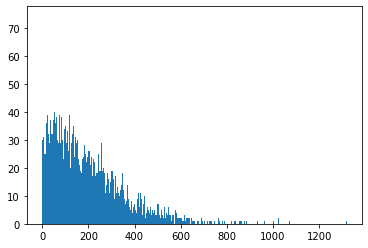

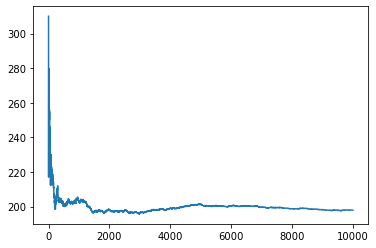

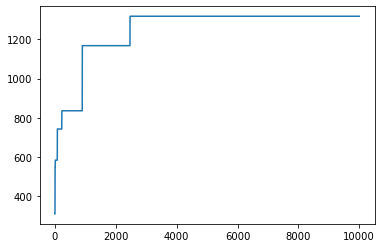

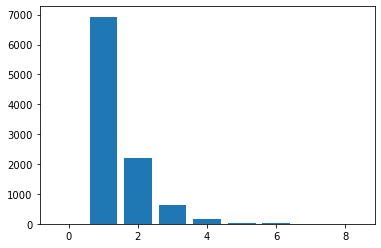

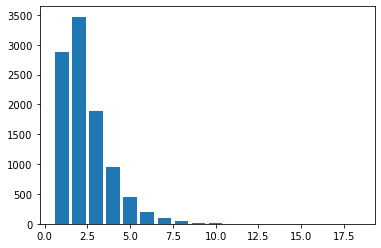

In [40]:
def colis(M,n):
    testround = 10000
    crounds =[]
    vis =[]
    sis =[]
    vls =[]
    sls =[]
    avg=np.zeros(testround)
    mx=np.zeros(testround)

    ret=Parallel(n_jobs=30)(delayed(coli)(M,n) for i in range(testround))
    for i in range(0,testround):
        print("loop"+str(i))
        cround ,si,vi,sl,vl = ret[i]
        crounds.append(cround)
        sis.append(si)
        vis.append(vi)
        sls.append(sl)
        vls.append(vl)
        avg[i]=sum(crounds)/(i+1)
        mx[i]=max(max(mx),cround)

    r=collections.Counter(crounds)
    v=collections.Counter(vis)
    s=collections.Counter(sis)
    plt.bar(list(r.keys()), list(r.values()))
    plt.show()
    
    plt.plot(avg)
    plt.show()
    
    plt.plot(mx)
    plt.show()
    
    plt.bar(list(v.keys()), list(v.values()))
    plt.show()
    plt.bar(list(s.keys()), list(s.values()))
    plt.show()
    return crounds, vis,sis,vls,sls
    
M=10000
n=130 #署名参加者数
p=n/M
crounds130, vis130,sis130,vls130,sls130=colis(M,n)

n=93 #署名参加者数
p=n/M
crounds93, vis93,sis93,vls93,sls93=colis(M,n)

n=71 #署名参加者数
p=n/M
crounds71, vis71,sis71,vls71,sls71=colis(M,n)

In [20]:
collections.Counter(crounds71)

Counter({401: 1,
         23: 1,
         240: 1,
         499: 1,
         27: 2,
         206: 1,
         24: 1,
         527: 1,
         389: 1,
         29: 2,
         227: 1,
         81: 1,
         130: 1,
         557: 1,
         67: 1,
         154: 1,
         214: 1,
         91: 2,
         100: 1,
         41: 1,
         425: 1,
         535: 1,
         372: 1,
         161: 1,
         363: 1,
         343: 1,
         42: 1,
         94: 1,
         281: 1,
         129: 1,
         201: 1,
         239: 1,
         128: 2,
         10: 1,
         162: 1,
         294: 1,
         249: 1,
         218: 2,
         105: 1,
         416: 1,
         362: 1,
         370: 1,
         54: 2,
         402: 1,
         117: 1,
         13: 1,
         151: 2,
         113: 1,
         131: 1,
         83: 1,
         16: 1,
         253: 1,
         490: 1,
         473: 1,
         78: 1,
         358: 1,
         115: 1,
         443: 1,
         187: 1,
         88: 

# 署名サイズ

https://bitcoinops.org/en/tools/calc-size/

https://cryptobook.nakov.com/digital-signatures/ecdsa-sign-verify-messages#:~:text=ECDSA%20signatures%20are%202%20times,the%20signature%20is%201042%20bits.

をベースに署名サイズと公開鍵サイズを考える．

+ 鍵長＝64B
+ 署名長＝256B
+ ハッシュ＝64B

この場合，単純にすべてのデータに対する全ての署名を保管するデータ構造を用いると署名者週が多くなると安全性を署名サイズが大きくなる．

https://eprint.iacr.org/2015/164.pdf

コンスタントサイズのリング署名によって署名帳を1＝256Bに限定できる？

In [46]:
# M=10000
# n=163
# p=n/M
m=100 # 署名依頼者数
sig=256
key=64
has=64
interval=findsaveinterval(p,interval) # 各ノードの平均署名間隔システム全体の平均署名間隔は1/pを乗じたものになる．

# 何も考えないで，全ての署名と鍵を乗せる．
datasizepersig=(n*(sig+key+has)+m*(key+has))/(1024**2)
signum=60*60*24/interval
print('blocksize:{}MB,\tdayly datasize:{}MB\tanualy datasize:{}GB'.format(datasizepersig,datasizepersig*signum,datasizepersig*signum*365/1024))

# リング署名によって署名長を短縮
datasizepersig=(n*(key+has)+sig+m*(key+has))/(1024**2)
signum=60*60*24/interval
print('blocksize:{}MB,\tdayly datasize:{}MB\tanualy datasize:{}GB'.format(datasizepersig,datasizepersig*signum,datasizepersig*signum*365/1024))

blocksize:0.0579833984375MB,	dayly datasize:6.26220703125MB	anualy datasize:2.2321343421936035GB
blocksize:0.0277099609375MB,	dayly datasize:2.99267578125MB	anualy datasize:1.066725254058838GB
